Neste projeto, desenvolvido no âmbito da disciplina CCF425 - Introdução à Ciência
dos Dados, buscamos aplicar os conceitos teóricos aprendidos em sala de aula para analisar
conjuntos de dados reais e desafiadores. O trabalho está dividido em cinco etapas, cada uma
com objetivos específicos, culminando em uma apresentação final que destaca as principais
descobertas.
Nesta primeira etapa, nosso foco é o entendimento inicial dos dados e sua preparação.
Trabalharemos com um dos conjuntos de dados disponíveis: Dados de criminalidade de SP
(SPSafe) ou Dados demográficos dos municípios brasileiros (BrStats), dependendo da turma
prática. Nosso grupo ficou responsável pelo conjunto de dados do SPSafe. O objetivo é
explorar os atributos presentes, identificar possíveis ruídos, tratar informações ausentes e
formular pelo menos 10 perguntas que guiarão nossas análises futuras. Além disso,
realizaremos ajustes na formatação dos dados, enriquecimento com atributos externos e
outras atividades necessárias para garantir a qualidade da base de dados.
A entrega desta etapa inclui a criação de um projeto no GitHub, onde disponibilizaremos um
arquivo README com os integrantes do grupo, as perguntas elaboradas, o código utilizado e
um relatório parcial documentando as decisões tomadas e suas justificativas. Cada integrante
contribuirá ativamente, e suas ações serão registradas no histórico de commits e na
documentação.
Esta fase é fundamental para estabelecer as bases do projeto, garantindo que os dados
estejam prontos para as análises exploratórias e técnicas mais avançadas que serão aplicadas
nas etapas subsequentes. Com um trabalho bem estruturado desde o início, estaremos
preparados para enfrentar os desafios típicos da Ciência de Dados e extrair insights valiosos
dos conjuntos de dados selecionados.


**Papéis de cada integrante**
Todos os integrantes tiveram papel fundamental no decorrer do trabalho até aqui, seja
contribuindo com as ideias e perguntas, ou seja contribuindo com desenvolvimento dos
códigos. A seguir detalharemos o papel de cada integrante:

➢ Arthur Teodoro: Participou ativamente no desenvolvimento e decisão das das
perguntas, na elaboração do relatório e foi responsável pela implementação da adição
dos dados externos de “Datas Atípicas”.

➢ Gabriel Benez: Participou na criação e decisão de quais perguntas selecionar, na
elaboração do relatório e também foi responsável pela a implementação do código que
preenche os dados vazios do campo “Cidade”, e detecção de alguns ruídos.

➢ Lucas Fonseca: Participou ativamente no desenvolvimento e decisão das das
perguntas, na elaboração do relatório e foi responsável pela implementação e melhora da adição
dos dados externos de “Incidentes”, remoção de dados dublipcados,adição de correlação e gráficos de;
"Quantidade de BO's por dia na semana", "Relação quantidades BO's com periodo do Dia",
"Dias da semana têm maior incidência de invasões domiciliares (Pergunta 8)", associatividade entre tipo de crimes
e o local de alaboração do BO, e associação de datas de jogos de futebol com tipo de crimes.

➢ Matheus Kauan: Responsável pela criação do repositório e adição dos
colaboradores. Participou ativamente no desenvolvimento e nas escolhas das
perguntas e também trabalhou na adição/criação de uma nova coluna no dataframe
inserindo os dias da semana correspondente a data

In [4]:
import subprocess
import sys
import json
import pandas as pd
import numpy as np
from shapely.geometry import Point
import math
import geopandas as gpd
import re
from rapidfuzz import process, fuzz
import unicodedata
import matplotlib.pyplot as pl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import plotly.express as px

<H2 align="center"> Baixar o arquivo csv, caso não tenha baixado o arquivo via github:</H2>


In [5]:

# Tenta importar gdown, se não conseguir, instala
try:
    import gdown  # Tenta importar novamente após a instalação
except ImportError:
    print("📥 gdown não encontrado. Instalando automaticamente...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "gdown"])

# Baixar o arquivo do Google Drive

file_id = "1VbB_fvowkgNoWcLADi1mEfFjWQI6nBjp"
url = f"https://drive.google.com/uc?id={file_id}"
output = "dados/SpSafe_2022.csv"

gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1VbB_fvowkgNoWcLADi1mEfFjWQI6nBjp
From (redirected): https://drive.google.com/uc?id=1VbB_fvowkgNoWcLADi1mEfFjWQI6nBjp&confirm=t&uuid=f06cdcdc-2c4f-401d-804e-7d1cd3dfc221
To: /home/Lucas/Documentos/Codes/Python/Ciencia-de-Dados-Projeto-TP/dados/SpSafe_2022.csv
100%|██████████| 305M/305M [00:08<00:00, 35.7MB/s] 


'dados/SpSafe_2022.csv'

<p align="center">
  Leitura do arquivo
</p>

In [6]:

df = pd.read_csv('dados/SpSafe_2022.csv', delimiter=';')
pd.set_option('display.max_columns', None)

/tmp/ipykernel_23256/2469170207.py:1: DtypeWarning: Columns (10,11,16,17,19,20,21,22,24,25,26,27,28,29,30,31,32,35,36,38,39,41,42,43,44,45,46,47,48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dados/SpSafe_2022.csv', delimiter=';')


Verificando os diferentes tipos de crimes registrados:

In [7]:
df['NATUREZA_APURADA'].dropna().unique()

array(['HOMICIDIO DOLOSO', 'LATROCINIO',
       'MORTE DECORRENTE DE INTERVENCAO POLICIAL',
       'LESAO CORPORAL SEGUIDA DE MORTE', 'MORTE SUSPEITA',
       'FURTO (ART. 155) - INTERIOR DE VEICULO',
       'FURTO (ART. 155) - TRANSEUNTE', 'FURTO (ART. 155) - OUTROS',
       'FURTO (ART. 155) - ESTABELECIMENTO COMERCIAL',
       'CALUNIA (ART. 138)', 'INJURIA (ART. 140)', 'DESACATO (ART. 331)',
       'RESISTENCIA (ART. 329)', 'FURTO (ART. 155) - VEICULO',
       'FURTO QUALIFICADO (ART. 155, §4O.) - INTERIOR DE VEICULO',
       'FURTO QUALIFICADO (ART. 155, §4O.) - RESIDENCIA',
       'FURTO (ART. 155) - RESIDENCIA', 'AMEACA (ART. 147)',
       'FURTO QUALIFICADO (ART. 155, §4O.) - ESTABELECIMENTO COMERCIAL',
       'DIRIGIR SEM PERMISSAO OU HABILITACAO (ART. 309)',
       'EMBRIAGUEZ AO VOLANTE (ART. 306)',
       'FURTO (ART. 155) - APLICATIVO DE MOBILIDADE URBANA',
       'FURTO (ART. 155) - CONDOMINIO RESIDENCIAL',
       'A.I.-DROGAS SEM AUTORIZACAO OU EM DESACORDO (ART.33, CAPU

Dados nulos para profissão

Pensamos em analisar a correlação das vítimas e suas profissões, mas grande parte dos dados são nulos.

In [8]:
porcentagem_nan_prof = df['PROFISSAO'].isna().mean() * 100
print(f"{porcentagem_nan_prof:.2f}% dos dados são NaN")

97.19% dos dados são NaN


Criação do dicionário dos campos:

In [9]:
dados_boletim = {
    "Nome do Campo": [
        "NUM BO", "ANO BO", "CODIGO BOLETIM", "NATUREZA APURADA", "DATA OCORRENCIA", "HORA OCORRENCIA", "PERIODO OCORRENCIA",
        "CIDADE", "COD IBGE", "LOGRADOURO", "NUMERO LOGRADOURO", "BAIRRO", "UF", "TIPO LOCAL", "LATITUDE", "LONGITUDE", "PONTO CRIME",
        "DELEGACIA ELABORACAO", "DEPARTAMENTO ELABORACAO", "SECCIONAL ELABORACAO", "TIPO PESSOA", "GENERO PESSOA", "IDADE PESSOA",
        "DATA NASCIMENTO PESSOA", "COR PELE", "PROFISSAO", "PLACA VEICULO", "UF VEICULO", "CIDADE VEICULO", "COR VEICULO",
        "MARCA VEICULO", "MODELO VEICULO", "ANO FABRICACAO", "ANO MODELO", "TIPO VEICULO", "MARCA CELULAR", "QUANT CELULAR",
        "BO INICIADO", "BO EMITIDO", "DATA HORA ELABORACAO", "DATA COMUNICACAO", "BO AUTORIA", "FLAGRANTE", "EXAME", "SOLUCAO",
        "ESPECIE", "STATUS", "FLAG VITIMA FATAL", "DESDOBRAMENTO"
    ],
    "Descrição do Campo": [
        "Número do boletim de ocorrência", "Ano do boletim de ocorrência", "Junção do número com o ano do BO separados por '/'",
        "Tipo de crime cometido", "Data em que o crime ocorreu", "Hora em que o crime ocorreu", "Período do dia em que o crime ocorreu",
        "Cidade em que o crime ocorreu", "Código da cidade (IBGE)", "Via em que o crime ocorreu",
        "Número do local do crime", "Bairro do crime", "UF do crime", "Tipo de local do crime",
        "Latitude do ponto do crime", "Longitude do ponto do crime", "Ponto geográfico no formato WKT",
        "Delegacia que elaborou o BO", "Departamento que elaborou o BO", "Seccional que elaborou o BO",
        "Indica se é vítima ou autor", "Gênero", "Idade", "Data de nascimento", "Cor da pele", "Profissão",
        "Placa do veículo", "UF do emplacamento", "Cidade do emplacamento", "Cor do veículo",
        "Marca do veículo", "Modelo do veículo", "Ano de fabricação", "Ano do modelo", "Tipo de veículo",
        "Marca do celular", "Quantidade de celulares", "Data/hora em que o BO foi iniciado", "Data/hora em que o BO foi concluído",
        "Data/hora de elaboração do BO", "Data em que o BO foi comunicado", "Responsável pelo BO",
        "Indica se foi flagrante", "Responsável pelo exame", "Tipo de solução do crime",
        "Espécie de patrimônio", "Status do crime", "Indica se houve vítima fatal", "Desdobramento do caso"
    ]
}

df_dicionario = pd.DataFrame(dados_boletim)
df_dicionario

,Nome do Campo,Descrição do Campo
0,NUM BO,Número do boletim de ocorrência
1,ANO BO,Ano do boletim de ocorrência
2,CODIGO BOLETIM,Junção do número com o ano do BO separados por...
3,NATUREZA APURADA,Tipo de crime cometido
4,DATA OCORRENCIA,Data em que o crime ocorreu
5,HORA OCORRENCIA,Hora em que o crime ocorreu
6,PERIODO OCORRENCIA,Período do dia em que o crime ocorreu
7,CIDADE,Cidade em que o crime ocorreu
8,COD IBGE,Código da cidade (IBGE)
9,LOGRADOURO,Via em que o crime ocorreu


Para entendermos se há alguma correlação entre o dia da semana e os crimes cometidos, foi criada uma nova coluna com os dias da semana que obtivemos a partir da data da ocorrência do crime. 

<H2 align="center"> Códigos criados para adicionar uma coluna com os atributos dia da semana. </H2>
 

<P aling = "center">  </P>
<p align="center">
  Executar somente quando um novo arquivo for baixado do Google Drive
</p>



In [10]:
#Conventendo a coluna DATA_OCORRENCIA para datetime para ser reconhecido como data pelo pandas
df['DATA_OCORRENCIA'] = pd.to_datetime(df['DATA_OCORRENCIA'])

In [11]:
#Criação de coluna com o dia da semana
df.insert(df.columns.get_loc('DATA_OCORRENCIA') + 1, 'DIA_SEMANA', df['DATA_OCORRENCIA'].dt.day_name())

In [12]:
#Convertendo os dias da semana para português
dias_semana = {
    'Monday': 'SEGUNDA-FEIRA', 'Tuesday': 'TERÇA-FEIRA', 'Wednesday': 'QUARTA-FEIRA',
    'Thursday': 'QUINTA-FEIRA', 'Friday': 'SEXTA-FEIRA', 'Saturday': 'SÁBADO', 'Sunday': 'DOMINGO'
}
df['DIA_SEMANA'] = df['DATA_OCORRENCIA'].dt.day_name().map(dias_semana)

In [13]:
df.head(20)

,NUM_BO,ANO_BO,CODIGO_BOLETIM,NATUREZA_APURADA,DATA_OCORRENCIA,DIA_SEMANA,HORA_OCORRENCIA,PERIODO_OCORRENCIA,CIDADE,LOGRADOURO,NUMERO_LOGRADOURO,BAIRRO,UF,TIPO_LOCAL,LATITUDE,LONGITUDE,DELEGACIA_ELABORACAO,DEPARTAMENTO_ELABORACAO,SECCIONAL_ELABORACAO,DELEGACIA_CIRCUNSCRICAO,DEPARTAMENTO_CIRCUNSCRICAO,SECCIONAL_CIRCUNSCRICAO,TIPO_PESSOA,SEXO_PESSOA,IDADE_PESSOA,DATA_NASCIMENTO_PESSOA,COR_PELE,PROFISSAO,PLACA_VEICULO,UF_VEICULO,CIDADE_VEICULO,COR_VEICULO,MARCA_VEICULO,MODELO_VEICULO,ANO_FABRICACAO,ANO_MODELO,TIPO_VEICULO,MARCA_CELULAR,QUANT_CELULAR,BO_INICIADO,BO_EMITIDO,DATA_HORA_ELABORACAO,DATA_COMUNICACAO,BO_AUTORIA,FLAGRANTE,EXAME,SOLUCAO,ESPECIE,STATUS,FLAG_VITIMA_FATAL,DESDOBRAMENTO
0,21.0,2022,21/2022,HOMICIDIO DOLOSO,2021-12-31,SEXTA-FEIRA,15:40:00,A TARDE,NaN,DA VEDACAO DA DIVULGACAO DOS DADOS RELATIVOS,NaN,NaN,NaN,RESIDENCIA,NaN,NaN,DEL.POL.PLANTAO BIRIGUI,DEINTER 10 - ARACATUBA,DEL.SEC.ARACATUBA,DM - BIRIGUI,DEINTER 10,SEC ARACATUBA,VITIMA,FEMININO,55.0,1966-08-15,PARDA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,312.0,2022,312/2022,HOMICIDIO DOLOSO,2022-01-20,QUINTA-FEIRA,07:00:00,PELA MANHA,NaN,PRACA DA BANDEIRA,10.0,NaN,NaN,VIA PUBLICA,-23.550235,-46.639255,08º D.P. BRAS,DECAP,DEL.SEC.1º CENTRO,001 DP - SE,DECAP,1ª SEC,VITIMA,MASCULINO,34.0,1987-02-15,PARDA,DESEMPREGADO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-20 09:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,253.0,2022,253/2022,HOMICIDIO DOLOSO,2022-01-16,DOMINGO,05:48:00,DE MADRUGADA,NaN,RUA PRATES,536.0,NaN,NaN,VIA PUBLICA,-23.525989,-46.634852,02º D.P. BOM RETIRO,DECAP,DEL.SEC.1º CENTRO,002 DP - BOM RETIRO,DECAP,1ª SEC,VITIMA,MASCULINO,21.0,2000-06-10,PARDA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-16 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,305.0,2022,305/2022,HOMICIDIO DOLOSO,2022-01-22,SÁBADO,19:50:00,NaN,NaN,RUA GUARANI,427.0,NaN,NaN,VIA PUBLICA,-23.528916,-46.633914,02º D.P. BOM RETIRO,DECAP,DEL.SEC.1º CENTRO,002 DP - BOM RETIRO,DECAP,1ª SEC,VITIMA,MASCULINO,48.0,1974-01-06,PARDA,AUTONOMO(A),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6.0,2022,6/2022,HOMICIDIO DOLOSO,2022-01-01,SÁBADO,NaN,EM HORA INCERTA,NaN,PRACA DA REPUBLICA,9.0,NaN,NaN,VIA PUBLICA,-23.542956,-46.641287,02º D.P. BOM RETIRO,DECAP,DEL.SEC.1º CENTRO,003 DP - CAMPOS ELISIOS,DECAP,1ª SEC,VITIMA,MASCULINO,NaN,NaN,PARDA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,7.0,2022,7/2022,HOMICIDIO DOLOSO,2022-01-01,SÁBADO,11:46:00,PELA MANHA,NaN,RUA BARAO DE CAMPINAS,180.0,NaN,NaN,VIA PUBLICA,-23.538712,-46.645445,02º D.P. BOM RETIRO,DECAP,DEL.SEC.1º CENTRO,003 DP - CAMPOS ELISIOS,DECAP,1ª SEC,VITIMA,MASCULINO,NaN,NaN,PRETA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,125.0,2022,125/2022,HOMICIDIO DOLOSO,2022-01-09,DOMINGO,19:11:00,NaN,NaN,RUA DOUTOR COSTA VALENTE,100.0,NaN,NaN,VIA PUBLICA,NaN,NaN,08º D.P. BRAS,DECAP,DEL.SEC.1º CENTRO,008 DP - BRAS,DECAP,1ª SEC,VITIMA,MASCULINO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-09 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,203.0,2022,203/2022,HOMICIDIO DOLOSO,2022-01-24,SEGUNDA-FEIRA,16:15:00,A TARDE,NaN,RUA DOUTOR COSTA VALENTE,337.0,NaN,NaN,RESTAURANTE E AFINS,-23.541687,-46.609678,08º D.P. BRAS,DECAP,DEL.SEC.1º CENTRO,008 DP - BRAS,DECAP,1ª SEC,VITIMA,FEMININO,48.0,1973-12-30,VERMELHA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-24 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,77.0,2022,77/2022,HOMICIDIO DOLOSO,2022-01-06,QUINTA-FEIRA,20:14:00,NaN,NaN,RUA SAO CAETANO,867.0,NaN,NaN,VIA PUBLICA,-23.535709,-46.625514,08º D.P. BRAS,DECAP,DEL.SEC.1º CENTRO,012 DP - PARI,DECAP,1ª SEC,VITIMA,MASCULINO,36.0,1985-12-15,PARDA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-07 01:5

<H2 align="center"> Códigos criados para verificar se a data teve um evento atípico. </H2>
 

Devido há vários eventos e datas comemorativas que ocorrem durante o ano, um novo atributo será adicionado para entendermos se há uma correlação entre a data específica e quantidade de crimes cometidos. 

<p align="center">
  Executar somente para o arquivo csv baixado via Google Drive
</p>


In [14]:
#Definir os eventos de São Paulo em 2022
eventos_sp_2022 = [
    #Feriados em Sp 2022:
    '2022-01-01',  # Confraternização Universal
    '2022-04-15',  # Paixão de Cristo
    '2022-04-21',  # Tiradentes
    '2022-05-01',  # Dia do Trabalho
    '2022-09-07',  # Independência do Brasil
    '2022-10-12',  # Nossa Senhora Aparecida
    '2022-11-02',  # Finados
    '2022-11-15',  # Proclamação da República
    '2022-12-25',  # Natal
    '2022-07-09',  # Revolução Constitucionalista
    '2022-02-28',  # Carnaval
    '2022-03-01',  # Carnaval
    '2022-06-16',  # Corpus Christi
    '2022-10-28',  # Dia do Servidor Público
    
    #Facultativos:
    '2022-03-02',  # Quarta-Feira de Cinzas
    '2022-12-24',  # Véspera de Natal
    '2022-12-31',   # Véspera de Ano Novo

    '2022-01-25',  # Final da Copa São Paulo de Futebol Júnior
    '2022-03-10',  # Palmeiras x São Paulo - Paulista
    '2022-03-30',  # Final Paulista - Jogo 1
    '2022-04-03',  # Final Paulista - Jogo 2
    '2022-05-02',  # São Paulo x Santos - Brasileirão
    '2022-05-22',  # Corinthians x São Paulo - Brasileirão
    '2022-06-20',  # São Paulo x Palmeiras - Brasileirão
    '2022-08-21',  # Santos x São Paulo - Brasileirão
    '2022-09-11',  # São Paulo x Corinthians - Brasileirão
    '2022-10-16',  # Palmeiras x São Paulo - Brasileirão
    
    # Jogos da Copa do Mundo 2022 (Seleção Brasileira)
    '2022-11-24',  # Brasil 2 x 0 Sérvia
    '2022-11-28',  # Brasil 1 x 0 Suíça
    '2022-12-02',  # Camarões 1 x 0 Brasil
    '2022-12-05',  # Brasil 4 x 1 Coreia do Sul (Oitavas)
    '2022-12-09'   # Brasil 1(2) x (4)1 Croácia (Quartas)
]

In [15]:
#Conventendo a coluna DATA_OCORRENCIA para datetime para ser reconhecido como data pelo pandas
df['DATA_OCORRENCIA'] = pd.to_datetime(df['DATA_OCORRENCIA'])

# Converter para datetime para comparação
eventos_dates = pd.to_datetime(eventos_sp_2022)

In [16]:
#Criar nova coluna 'DIA ATIPICO' que indica se na data aconteceu um evento atípico:
df['DIA ATIPICO'] = df['DATA_OCORRENCIA'].isin(eventos_dates)

#Converter para texto mais descritivo
df['DIA ATIPICO'] = df['DIA ATIPICO'].map({True: 'SIM', False: 'NÃO'})

In [17]:
#df.head(20)

# Filtrar o DataFrame para retornar apenas as linhas onde 'DIA ATIPICO' é 'SIM'
df_atipico = df[df['DIA ATIPICO'] == 'SIM']
# Exibir o resultado
df_atipico

,NUM_BO,ANO_BO,CODIGO_BOLETIM,NATUREZA_APURADA,DATA_OCORRENCIA,DIA_SEMANA,HORA_OCORRENCIA,PERIODO_OCORRENCIA,CIDADE,LOGRADOURO,NUMERO_LOGRADOURO,BAIRRO,UF,TIPO_LOCAL,LATITUDE,LONGITUDE,DELEGACIA_ELABORACAO,DEPARTAMENTO_ELABORACAO,SECCIONAL_ELABORACAO,DELEGACIA_CIRCUNSCRICAO,DEPARTAMENTO_CIRCUNSCRICAO,SECCIONAL_CIRCUNSCRICAO,TIPO_PESSOA,SEXO_PESSOA,IDADE_PESSOA,DATA_NASCIMENTO_PESSOA,COR_PELE,PROFISSAO,PLACA_VEICULO,UF_VEICULO,CIDADE_VEICULO,COR_VEICULO,MARCA_VEICULO,MODELO_VEICULO,ANO_FABRICACAO,ANO_MODELO,TIPO_VEICULO,MARCA_CELULAR,QUANT_CELULAR,BO_INICIADO,BO_EMITIDO,DATA_HORA_ELABORACAO,DATA_COMUNICACAO,BO_AUTORIA,FLAGRANTE,EXAME,SOLUCAO,ESPECIE,STATUS,FLAG_VITIMA_FATAL,DESDOBRAMENTO,DIA ATIPICO
4,6.0,2022,6/2022,HOMICIDIO DOLOSO,2022-01-01,SÁBADO,NaN,EM HORA INCERTA,NaN,PRACA DA REPUBLICA,9.0,NaN,NaN,VIA PUBLICA,-23.542956,-46.641287,02º D.P. BOM RETIRO,DECAP,DEL.SEC.1º CENTRO,003 DP - CAMPOS ELISIOS,DECAP,1ª SEC,VITIMA,MASCULINO,NaN,NaN,PARDA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SIM
5,7.0,2022,7/2022,HOMICIDIO DOLOSO,2022-01-01,SÁBADO,11:46:00,PELA MANHA,NaN,RUA BARAO DE CAMPINAS,180.0,NaN,NaN,VIA PUBLICA,-23.538712,-46.645445,02º D.P. BOM RETIRO,DECAP,DEL.SEC.1º CENTRO,003 DP - CAMPOS ELISIOS,DECAP,1ª SEC,VITIMA,MASCULINO,NaN,NaN,PRETA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SIM
27,7.0,2022,7/2022,HOMICIDIO DOLOSO,2022-01-01,SÁBADO,02:40:00,DE MADRUGADA,NaN,RUA DONA MARIA QUEDAS,447.0,NaN,NaN,VIA PUBLICA,-23.505241,-46.587845,73º D.P. JACANA,DECAP,DEL.SEC.4º NORTE,090 DP - PARQUE NOVO MUNDO,DECAP,4ª SEC,VITIMA,MASCULINO,34.0,1987-02-27,BRANCA,PEDREIRO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-03 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SIM
34,5.0,2022,5/2022,HOMICIDIO DOLOSO,2022-01-01,SÁBADO,07:00:00,PELA MANHA,NaN,RUA FIRMIANO PINTO,117.0,NaN,NaN,VIA PUBLICA,-23.540645,-46.604819,10º D.P. PENHA DE FRANCA,DECAP,DEL.SEC.5º LESTE,081 DP - BELEM,DECAP,5ª SEC,VITIMA,MASCULINO,27.0,1994-11-29,PARDA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-01 17:44:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SIM
35,4.0,2022,4/2022,HOMICIDIO DOLOSO,2022-01-01,SÁBADO,NaN,EM HORA INCERTA,NaN,RUA COLIBRI,3.0,NaN,NaN,LOCAL CLANDESTINO/ILEGAL,-23.858713,-46.712788,101º D.P. JDIM IMBUIAS,DECAP,DEL.SEC.6º SANTO AMARO,025 DP - PARELHEIROS,DECAP,6ª SEC,VITIMA,MASCULINO,NaN,NaN,PARDA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-01 14:18:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SIM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720254,4300.0,2022,4300/2022,ROUBO (ART. 157) - VEICULO,2022-12-24,SÁBADO,04:00:00,DE MADRUGADA,NaN,AVENIDA PIRACICABA,630.0,VILA SAO JOAO,SP,VIA PUBLICA,-22.561458,-47.414301,DEL.SEC.LIMEIRA PLANTAO,NaN,NaN,01º D.P. LIMEIRA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,2022-12-29 15:45:53,2022-12-29 15:45:53,2022-12-29 15:45:53,2022-12-24,CONHECIDA,SIM,NaN,BO PARA FLAGRANTE,TITULO II - PATRIMONIO (ARTS. 155 A 183),CONSUMADO,NaN,NaN,SIM
720354,2201325.0,2022,2201325/2022,LOCALIZACAO/APREENSAO E ENTREGA DE VEICULO,2022-12-25,DOMINGO,02:00:00,DE MADRUGADA,NaN,RUA LAGO JAGAPE,298.0,ITAIM PAULISTA,SP,VIA PUBLICA,-23.492055,-46.383602,DELEGACIA ELETRONICA,NaN,NaN,50º D.P. ITAIM PAULISTA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,2022-12-29 18:22:39,2022-12-29 18:22:39,2022-12-29 18:22:39,2022-12-25,DESCONHECIDA,NAO,NaN,BO PARA INVESTIGACAO,LOCALIZACAO E/OU DEVOLUCAO,CONSUMADO,NaN,NaN,SIM
720355,2201325.0,2022,2201325/2022,LOCALIZACAO/APREENSAO E ENTREGA DE VEICULO,2022-12-25,DOMINGO,02:00:00,DE MADRUGADA,NaN,RUA LAGO JAGAPE,298.0,ITAIM PAULISTA,SP,VIA PUBLICA,-23.492055,-46.383602,DELEGACIA ELETRONICA,NaN,NaN,50

Ao analisarmos o dataset, detectamos alguns problemas com certas informações que apresentam dados nulos: falta de nomes das cidades e ausência de períodos.

### Tratamento de PERIODO_OCORRENCIA:

Verificando Objetos que 'PERIODO_OCORRENCIA' são "NaN":

In [18]:
df_nam = df[df['PERIODO_OCORRENCIA'].isna()]
df_nam

,NUM_BO,ANO_BO,CODIGO_BOLETIM,NATUREZA_APURADA,DATA_OCORRENCIA,DIA_SEMANA,HORA_OCORRENCIA,PERIODO_OCORRENCIA,CIDADE,LOGRADOURO,NUMERO_LOGRADOURO,BAIRRO,UF,TIPO_LOCAL,LATITUDE,LONGITUDE,DELEGACIA_ELABORACAO,DEPARTAMENTO_ELABORACAO,SECCIONAL_ELABORACAO,DELEGACIA_CIRCUNSCRICAO,DEPARTAMENTO_CIRCUNSCRICAO,SECCIONAL_CIRCUNSCRICAO,TIPO_PESSOA,SEXO_PESSOA,IDADE_PESSOA,DATA_NASCIMENTO_PESSOA,COR_PELE,PROFISSAO,PLACA_VEICULO,UF_VEICULO,CIDADE_VEICULO,COR_VEICULO,MARCA_VEICULO,MODELO_VEICULO,ANO_FABRICACAO,ANO_MODELO,TIPO_VEICULO,MARCA_CELULAR,QUANT_CELULAR,BO_INICIADO,BO_EMITIDO,DATA_HORA_ELABORACAO,DATA_COMUNICACAO,BO_AUTORIA,FLAGRANTE,EXAME,SOLUCAO,ESPECIE,STATUS,FLAG_VITIMA_FATAL,DESDOBRAMENTO,DIA ATIPICO
3,305.0,2022,305/2022,HOMICIDIO DOLOSO,2022-01-22,SÁBADO,19:50:00,NaN,NaN,RUA GUARANI,427.0,NaN,NaN,VIA PUBLICA,-2.352892e+01,-4.663391e+01,02º D.P. BOM RETIRO,DECAP,DEL.SEC.1º CENTRO,002 DP - BOM RETIRO,DECAP,1ª SEC,VITIMA,MASCULINO,48.0,1974-01-06,PARDA,AUTONOMO(A),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NÃO
6,125.0,2022,125/2022,HOMICIDIO DOLOSO,2022-01-09,DOMINGO,19:11:00,NaN,NaN,RUA DOUTOR COSTA VALENTE,100.0,NaN,NaN,VIA PUBLICA,NaN,NaN,08º D.P. BRAS,DECAP,DEL.SEC.1º CENTRO,008 DP - BRAS,DECAP,1ª SEC,VITIMA,MASCULINO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-09 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NÃO
8,77.0,2022,77/2022,HOMICIDIO DOLOSO,2022-01-06,QUINTA-FEIRA,20:14:00,NaN,NaN,RUA SAO CAETANO,867.0,NaN,NaN,VIA PUBLICA,-2.353571e+01,-4.662551e+01,08º D.P. BRAS,DECAP,DEL.SEC.1º CENTRO,012 DP - PARI,DECAP,1ª SEC,VITIMA,MASCULINO,36.0,1985-12-15,PARDA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-07 01:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NÃO
9,289.0,2022,289/2022,HOMICIDIO DOLOSO,2022-01-17,SEGUNDA-FEIRA,22:00:00,NaN,NaN,PRACA KANTUTA,500.0,NaN,NaN,VIA PUBLICA,-2.352668e+01,-4.662142e+01,08º D.P. BRAS,DECAP,DEL.SEC.1º CENTRO,012 DP - PARI,DECAP,1ª SEC,VITIMA,MASCULINO,28.0,1993-01-25,PRETA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-18 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NÃO
13,336.0,2022,336/2022,HOMICIDIO DOLOSO,2022-01-12,QUARTA-FEIRA,21:00:00,NaN,NaN,AVENIDA LEITAO DA CUNHA,2416.0,NaN,NaN,VIA PUBLICA,-2.364365e+01,-4.675177e+01,89º D.P. JARDIM TABOAO,DECAP,DEL.SEC.3º OESTE,037 DP - CAMPO LIMPO,DECAP,3ª SEC,VITIMA,MASCULINO,33.0,1988-06-23,BRANCA,DESEMPREGADO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-13 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NÃO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29366,2498.0,2022,2498/2022,MORTE SUSPEITA,2022-12-17,SÁBADO,21:32:00,NaN,NaN,NaN,0.0,NaN,NaN,RESIDENCIA,NaN,NaN,DEL.SEC.JACAREI PLANTAO,DEINTER 1 - SAO JOSE DOS CAMPOS,DEL.SEC.JACAREI,02º D.P. JACAREI,DEINTER 1 - SAO JOSE DOS CAMPOS,DEL.SEC.JACAREI,VITIMA,MASCULINO,65.0,1957-05-15,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-12-18 00:00:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IV - MORTE SUBITA OU NATURAL,NÃO
29368,10168.0,2022,10168/2022,MORTE SUSPEITA,2022-12-02,SEXTA-FEIRA,21:20:00,NaN,NaN,AVENIDA GRANADEIRO GUIMARAES,270.0,NaN,NaN,SAUDE,-2.302136e+07,-4.555552e+08,DEL.SEC.TAUBATE PLANTAO,DEINTER 1 - SAO JOSE DOS CAMPOS,DEL.SEC.TAUBATE,01º D.P. TAUBATE,DEINTER 1 - SAO JOSE DOS CAMPOS,DEL.SEC.TAUBATE,VITIMA,MASCULINO,42.0,1980-11-09,,MOTORISTA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-12-03 01:23:04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IV - MORTE SUBITA OU NATURAL,SIM
29371,10565.0,2022,10565/2022,MORTE SUSPEITA,2022-12-15,QUINTA-FEIRA,23:54:00,NaN,NaN,RUA CACILDA PINTO DA SILVA,0.0,NaN,NaN,SAUDE,-2.300317e+08,-4.552382e+08,DEL.SEC.TAUBATE PLANTAO,DEINTER 1 - SAO JOSE DOS CAMPOS,DEL.SEC.TAUBATE,03º D.P. TAUBATE,DEINTER 1 - SAO JOSE DOS CAMPOS,DEL.SEC.TAUBATE,VITIMA,FEMININO,

Verificando Objetos que 'PERIODO_OCORRENCIA' e 'HORA_OCORRENCIA' são "NaN":

In [19]:
mask1 = df['HORA_OCORRENCIA'].isna().astype(bool)
mask2 = df['PERIODO_OCORRENCIA'].isna().astype(bool)
df_nam = df[mask1 & mask2]  # or mask1 | mask2 for OR condition
df_nam

,NUM_BO,ANO_BO,CODIGO_BOLETIM,NATUREZA_APURADA,DATA_OCORRENCIA,DIA_SEMANA,HORA_OCORRENCIA,PERIODO_OCORRENCIA,CIDADE,LOGRADOURO,NUMERO_LOGRADOURO,BAIRRO,UF,TIPO_LOCAL,LATITUDE,LONGITUDE,DELEGACIA_ELABORACAO,DEPARTAMENTO_ELABORACAO,SECCIONAL_ELABORACAO,DELEGACIA_CIRCUNSCRICAO,DEPARTAMENTO_CIRCUNSCRICAO,SECCIONAL_CIRCUNSCRICAO,TIPO_PESSOA,SEXO_PESSOA,IDADE_PESSOA,DATA_NASCIMENTO_PESSOA,COR_PELE,PROFISSAO,PLACA_VEICULO,UF_VEICULO,CIDADE_VEICULO,COR_VEICULO,MARCA_VEICULO,MODELO_VEICULO,ANO_FABRICACAO,ANO_MODELO,TIPO_VEICULO,MARCA_CELULAR,QUANT_CELULAR,BO_INICIADO,BO_EMITIDO,DATA_HORA_ELABORACAO,DATA_COMUNICACAO,BO_AUTORIA,FLAGRANTE,EXAME,SOLUCAO,ESPECIE,STATUS,FLAG_VITIMA_FATAL,DESDOBRAMENTO,DIA ATIPICO


Filtro de Tratamento

In [20]:

# 1. Filtra linhas onde PERIODO_OCORRENCIA é nulo (usando isna)
df_nam = df[df['PERIODO_OCORRENCIA'].isna()].copy()

# 2. Atualiza PERIODO_OCORRENCIA baseado em HORA_OCORRENCIA (formato "HH:MM:SS")
def definir_periodo(hora_str):
    if pd.isna(hora_str):
        return "EM HORA INCERTA"
    
    try:
        hora_part = hora_str.split(':')[0]
        hora = int(hora_part)
    except (ValueError, IndexError, AttributeError):
        return "EM HORA INCERTA"
    
    if 0 <= hora < 5:
        return "DE MADRUGADA"
    elif 5 <= hora < 12:
        return "PELA MANHÃ"
    elif 12 <= hora < 18:
        return "A TARDE"
    elif 18 <= hora <= 23:
        return "A NOITE"
    else:
        return "EM HORA INCERTA"

# Aplica a função para atualizar os valores
df_nam['PERIODO_OCORRENCIA'] = df_nam['HORA_OCORRENCIA'].apply(definir_periodo)

# Verifica o resultado
df_nam

,NUM_BO,ANO_BO,CODIGO_BOLETIM,NATUREZA_APURADA,DATA_OCORRENCIA,DIA_SEMANA,HORA_OCORRENCIA,PERIODO_OCORRENCIA,CIDADE,LOGRADOURO,NUMERO_LOGRADOURO,BAIRRO,UF,TIPO_LOCAL,LATITUDE,LONGITUDE,DELEGACIA_ELABORACAO,DEPARTAMENTO_ELABORACAO,SECCIONAL_ELABORACAO,DELEGACIA_CIRCUNSCRICAO,DEPARTAMENTO_CIRCUNSCRICAO,SECCIONAL_CIRCUNSCRICAO,TIPO_PESSOA,SEXO_PESSOA,IDADE_PESSOA,DATA_NASCIMENTO_PESSOA,COR_PELE,PROFISSAO,PLACA_VEICULO,UF_VEICULO,CIDADE_VEICULO,COR_VEICULO,MARCA_VEICULO,MODELO_VEICULO,ANO_FABRICACAO,ANO_MODELO,TIPO_VEICULO,MARCA_CELULAR,QUANT_CELULAR,BO_INICIADO,BO_EMITIDO,DATA_HORA_ELABORACAO,DATA_COMUNICACAO,BO_AUTORIA,FLAGRANTE,EXAME,SOLUCAO,ESPECIE,STATUS,FLAG_VITIMA_FATAL,DESDOBRAMENTO,DIA ATIPICO
3,305.0,2022,305/2022,HOMICIDIO DOLOSO,2022-01-22,SÁBADO,19:50:00,A NOITE,NaN,RUA GUARANI,427.0,NaN,NaN,VIA PUBLICA,-2.352892e+01,-4.663391e+01,02º D.P. BOM RETIRO,DECAP,DEL.SEC.1º CENTRO,002 DP - BOM RETIRO,DECAP,1ª SEC,VITIMA,MASCULINO,48.0,1974-01-06,PARDA,AUTONOMO(A),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NÃO
6,125.0,2022,125/2022,HOMICIDIO DOLOSO,2022-01-09,DOMINGO,19:11:00,A NOITE,NaN,RUA DOUTOR COSTA VALENTE,100.0,NaN,NaN,VIA PUBLICA,NaN,NaN,08º D.P. BRAS,DECAP,DEL.SEC.1º CENTRO,008 DP - BRAS,DECAP,1ª SEC,VITIMA,MASCULINO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-09 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NÃO
8,77.0,2022,77/2022,HOMICIDIO DOLOSO,2022-01-06,QUINTA-FEIRA,20:14:00,A NOITE,NaN,RUA SAO CAETANO,867.0,NaN,NaN,VIA PUBLICA,-2.353571e+01,-4.662551e+01,08º D.P. BRAS,DECAP,DEL.SEC.1º CENTRO,012 DP - PARI,DECAP,1ª SEC,VITIMA,MASCULINO,36.0,1985-12-15,PARDA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-07 01:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NÃO
9,289.0,2022,289/2022,HOMICIDIO DOLOSO,2022-01-17,SEGUNDA-FEIRA,22:00:00,A NOITE,NaN,PRACA KANTUTA,500.0,NaN,NaN,VIA PUBLICA,-2.352668e+01,-4.662142e+01,08º D.P. BRAS,DECAP,DEL.SEC.1º CENTRO,012 DP - PARI,DECAP,1ª SEC,VITIMA,MASCULINO,28.0,1993-01-25,PRETA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-18 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NÃO
13,336.0,2022,336/2022,HOMICIDIO DOLOSO,2022-01-12,QUARTA-FEIRA,21:00:00,A NOITE,NaN,AVENIDA LEITAO DA CUNHA,2416.0,NaN,NaN,VIA PUBLICA,-2.364365e+01,-4.675177e+01,89º D.P. JARDIM TABOAO,DECAP,DEL.SEC.3º OESTE,037 DP - CAMPO LIMPO,DECAP,3ª SEC,VITIMA,MASCULINO,33.0,1988-06-23,BRANCA,DESEMPREGADO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-13 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NÃO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29366,2498.0,2022,2498/2022,MORTE SUSPEITA,2022-12-17,SÁBADO,21:32:00,A NOITE,NaN,NaN,0.0,NaN,NaN,RESIDENCIA,NaN,NaN,DEL.SEC.JACAREI PLANTAO,DEINTER 1 - SAO JOSE DOS CAMPOS,DEL.SEC.JACAREI,02º D.P. JACAREI,DEINTER 1 - SAO JOSE DOS CAMPOS,DEL.SEC.JACAREI,VITIMA,MASCULINO,65.0,1957-05-15,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-12-18 00:00:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IV - MORTE SUBITA OU NATURAL,NÃO
29368,10168.0,2022,10168/2022,MORTE SUSPEITA,2022-12-02,SEXTA-FEIRA,21:20:00,A NOITE,NaN,AVENIDA GRANADEIRO GUIMARAES,270.0,NaN,NaN,SAUDE,-2.302136e+07,-4.555552e+08,DEL.SEC.TAUBATE PLANTAO,DEINTER 1 - SAO JOSE DOS CAMPOS,DEL.SEC.TAUBATE,01º D.P. TAUBATE,DEINTER 1 - SAO JOSE DOS CAMPOS,DEL.SEC.TAUBATE,VITIMA,MASCULINO,42.0,1980-11-09,,MOTORISTA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-12-03 01:23:04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IV - MORTE SUBITA OU NATURAL,SIM
29371,10565.0,2022,10565/2022,MORTE SUSPEITA,2022-12-15,QUINTA-FEIRA,23:54:00,A NOITE,NaN,RUA CACILDA PINTO DA SILVA,0.0,NaN,NaN,SAUDE,-2.300317e+08,-4.552382e+08,DEL.SEC.TAUBATE PLANTAO,DEINTER 1 - SAO JOSE DOS CAMPOS,DEL.SEC.TAUBATE,03º D.P. TAUBATE,DEINTER 1 - SAO JOSE DOS CAMPOS,

Atualiza o DataFrame:

In [21]:
df['PERIODO_OCORRENCIA'] = np.where(
    df['PERIODO_OCORRENCIA'].isna(),
    df['HORA_OCORRENCIA'].apply(definir_periodo),
    df['PERIODO_OCORRENCIA']
)

df[df['PERIODO_OCORRENCIA'].isna()]

,NUM_BO,ANO_BO,CODIGO_BOLETIM,NATUREZA_APURADA,DATA_OCORRENCIA,DIA_SEMANA,HORA_OCORRENCIA,PERIODO_OCORRENCIA,CIDADE,LOGRADOURO,NUMERO_LOGRADOURO,BAIRRO,UF,TIPO_LOCAL,LATITUDE,LONGITUDE,DELEGACIA_ELABORACAO,DEPARTAMENTO_ELABORACAO,SECCIONAL_ELABORACAO,DELEGACIA_CIRCUNSCRICAO,DEPARTAMENTO_CIRCUNSCRICAO,SECCIONAL_CIRCUNSCRICAO,TIPO_PESSOA,SEXO_PESSOA,IDADE_PESSOA,DATA_NASCIMENTO_PESSOA,COR_PELE,PROFISSAO,PLACA_VEICULO,UF_VEICULO,CIDADE_VEICULO,COR_VEICULO,MARCA_VEICULO,MODELO_VEICULO,ANO_FABRICACAO,ANO_MODELO,TIPO_VEICULO,MARCA_CELULAR,QUANT_CELULAR,BO_INICIADO,BO_EMITIDO,DATA_HORA_ELABORACAO,DATA_COMUNICACAO,BO_AUTORIA,FLAGRANTE,EXAME,SOLUCAO,ESPECIE,STATUS,FLAG_VITIMA_FATAL,DESDOBRAMENTO,DIA ATIPICO


### Incidentes:

Criação do campo:

In [22]:

# Criar uma coluna combinada para o local de elaboração
df['LOCAL_ELABORACAO'] = df['DELEGACIA_ELABORACAO'].fillna(
                          df['DEPARTAMENTO_ELABORACAO'].fillna(
                          df['SECCIONAL_ELABORACAO']))

# Definir as colunas para agrupar os incidentes
dados_incidente = ['DATA_OCORRENCIA', 'PERIODO_OCORRENCIA', 
                   'LOGRADOURO', 'NUMERO_LOGRADOURO', 'BAIRRO', 
                   'UF', 'TIPO_LOCAL', 'LOCAL_ELABORACAO','DIA_SEMANA']

# Criar os IDs de incidentes com base no agrupamento
df['INCIDENTES_ID'] = df.groupby(dados_incidente, dropna=False).ngroup() + 1
df

,NUM_BO,ANO_BO,CODIGO_BOLETIM,NATUREZA_APURADA,DATA_OCORRENCIA,DIA_SEMANA,HORA_OCORRENCIA,PERIODO_OCORRENCIA,CIDADE,LOGRADOURO,NUMERO_LOGRADOURO,BAIRRO,UF,TIPO_LOCAL,LATITUDE,LONGITUDE,DELEGACIA_ELABORACAO,DEPARTAMENTO_ELABORACAO,SECCIONAL_ELABORACAO,DELEGACIA_CIRCUNSCRICAO,DEPARTAMENTO_CIRCUNSCRICAO,SECCIONAL_CIRCUNSCRICAO,TIPO_PESSOA,SEXO_PESSOA,IDADE_PESSOA,DATA_NASCIMENTO_PESSOA,COR_PELE,PROFISSAO,PLACA_VEICULO,UF_VEICULO,CIDADE_VEICULO,COR_VEICULO,MARCA_VEICULO,MODELO_VEICULO,ANO_FABRICACAO,ANO_MODELO,TIPO_VEICULO,MARCA_CELULAR,QUANT_CELULAR,BO_INICIADO,BO_EMITIDO,DATA_HORA_ELABORACAO,DATA_COMUNICACAO,BO_AUTORIA,FLAGRANTE,EXAME,SOLUCAO,ESPECIE,STATUS,FLAG_VITIMA_FATAL,DESDOBRAMENTO,DIA ATIPICO,LOCAL_ELABORACAO,INCIDENTES_ID
0,21.0,2022,21/2022,HOMICIDIO DOLOSO,2021-12-31,SEXTA-FEIRA,15:40:00,A TARDE,NaN,DA VEDACAO DA DIVULGACAO DOS DADOS RELATIVOS,NaN,NaN,NaN,RESIDENCIA,NaN,NaN,DEL.POL.PLANTAO BIRIGUI,DEINTER 10 - ARACATUBA,DEL.SEC.ARACATUBA,DM - BIRIGUI,DEINTER 10,SEC ARACATUBA,VITIMA,FEMININO,55.0,1966-08-15,PARDA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NÃO,DEL.POL.PLANTAO BIRIGUI,6343
1,312.0,2022,312/2022,HOMICIDIO DOLOSO,2022-01-20,QUINTA-FEIRA,07:00:00,PELA MANHA,NaN,PRACA DA BANDEIRA,10.0,NaN,NaN,VIA PUBLICA,-23.550235,-46.639255,08º D.P. BRAS,DECAP,DEL.SEC.1º CENTRO,001 DP - SE,DECAP,1ª SEC,VITIMA,MASCULINO,34.0,1987-02-15,PARDA,DESEMPREGADO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-20 09:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NÃO,08º D.P. BRAS,31024
2,253.0,2022,253/2022,HOMICIDIO DOLOSO,2022-01-16,DOMINGO,05:48:00,DE MADRUGADA,NaN,RUA PRATES,536.0,NaN,NaN,VIA PUBLICA,-23.525989,-46.634852,02º D.P. BOM RETIRO,DECAP,DEL.SEC.1º CENTRO,002 DP - BOM RETIRO,DECAP,1ª SEC,VITIMA,MASCULINO,21.0,2000-06-10,PARDA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-16 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NÃO,02º D.P. BOM RETIRO,25793
3,305.0,2022,305/2022,HOMICIDIO DOLOSO,2022-01-22,SÁBADO,19:50:00,A NOITE,NaN,RUA GUARANI,427.0,NaN,NaN,VIA PUBLICA,-23.528916,-46.633914,02º D.P. BOM RETIRO,DECAP,DEL.SEC.1º CENTRO,002 DP - BOM RETIRO,DECAP,1ª SEC,VITIMA,MASCULINO,48.0,1974-01-06,PARDA,AUTONOMO(A),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NÃO,02º D.P. BOM RETIRO,32816
4,6.0,2022,6/2022,HOMICIDIO DOLOSO,2022-01-01,SÁBADO,NaN,EM HORA INCERTA,NaN,PRACA DA REPUBLICA,9.0,NaN,NaN,VIA PUBLICA,-23.542956,-46.641287,02º D.P. BOM RETIRO,DECAP,DEL.SEC.1º CENTRO,003 DP - CAMPOS ELISIOS,DECAP,1ª SEC,VITIMA,MASCULINO,NaN,NaN,PARDA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SIM,02º D.P. BOM RETIRO,7419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720441,4647.0,2022,4647/2022,LOCALIZACAO/APREENSAO DE VEICULO,2022-12-15,QUINTA-FEIRA,00:10:00,DE MADRUGADA,NaN,RUA JOAO BOEMER,499.0,BELEM,SP,VIA PUBLICA,-23.534065,-46.609961,12º D.P. PARI,NaN,NaN,12º D.P. PARI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,2022-12-29 23:18:37,2022-12-29 23:18:37,2022-12-29 23:18:37,2022-12-15,DESCONHECIDA,NAO,NaN,APRECIACAO DO DELEGADO TITULAR,LOCALIZACAO E/OU DEVOLUCAO,CONSUMADO,NaN,NaN,NÃO,12º D.P. PARI,428460
720442,4647.0,2022,4647/2022,LOCALIZACAO/APREENSAO DE VEICULO,2022-12-15,QUINTA-FEIRA,00:10:00,DE MADRUGADA,NaN,RUA JOAO BOEMER,499.0,BELEM,SP,VIA PUBLICA,-23.534065,-46.609961,12º D.P. PARI,NaN,NaN,12º D.P. PARI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PZY9848,SP,3550308,PRATA,FIAT,DOBLO ESSENCE 7L E,2017.0,2017.0,AUTOMOVEL,NaN,NaN,2022-12-29 23:18:37,2022-12-29 23:18:37,2022-12-29 23:18:37,2022-12-15,DESCONHECIDA,NAO,NaN,APRECIACAO DO DELEGADO TITULAR,LOCALIZACAO E/OU DEVOLUCAO,CONSUMADO,NaN,NaN,NÃO,12º D.P. PARI,42846

In [23]:
#Incidentes sem Id
df[df['INCIDENTES_ID'].isna()]

,NUM_BO,ANO_BO,CODIGO_BOLETIM,NATUREZA_APURADA,DATA_OCORRENCIA,DIA_SEMANA,HORA_OCORRENCIA,PERIODO_OCORRENCIA,CIDADE,LOGRADOURO,NUMERO_LOGRADOURO,BAIRRO,UF,TIPO_LOCAL,LATITUDE,LONGITUDE,DELEGACIA_ELABORACAO,DEPARTAMENTO_ELABORACAO,SECCIONAL_ELABORACAO,DELEGACIA_CIRCUNSCRICAO,DEPARTAMENTO_CIRCUNSCRICAO,SECCIONAL_CIRCUNSCRICAO,TIPO_PESSOA,SEXO_PESSOA,IDADE_PESSOA,DATA_NASCIMENTO_PESSOA,COR_PELE,PROFISSAO,PLACA_VEICULO,UF_VEICULO,CIDADE_VEICULO,COR_VEICULO,MARCA_VEICULO,MODELO_VEICULO,ANO_FABRICACAO,ANO_MODELO,TIPO_VEICULO,MARCA_CELULAR,QUANT_CELULAR,BO_INICIADO,BO_EMITIDO,DATA_HORA_ELABORACAO,DATA_COMUNICACAO,BO_AUTORIA,FLAGRANTE,EXAME,SOLUCAO,ESPECIE,STATUS,FLAG_VITIMA_FATAL,DESDOBRAMENTO,DIA ATIPICO,LOCAL_ELABORACAO,INCIDENTES_ID


Quantidade de Incidentes:

In [24]:
# Filtrar apenas registros que pertencem a incidentes (excluindo possíveis registros sem agrupamento)
dados_com_incidentes = df[df['INCIDENTES_ID'].notna()]

# Mostrar esses dados
dados_com_incidentes.nunique()

NUM_BO                        289954
ANO_BO                             1
CODIGO_BOLETIM                289957
NATUREZA_APURADA                 318
DATA_OCORRENCIA                 1853
DIA_SEMANA                         7
HORA_OCORRENCIA                 1441
PERIODO_OCORRENCIA                 5
CIDADE                            30
LOGRADOURO                     76865
NUMERO_LOGRADOURO               8558
BAIRRO                         15624
UF                                 1
TIPO_LOCAL                        37
LATITUDE                      243306
LONGITUDE                     242699
DELEGACIA_ELABORACAO            1316
DEPARTAMENTO_ELABORACAO           17
SECCIONAL_ELABORACAO              79
DELEGACIA_CIRCUNSCRICAO         1902
DEPARTAMENTO_CIRCUNSCRICAO        24
SECCIONAL_CIRCUNSCRICAO          152
TIPO_PESSOA                       12
SEXO_PESSOA                        3
IDADE_PESSOA                     107
DATA_NASCIMENTO_PESSOA         17446
COR_PELE                           7
P

Revisão da análise inicial e tratamentos:

Atributos externos adicionados
Para responder todas estas questões será necessário um pouco mais que os dados
disponibilizados no Sp Safe, por este motivo, adicionaremos mais informações que serão
essenciais para a análise e entendimento dos dados. As novas adições foram:

1) Dias da semana:
Como buscamos traçar um padrão de comportamento baseado em períodos da semana, foi
necessário transcrever as datas dos ocorridos para seus respectivos dias da semana. Para isso
utilizamos “df['DATA_OCORRENCIA'].dt.day_name()”, que vai extrair da data da
ocorrência o seu dia da semana, possibilitando fazer a análise de um possível padrão semanal.

2) Eventos atípicos:
Entender se há uma relação entre crimes ocorridos e dias “não rotineiros” faz parte dos
inúmeros objetivos deste projeto, logo, precisamos conhecer as datas de grandes eventos que
movimentaram a população no ano de 2022. Para isso adicionamos um conjunto de datas
marcantes no ano de 2022, como, por exemplo, feriados relevantes e jogos importantes.
Usando estes dados exteriores podemos identificar crimes que ocorreram em datas e eventos
movimentados e entender como se correlacionam.

3) Incidentes:
Com a finalidade de agrupar os crimes juntos, podemos observar que no banco de dados pode
ser que um crime tenha ocorrido como uma invasão de propriedade e tenha ocorrido um
furto. Esses dois crimes são considerados distintos, um sendo de invasão de propriedade e o
outro de furto. Então, é interessante criar um novo atributo que identifique incidentes. Se
houver informações iguais em outros atributos, significa que provavelmente são do mesmo
incidente, ocorreram ao mesmo tempo e com a mesma pessoa.
Com o tratamento de dados atual, que ainda apresenta muitos registros em branco, foi
possível associar um número de incidente a 20.556 BOs (Boletins de Ocorrência). No
entanto, o dataset completo contém 720.446 registros. Essa diferença evidencia a necessidade
de complementar as informações faltantes, pois só assim será possível determinar se um
3
determinado BO ou crime faz parte de um conjunto de ocorrências relacionadas a um mesmo
incidente.


**Tratamento de ausência de dados**
Para responder as perguntas escolhidas precisaríamos da completude de alguns campos, o que
nem sempre ocorre. Veja algumas destas demandas e suas soluções abaixo:
1) Falta de nomes de cidades:
Para resolver este problema, usamos a biblioteca “geopy” para recuperar o nome da cidade
onde o crime descrito ocorreu usando sua latitude e longitude. Essa biblioteca pega os valores
de latitude e longitude, e por meio de uma API, recupera o endereço onde essas coordenadas
batem, retornando a informação faltante no campo “cidade”.
2) Ausência de períodos:
Alguns registros de BO não possuem seus períodos registrados de acordo seus respectivos
horários, apresentando valores nulos (NaN). Com base nas informações do SPSafe, o turnos
do periodo foram adicionados a partir desses horários registrados, foi feito, primeiramente,
filtrando o dataframe para exibir as linhas de dados em que esse fator ocorre e em seguida foi
aplicada a lógica para adição dos turnos. Após o tratamentos desses dados nulos, foram
acrescentadas mais de 6 mil novas linhas sem dados nulos na coluna de
PERIODO_OCORRENCIA.


**Ruídos detectados:**
1) Erro na digitação ou formatação dos dados de latitude e longitude.
Foi detectado alguns erros na digitação dos dados do campo “latitude” e “longitude” do
dataframe. Um desses erros foi o valor numérico que não corresponde ao padrão usado
para identificar as coordenadas, e deslocamento da vírgula.
2) BO’s com idade igual a 0:
Foi detectado também alguns BO's em que o autor/vítima possui 0 anos de idade

<h2 align="center">
  Códigos criados para localizar as cidades dos dados via latitude e longitude
</h2>


<div style = "text-align: center;">
<strong>Diferente da primeira entrega, usamos o geopanda para mapear as cidades via latitude e longitude usando shapefile da Fundação Seade (Sistema Estadual de Análise de Dados)</strong>
<br>
<a href="https://portalgeo.seade.gov.br/">Clique aqui para visitar o site</a>

</div>


In [ ]:
malha = gpd.read_file("dados/Shapefile/LimiteMunicipal.shp")

<div style = "text-align: center;">
<p> Percorremos cada linha, cruzando os dados do dataframe SpSafe com o que foi gerado com o shapefile da base geográfica dos municípios de São Paulo </p>
</div>


In [ ]:
contador_erro = 0
for indice, linha in df.iloc[1:].iterrows():
	if pd.isna(linha["LATITUDE"]) and pd.isna(linha["LONGITUDE"]):
		continue
	if pd.isna(linha["CIDADE"]) and pd.notna(linha["LATITUDE"]) and pd.notna(linha["LONGITUDE"]):
		ponto = Point(linha["LONGITUDE"], linha["LATITUDE"])
		cidade = malha[malha.geometry.contains(ponto)]
		if not cidade.empty:
			df.at[indice, "CIDADE"] = cidade.iloc[0]["Municipio"]
		else:
			contador_erro = contador_erro + 1
			df.iloc[indice, "LATITUDE", "LONGITUDE"]
	if(contador_erro >= 10 and contador_erro % 10 == 0):
		print(f"{contador_erro} erros.")

df.to_csv('dados/SpSafe_2022.csv', index=False, sep=';', encoding='utf-8')
print("Gravado")


Gravado


<div style = "text-align: center;">
<h2> Tratamentos de erros</h2>
</div>


<div style = "text-align: center;">
<p> Erros por latitude com virgula em posição incorreta </p>
</div>


In [ ]:
def verificaMag(valor):
    if valor == 0:
        return 0
    return math.floor(math.log10(abs(valor))) - 1

cont_alteracoes = 0

for indice, linha in df.iloc[1:].iterrows():
    if(pd.isna(linha["CIDADE"]) and pd.notna(linha["LATITUDE"]) and pd.notna(linha["LONGITUDE"])):
        lat = linha["LATITUDE"] / 10 ** verificaMag(linha["LATITUDE"])
        long = linha["LONGITUDE"] / 10 ** verificaMag(linha["LONGITUDE"])
        ponto = Point(long, lat)
        cidade = malha[malha.geometry.contains(ponto)]

        if not cidade.empty:
            df.at[indice, "CIDADE"] = cidade.iloc[0]["Municipio"]
            cont_alteracoes = cont_alteracoes + 1


print(f"Foram feitas {cont_alteracoes} alteraçoes")
df.to_csv('dados/SpSafe_2022.csv', index=False, sep=';', encoding='utf-8')
    

Foram feitas 0 alteraçoes


<div style = "text-align: center;">
<p> Erros por falta de latitude e longitude </p>
<p> Tratamento correlacionando com um DF de delegacias -> cidades encontrada via secretária de segurança pública de São Paulo </p>
<a href="https://portalgeo.seade.gov.br/">Clique aqui para visitar o site</a>
</div>


In [22]:
delegacias = df["DELEGACIA_CIRCUNSCRICAO"].unique()
print(delegacias)

['DM - BIRIGUI' '001 DP - SE' '002 DP - BOM RETIRO' ...
 'DEL.INV.GER. JUNDIAI' 'DEL.INF.JUV. SOROCABA'
 'DISE- DEL.SEC.FRANCO DA ROCHA']


<div style = "text-align: center;">
<p> Abaixo vamos fazer uma pre-normalização  a escrita do dataFrame de delegacias, tirando simbolos, acentos</p>
<p> A biblioteca unicodedate foi responsável por essa normalização </p>
</div>

In [23]:

def remove_simbolos(texto):
    texto = str(texto)

    # Remove símbolos específicos antes da normalização
    texto = texto.replace("º", "")  # ordinal masculino
    texto = texto.replace("ª", "")  # ordinal feminino
    texto = texto.replace("°", "")  # grau

    # Normaliza (remove acentos)
    texto = unicodedata.normalize("NFKD", texto)

    # Remove qualquer caractere que não seja letra, número ou espaço
    texto = ''.join(c for c in texto if c.isalnum() or c.isspace())

    return texto

df["DELEGACIA_ELABORACAO"] = df["DELEGACIA_ELABORACAO"].apply(remove_simbolos)

print(remove_simbolos("02º D.P. JACAREIº"))

02 DP JACAREI


<div style = "text-align: center;">
<p> Agora usamos uma biblioteca chamada RapidFuzz, para encontrar casamentos por similaridades usando o algoritimo
    distancia Levenshtein, que classifica as similaridade de duas strings em um valor númerico de 0 a 100  </p>
<p> Também usamos a biblioteca re, que trabalha com substituição/remoção de padrões 
</div>

In [ ]:


df_delegacias = pd.read_csv("dados/DADOS CRIMINAIS.csv", delimiter=',')

def preprocessar_string(s):
    s = s.lower()
    s = re.sub(r'[^\w\s]', '', s)  # [] Toda palavra ^negação \w Letras, números e underscore \s espaço
    s = re.sub(r'\s+', ' ', s).strip()
    s = re.sub(r'^0+(\d+)', r'\1', s)
    return s

# Preprocessa todas as delegacias
df_delegacias["DP_PREP"] = df_delegacias["DP"].astype(str).apply(preprocessar_string)

def procura_similaridade(delegacia):
    s = preprocessar_string(str(delegacia))
    match = process.extractOne(
        s,
        df_delegacias["DP_PREP"],
        scorer=fuzz.ratio
    )
    if match and match[1] >= 90:
        idx = df_delegacias["DP_PREP"][df_delegacias["DP_PREP"] == match[0]].index[0]
        return df_delegacias.loc[idx, "MUNICIPIO"]
    return np.nan

# Aplica nos registros com cidade nula
mascara = df["CIDADE"].isna()
df.loc[mascara, "CIDADE"] = df.loc[mascara, "DELEGACIA_ELABORACAO"].apply(procura_similaridade)

print("Substituições concluídas.")

<div style = "text-align: center;">
<p> Ruidos de cidades com valor 2513851.0, que corresponde a cidade de Santo André </p>
</div>


In [ ]:
df.loc[df["CIDADE"] == "2513851.0", "CIDADE"] = "Santo Andre"

df.to_csv('dados/SpSafe_2022.csv', index=False, sep=';', encoding='utf-8')
print("Dados atualizados com sucesso.")

Dados atualizados com sucesso.


<div style = "text-align: center;">
<p> Algumas correções que faltaram  com  maiores repetições </p>
</div>


In [ ]:
delegacias_agrupadas = df[df["CIDADE"].isnull()]["DELEGACIA_ELABORACAO"].value_counts()
delegacias_agrupadas

DELEGACIA_ELABORACAO
DELEGACIA ELETRONICA      51844
DELEGACIA ELETRONICA 1     3833
DELEGACIA ELETRONICA 3     2262
DELEGACIA ELETRONICA 2     1322
DELSECBAURU PLANTAO         391
                          ...  
45 DP V BRASILANDIA           1
1 DIG  DEIC  DEINTER 6        1
DELINVMAMBOSASCO              1
SETOR HOMSEC OSASCO           1
DELINVGER ITAPETININGA        1
Name: count, Length: 785, dtype: int64

In [ ]:

for indice, linha in df[df["CIDADE"].isnull()].iterrows():
    if linha["DELEGACIA_ELABORACAO"] == "73 DP JACANA":
        df.at[indice, "CIDADE"] = "São Paulo"
    elif linha["DELEGACIA_ELABORACAO"] == "PLANTAO DE SOROCABA  Z NORTE":
        df.at[indice, "CIDADE"] = "Sorocaba"
    elif linha["DELEGACIA_ELABORACAO"] == "CPJ RIBEIRAO PRETO":
        df.at[indice, "CIDADE"] = "Ribeirão Preto"
    elif linha["DELEGACIA_ELABORACAO"] == "DELPOLPLANTAO SUMARE":
        df.at[indice, "CIDADE"] = "Sumaré"
    elif linha["DELEGACIA_ELABORACAO"] == "101 DP JDIM IMBUIAS":
        df.at[indice, "CIDADE"] = "Jardim das Imbuias"
    elif linha["DELEGACIA_ELABORACAO"] == "89 DP JARDIM TABOAO":
        df.at[indice, "CIDADE"] = "São Paulo"
    elif linha["DELEGACIA_ELABORACAO"] == "DELSECFRANCA PLANTAO":
        df.at[indice, "CIDADE"] = "Franca"
    elif linha["DELEGACIA_ELABORACAO"] == "DELSECITANHAEM PLANTAO":
        df.at[indice, "CIDADE"] = "Itanhaém"
    elif linha["DELEGACIA_ELABORACAO"] == "CPJ LINS":
        df.at[indice, "CIDADE"] = "Lins"
    elif linha["DELEGACIA_ELABORACAO"] == "27 DP DR IGNACIO FRANCISCO":
        df.at[indice, "CIDADE"] = "São Paulo"
    elif linha["DELEGACIA_ELABORACAO"] == "DELSECRIO CLARO PLANTAO":
        df.at[indice, "CIDADE"] = "Rio Claro"

print("Alterações realizadas com sucesso.")

Alterações realizadas com sucesso.


In [ ]:
df.to_csv('dados/SpSafe_2022.csv', index=False, sep=';', encoding='utf-8')
print("Salvo com sucesso")

Salvo com sucesso


<div style = "text-align: center;">
<h2> Cruzamento de dados: SpSafe com os Dados demográficos</h2>
<p> Cruzei os dados das cidades conseguidas a cima, com os dados demográficos do estado de São Paulo via SEADE </p>
<a href="https://repositorio.seade.gov.br/dataset/demografia">Clique aqui para visitar o site</a>

</div>

In [ ]:
malha_demografica = gpd.read_file("dados/Dados Demograficos/Den Demografica.shp")

<div style = "text-align: center;">
<p> Algumas correções de cidades incorretas, e igualando padrões com os Dados Demográficos   </p>
</div>

In [ ]:
df["CIDADE"] = df["CIDADE"].replace({
    "Jardim das Imbuias": "São Paulo",
    "Santa Bárbara D'Oeste" : "Santa Bárbara d'Oeste",
    "Águas de Lindoia" : "Águas de Lindóia",
    "Pompeia" : "Pompéia", 
    "Santa Rosa do Viterbo" : "Santa Rosa de Viterbo",
    "Uchôa" : "Uchoa",
    "Santo Andre": "Santo André"
})
df.to_csv('dados/SpSafe_2022.csv', index=False, sep=';', encoding='utf-8')
print("Alterações feitas com sucesso.")

Alterações feitas com sucesso.


In [ ]:
df_cidades = df["CIDADE"].value_counts().reset_index()
df_cidades.columns = ["CIDADE", "QUANTIDADE_CRIMES"]
df_cidades["QUANTIDADE_POPULACAO"] = 0

for indice, linha in df_cidades.iterrows():
    qtd = malha_demografica[malha_demografica["Nome"].str.contains(linha["CIDADE"], na=False)]

    if not qtd.empty:
        df_cidades.at[indice, "QUANTIDADE_POPULACAO"] = qtd.iloc[0]["Pop"]


df_cidades

,CIDADE,QUANTIDADE_CRIMES,QUANTIDADE_POPULACAO
0,São Paulo,317128,11429865
1,Santo André,22467,752784
2,Guarulhos,19332,1293335
3,Campinas,18918,1140133
4,São Bernardo do Campo,16913,811198
...,...,...,...
644,São João do Pau d'Alho,1,2248
645,Santo Antônio da Alegria,1,6805
646,Pracinha,1,2565
647,Ribeirão Grande,1,7422


<div style = "text-align: center;">
<p> Linhas de codigos criados para responder quais cidades com mais de 50 mil habitantes estão com a média de crimes maior que a média estadual  </p>
</div>

In [ ]:
quantidade_crime = df_cidades["QUANTIDADE_CRIMES"].sum()
quantidade_pessoas = df_cidades["QUANTIDADE_POPULACAO"].sum()
media_estadual = round(quantidade_crime / quantidade_pessoas * 100000)


print(f"Quantidade crime {quantidade_crime}, Quantidade pessoas {quantidade_pessoas}")

print(f"A média estadual é de {media_estadual} crimes a cada 100 mil habitantes. ")

Quantidade crime 635117, Quantidade pessoas 44374127
A média estadual é de 1431 crimes a cada 100 mil habitantes. 


In [ ]:
df_cidades["CRIMES_POR_100K"] = round((df_cidades["QUANTIDADE_CRIMES"] / df_cidades["QUANTIDADE_POPULACAO"]) * 100000)
print("Dados calculados com sucesso.")

Dados calculados com sucesso.


In [ ]:
df_cidades_filtrado = df_cidades.loc[(df_cidades.QUANTIDADE_POPULACAO > 0 ) & (df_cidades.QUANTIDADE_POPULACAO < 50000 )]

In [ ]:
df_cidades_filtrado

,CIDADE,QUANTIDADE_CRIMES,QUANTIDADE_POPULACAO,CRIMES_POR_100K
71,Araçariguama,735,21856,3363.0
93,Miracatu,548,18330,2990.0
103,Guararema,497,31576,1574.0
107,Jarinu,449,38541,1165.0
117,Juquitiba,363,27189,1335.0
...,...,...,...,...
644,São João do Pau d'Alho,1,2248,44.0
645,Santo Antônio da Alegria,1,6805,15.0
646,Pracinha,1,2565,39.0
647,Ribeirão Grande,1,7422,13.0


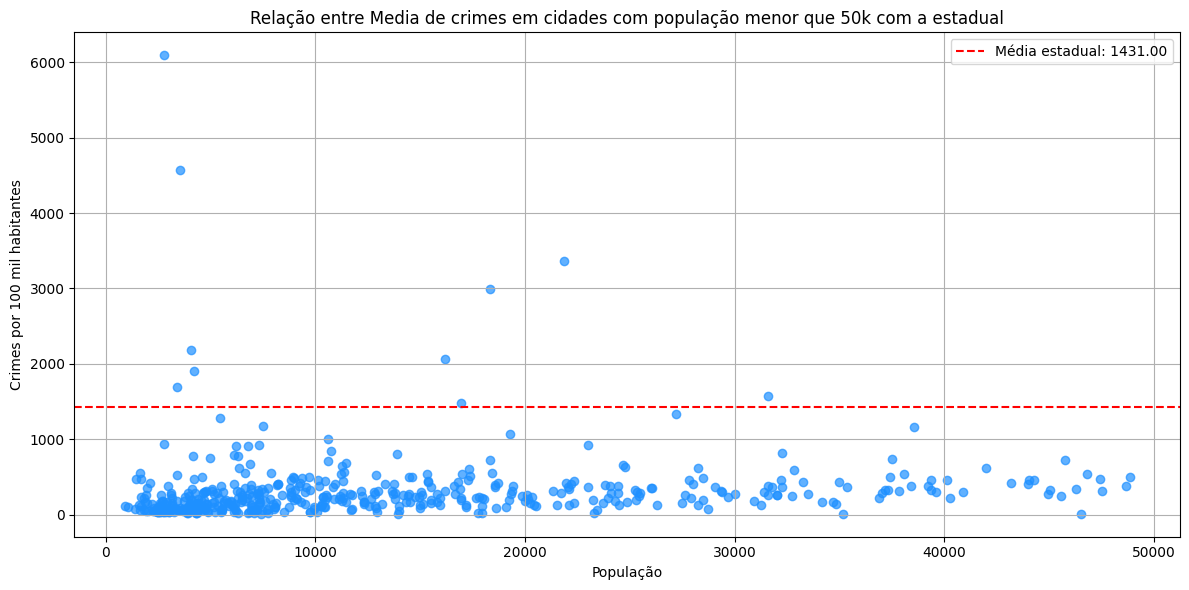

In [ ]:

# Tamanho do gráfico
plt.figure(figsize=(12, 6))

# Scatter plot
plt.scatter(df_cidades_filtrado["QUANTIDADE_POPULACAO"], df_cidades_filtrado["CRIMES_POR_100K"], color='dodgerblue', alpha=0.7)

# Linha horizontal com a média
plt.axhline(y=media_estadual, color='red', linestyle='--', label=f'Média estadual: {media_estadual:.2f}')

# Labels e título
plt.xlabel("População")
plt.ylabel("Crimes por 100 mil habitantes")
plt.title("Relação entre Media de crimes em cidades com população menor que 50k com a estadual")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<div style = "text-align: center;">
<p> Tabela com os dados do gráfico acima.</p>
</div>

In [ ]:
df_cidades_filtrado.loc[df_cidades_filtrado.CRIMES_POR_100K > 1431]

,CIDADE,QUANTIDADE_CRIMES,QUANTIDADE_POPULACAO,CRIMES_POR_100K
71,Araçariguama,735,21856,3363.0
93,Miracatu,548,18330,2990.0
103,Guararema,497,31576,1574.0
119,São Lourenço da Serra,335,16185,2070.0
136,Juquiá,252,16954,1486.0
163,São Pedro,169,2774,6092.0
164,Itararé,162,3549,4565.0
219,Glicério,89,4084,2179.0
235,Corumbataí,80,4206,1902.0
269,Pongaí,57,3381,1686.0


<div style = "text-align: center;">
<h2> Tratamento de BO's Duplicados</h2>
<p> </p>
</div>

<div style = "text-align: left;">
<p> Definindo de quais serão considerados como BO's Duplicados, a partir de uma lista de parametros contendo as colunas (campos) que serão utilizadas para a definição de um filtro. 

Utilizar somente o campo 'NUM_BO' não é interssante,pois apenas considerando tal campo se tem uma maior probabilidade de exclusão de dados não duplicados. Já que com este pensamento não é levado em conta a possibilidade de erros de digitação ou outros possiveis erros dos quais no final resultariam na exclusão de dados não duplicados, e sim dados que precisam, somente, de um tratamento.</p>
</div>

In [25]:
param_duplicados = ['NUM_BO','NATUREZA_APURADA' ,'CODIGO_BOLETIM', 'LOCAL_ELABORACAO','TIPO_LOCAL']

# Identifica duplicatas (mantendo o primeiro como "não duplicado")
duplicados = df.duplicated(subset=param_duplicados, keep='first')

# Exibe os duplicados
df_duplicados = df[duplicados]
df_duplicados

,NUM_BO,ANO_BO,CODIGO_BOLETIM,NATUREZA_APURADA,DATA_OCORRENCIA,DIA_SEMANA,HORA_OCORRENCIA,PERIODO_OCORRENCIA,CIDADE,LOGRADOURO,NUMERO_LOGRADOURO,BAIRRO,UF,TIPO_LOCAL,LATITUDE,LONGITUDE,DELEGACIA_ELABORACAO,DEPARTAMENTO_ELABORACAO,SECCIONAL_ELABORACAO,DELEGACIA_CIRCUNSCRICAO,DEPARTAMENTO_CIRCUNSCRICAO,SECCIONAL_CIRCUNSCRICAO,TIPO_PESSOA,SEXO_PESSOA,IDADE_PESSOA,DATA_NASCIMENTO_PESSOA,COR_PELE,PROFISSAO,PLACA_VEICULO,UF_VEICULO,CIDADE_VEICULO,COR_VEICULO,MARCA_VEICULO,MODELO_VEICULO,ANO_FABRICACAO,ANO_MODELO,TIPO_VEICULO,MARCA_CELULAR,QUANT_CELULAR,BO_INICIADO,BO_EMITIDO,DATA_HORA_ELABORACAO,DATA_COMUNICACAO,BO_AUTORIA,FLAGRANTE,EXAME,SOLUCAO,ESPECIE,STATUS,FLAG_VITIMA_FATAL,DESDOBRAMENTO,DIA ATIPICO,LOCAL_ELABORACAO,INCIDENTES_ID
12,239.0,2022,239/2022,HOMICIDIO DOLOSO,2022-01-15,SÁBADO,02:10:00,DE MADRUGADA,NaN,RUA EURICO DE AZEVEDO MARQUES,100.0,NaN,NaN,VIA PUBLICA,-23.639734,-46.749698,89º D.P. JARDIM TABOAO,DECAP,DEL.SEC.3º OESTE,037 DP - CAMPO LIMPO,DECAP,3ª SEC,VITIMA,MASCULINO,22.0,1999-06-02,PARDA,AUXILIAR GERAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-15 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NÃO,89º D.P. JARDIM TABOAO,24610
106,57.0,2022,57/2022,HOMICIDIO DOLOSO,2022-01-18,TERÇA-FEIRA,NaN,EM HORA INCERTA,NaN,DA VEDACAO DA DIVULGACAO DOS DADOS RELATIVOS,NaN,NaN,NaN,RESIDENCIA,NaN,NaN,02ª DDM CAMPINAS,DEINTER 2 - CAMPINAS,DEL.SEC.2º CAMPINAS,009 DP - CAMPINAS,DEINTER 2,2ª SECCIONAL CAMPINAS,VITIMA,FEMININO,34.0,1987-10-27,BRANCA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-18 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NÃO,02ª DDM CAMPINAS,28166
107,57.0,2022,57/2022,HOMICIDIO DOLOSO,2022-01-18,TERÇA-FEIRA,NaN,EM HORA INCERTA,NaN,DA VEDACAO DA DIVULGACAO DOS DADOS RELATIVOS,NaN,NaN,NaN,RESIDENCIA,NaN,NaN,02ª DDM CAMPINAS,DEINTER 2 - CAMPINAS,DEL.SEC.2º CAMPINAS,009 DP - CAMPINAS,DEINTER 2,2ª SECCIONAL CAMPINAS,VITIMA,FEMININO,3.0,2018-11-13,BRANCA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-18 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NÃO,02ª DDM CAMPINAS,28166
121,689.0,2022,689/2022,HOMICIDIO DOLOSO,2022-01-31,SEGUNDA-FEIRA,18:00:00,A TARDE,NaN,DA VEDACAO DA DIVULGACAO DOS DADOS RELATIVOS,NaN,NaN,NaN,RESIDENCIA,NaN,NaN,DEL.SEC.BARRETOS PLANTAO,DEINTER 3 - RIBEIRAO PRETO,DEL.SEC.BARRETOS,002 DP - BARRETOS,DEINTER 3,SEC BARRETOS,VITIMA,MASCULINO,50.0,1972-01-07,BRANCA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NÃO,DEL.SEC.BARRETOS PLANTAO,43824
122,689.0,2022,689/2022,HOMICIDIO DOLOSO,2022-01-31,SEGUNDA-FEIRA,18:00:00,A TARDE,NaN,DA VEDACAO DA DIVULGACAO DOS DADOS RELATIVOS,NaN,NaN,NaN,RESIDENCIA,NaN,NaN,DEL.SEC.BARRETOS PLANTAO,DEINTER 3 - RIBEIRAO PRETO,DEL.SEC.BARRETOS,002 DP - BARRETOS,DEINTER 3,SEC BARRETOS,VITIMA,MASCULINO,47.0,1974-05-09,BRANCA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NÃO,DEL.SEC.BARRETOS PLANTAO,43824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720438,4216.0,2022,4216/2022,ROUBO (ART. 157) - VEICULO,2022-12-29,QUINTA-FEIRA,19:13:00,A NOITE,NaN,NaN,0.0,JARDIM SAO CAETANO,SP,RESIDENCIA,NaN,NaN,DEL.POL.S.CAETANO DO SUL,NaN,NaN,03º D.P. S.CAETANO DO SUL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,2022-12-29 23:07:45,2022-12-29 23:07:45,2022-12-29 23:07:45,2022-12-29,DESCONHECIDA,NAO,NaN,ENCAMINHAMENTO DP AREA DO FATO,TITULO II - PATRIMONIO (ARTS. 155 A 183),CONSUMADO,NaN,NaN,NÃO,DEL.POL.S.CAETANO DO SUL,444294
720439,4216.0,2022,4216/2022,ROUBO (ART. 157) - VEICULO,2022-12-29,QUINTA-FEIRA,19:13:00,A NOITE,NaN,NaN,0.0,JARDIM SAO CAETANO,SP,RESIDENCIA,NaN,NaN,DEL.POL.S.CAETANO DO SUL,NaN,NaN,03º D.P. S.CAETANO DO SUL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FBP0B01,SP,3548807,BRANCO,I,BMW 320I PG51,201

<div style = "text-align: center;">
<h3> Remoção dos dados duplicados do Dataframe:</h3>
</div>

In [26]:
# Remove os duplicados do DataFrame original
df_sem_duplicados = df[~duplicados]
df = df[~duplicados]
df

,NUM_BO,ANO_BO,CODIGO_BOLETIM,NATUREZA_APURADA,DATA_OCORRENCIA,DIA_SEMANA,HORA_OCORRENCIA,PERIODO_OCORRENCIA,CIDADE,LOGRADOURO,NUMERO_LOGRADOURO,BAIRRO,UF,TIPO_LOCAL,LATITUDE,LONGITUDE,DELEGACIA_ELABORACAO,DEPARTAMENTO_ELABORACAO,SECCIONAL_ELABORACAO,DELEGACIA_CIRCUNSCRICAO,DEPARTAMENTO_CIRCUNSCRICAO,SECCIONAL_CIRCUNSCRICAO,TIPO_PESSOA,SEXO_PESSOA,IDADE_PESSOA,DATA_NASCIMENTO_PESSOA,COR_PELE,PROFISSAO,PLACA_VEICULO,UF_VEICULO,CIDADE_VEICULO,COR_VEICULO,MARCA_VEICULO,MODELO_VEICULO,ANO_FABRICACAO,ANO_MODELO,TIPO_VEICULO,MARCA_CELULAR,QUANT_CELULAR,BO_INICIADO,BO_EMITIDO,DATA_HORA_ELABORACAO,DATA_COMUNICACAO,BO_AUTORIA,FLAGRANTE,EXAME,SOLUCAO,ESPECIE,STATUS,FLAG_VITIMA_FATAL,DESDOBRAMENTO,DIA ATIPICO,LOCAL_ELABORACAO,INCIDENTES_ID
0,21.0,2022,21/2022,HOMICIDIO DOLOSO,2021-12-31,SEXTA-FEIRA,15:40:00,A TARDE,NaN,DA VEDACAO DA DIVULGACAO DOS DADOS RELATIVOS,NaN,NaN,NaN,RESIDENCIA,NaN,NaN,DEL.POL.PLANTAO BIRIGUI,DEINTER 10 - ARACATUBA,DEL.SEC.ARACATUBA,DM - BIRIGUI,DEINTER 10,SEC ARACATUBA,VITIMA,FEMININO,55.0,1966-08-15,PARDA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NÃO,DEL.POL.PLANTAO BIRIGUI,6343
1,312.0,2022,312/2022,HOMICIDIO DOLOSO,2022-01-20,QUINTA-FEIRA,07:00:00,PELA MANHA,NaN,PRACA DA BANDEIRA,10.0,NaN,NaN,VIA PUBLICA,-23.550235,-46.639255,08º D.P. BRAS,DECAP,DEL.SEC.1º CENTRO,001 DP - SE,DECAP,1ª SEC,VITIMA,MASCULINO,34.0,1987-02-15,PARDA,DESEMPREGADO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-20 09:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NÃO,08º D.P. BRAS,31024
2,253.0,2022,253/2022,HOMICIDIO DOLOSO,2022-01-16,DOMINGO,05:48:00,DE MADRUGADA,NaN,RUA PRATES,536.0,NaN,NaN,VIA PUBLICA,-23.525989,-46.634852,02º D.P. BOM RETIRO,DECAP,DEL.SEC.1º CENTRO,002 DP - BOM RETIRO,DECAP,1ª SEC,VITIMA,MASCULINO,21.0,2000-06-10,PARDA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-16 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NÃO,02º D.P. BOM RETIRO,25793
3,305.0,2022,305/2022,HOMICIDIO DOLOSO,2022-01-22,SÁBADO,19:50:00,A NOITE,NaN,RUA GUARANI,427.0,NaN,NaN,VIA PUBLICA,-23.528916,-46.633914,02º D.P. BOM RETIRO,DECAP,DEL.SEC.1º CENTRO,002 DP - BOM RETIRO,DECAP,1ª SEC,VITIMA,MASCULINO,48.0,1974-01-06,PARDA,AUTONOMO(A),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NÃO,02º D.P. BOM RETIRO,32816
4,6.0,2022,6/2022,HOMICIDIO DOLOSO,2022-01-01,SÁBADO,NaN,EM HORA INCERTA,NaN,PRACA DA REPUBLICA,9.0,NaN,NaN,VIA PUBLICA,-23.542956,-46.641287,02º D.P. BOM RETIRO,DECAP,DEL.SEC.1º CENTRO,003 DP - CAMPOS ELISIOS,DECAP,1ª SEC,VITIMA,MASCULINO,NaN,NaN,PARDA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SIM,02º D.P. BOM RETIRO,7419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720433,15060.0,2022,15060/2022,ROUBO (ART. 157) - VEICULO,2022-12-28,QUARTA-FEIRA,22:00:00,A NOITE,NaN,AVENIDA COMENDADOR DANIEL PACIFICO,2.0,VILA MARTHA,SP,VIA PUBLICA,-22.321754,-49.090176,DEL.SEC.BAURU PLANTAO,NaN,NaN,01º D.P. BAURU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,2022-12-29 23:03:34,2022-12-29 23:03:34,2022-12-29 23:03:34,2022-12-29,DESCONHECIDA,NAO,NaN,APRECIACAO DO DELEGADO TITULAR,TITULO II - PATRIMONIO (ARTS. 155 A 183),CONSUMADO,NaN,NaN,NÃO,DEL.SEC.BAURU PLANTAO,443562
720435,3917.0,2022,3917/2022,ROUBO (ART. 157) - VEICULO,2022-12-29,QUINTA-FEIRA,21:05:00,A NOITE,NaN,AVENIDA EDNI RONTANI BASSEF,1320.0,AGUA BRANCA,SP,VIA PUBLICA,-22.770440,-47.631613,DEL.SEC.PIRACICABA PLANTAO,NaN,NaN,02º D.P. PIRACICABA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GBN4570,SP,3538709,VERMELHO,HONDA,CB 500X,2015.0,2015.0,MOTOCICLO,NaN,NaN,2022-12-29 23:06:09,2022-12-29 23:06:09,2022-12-29 23:06:09,2022-12-29,DESCONHECIDA,NAO,NaN,ENCAMINHAMENTO DP AREA DO FATO,TIT

<div style = "text-align: center;">
<h3> Quantidade de BO's por dia na semana</h3>
</div>

<div style = "text-align: left;">
<p> Interesse em em entender quais dias da semana, e sua proporção, acontecem maior quantidade de crimes, a partir da quantidade de BO's registrados. Assim, podendo inferir em quais dias são mais prováveis que ocorra crimes, junto de sua proproção, no estado de São Paulo.</p> 
</div>

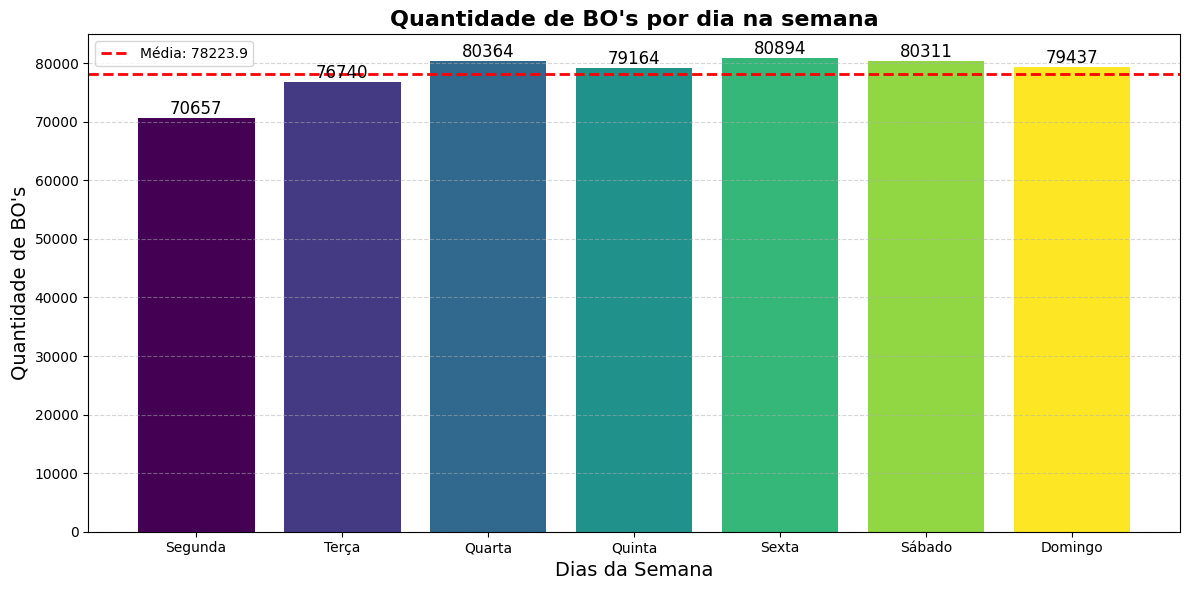

In [27]:

dias = ["Segunda", "Terça", "Quarta", "Quinta", "Sexta", "Sábado", "Domingo"]
crimes = [0] * 7
dias_semana = ["SEGUNDA-FEIRA", "TERÇA-FEIRA", "QUARTA-FEIRA", "QUINTA-FEIRA", "SEXTA-FEIRA", "SÁBADO", "DOMINGO"]

for i, dia in enumerate(dias_semana):
    crimes[i] = df.loc[
        (df['DIA_SEMANA'] == dia)
    ].shape[0]

media = sum(crimes) / len(crimes)


# Gráfico
plt.figure(figsize=(12, 6))
cores = plt.cm.viridis([i / 6 for i in range(7)])
barras = plt.bar(dias, crimes, color=cores)

plt.xlabel("Dias da Semana", fontsize=14)
plt.ylabel("Quantidade de BO's", fontsize=14)
plt.title("Quantidade de BO's por dia na semana", fontsize=16, weight='bold')

for barra in barras:
    altura = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2., altura + 0.5,
             f'{int(altura)}', ha='center', va='bottom', fontsize=12)

# Linha da média
plt.axhline(media, color='red', linestyle='--', linewidth=2, label=f'Média: {media:.1f}')
plt.text(len(dias) - 0.5, media + 0.5, f'', color='red', fontsize=12)

# Grade, legenda e layout
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

<div style = "text-align: center;">
<h3> Relação quantidades BO's com periodo do Dia</h3>
</div>

<div style = "text-align: left;">
<p> Com os dados sobre a quantidade de B.O.s registrados por dia da semana, tornou-se interessante também identificar os períodos com maior incidência de crimes, ou seja, os momentos em que há mais registros de B.O.s. Dessa forma, buscou-se correlacionar a quantidade de B.O.s com o período em que os crimes ocorreram, permitindo uma análise mais precisa dos momentos de maior criminalidade.</p>
</div>

/tmp/ipykernel_23256/137832118.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PERIODO_SIMPLIFICADO'] = df['PERIODO_OCORRENCIA'].map(periodo_mapeamento)


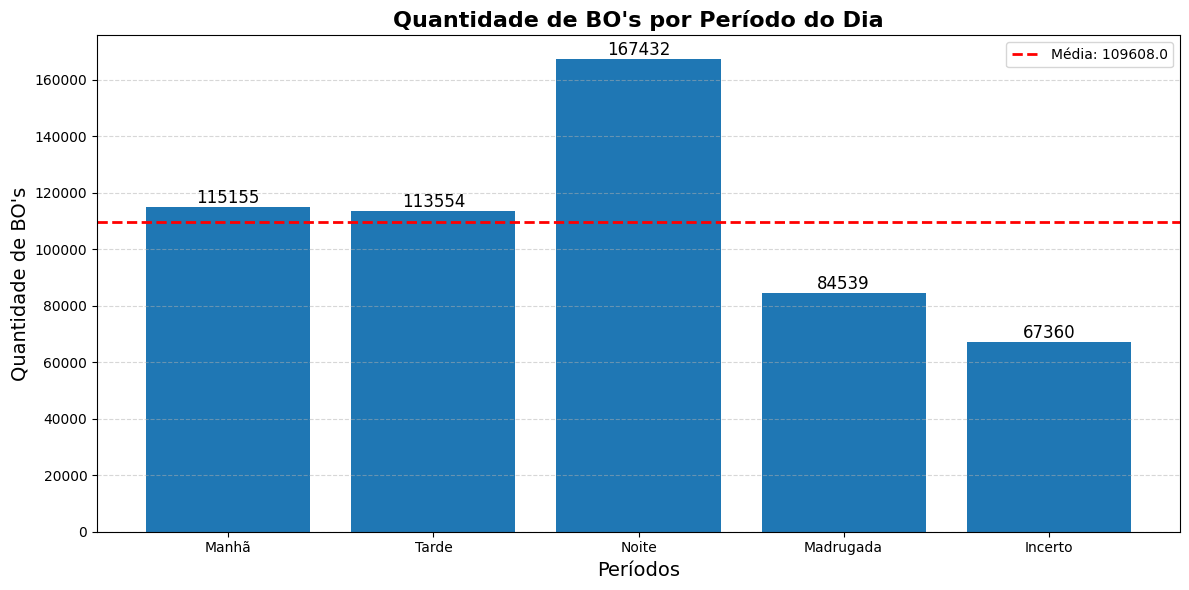

In [28]:

# Mapeamento dos períodos
periodo_mapeamento = {
    'PELA MANHA': 'Manhã',
    'A TARDE': 'Tarde',
    'A NOITE': 'Noite',
    'DE MADRUGADA': 'Madrugada',
    'EM HORA INCERTA': 'Incerto'
}

# Aplica o mapeamento para uma nova coluna
df['PERIODO_SIMPLIFICADO'] = df['PERIODO_OCORRENCIA'].map(periodo_mapeamento)

# Períodos simplificados na ordem desejada
periodos = ["Manhã", "Tarde", "Noite", "Madrugada", "Incerto"]
qnt_BO = []

# Contagem de BOs por período
for periodo in periodos:
    contagem = df[df['PERIODO_SIMPLIFICADO'] == periodo].shape[0]
    qnt_BO.append(contagem)

# Cálculo da média
media = sum(qnt_BO) / len(qnt_BO)

# Gráfico
plt.figure(figsize=(12, 6))
barras = plt.bar(periodos, qnt_BO)

# Labels e título
plt.xlabel("Períodos", fontsize=14)
plt.ylabel("Quantidade de BO's", fontsize=14)
plt.title("Quantidade de BO's por Período do Dia", fontsize=16, weight='bold')

# Adiciona os valores em cima de cada barra
for barra in barras:
    altura = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2., altura + 0.5,
             f'{int(altura)}', ha='center', va='bottom', fontsize=12)

# Linha da média
plt.axhline(media, color='red', linestyle='--', linewidth=2, label=f'Média: {media:.1f}')
plt.text(len(periodos) - 0.5, media + 1, f'', color='red', fontsize=12)

# Grade, legenda e layout
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

<div style = "text-align: center;">
<h3> Dias da semana têm maior incidência de invasões domiciliares (Pergunta 8)</h3>
</div>

<div style = "text-align: left;">
<p> Necessidade dee criar uma lista de tipos de crimes que podem ser relacionados com invasão domiciliar para que tenha se uma maior amostragem de dados que se encaxem com invasão domiciliar.

Porém, a amostragem teve uma pequena quantidade de dados, mesmo utilizando a lista de tipos de crimes. Outro ponto para observação é pelo fato de serem crimes relacionados há a possibilidade de não refletir com uma boa acurácia (ruído) a resposta da pergunta</p>
</div>

In [29]:
crimes_invasao_domiciliar = [
    'VIOLACAO DE DOMICILIO (ART. 150)',
    'FURTO (ART. 155) - RESIDENCIA',
    'FURTO QUALIFICADO (ART. 155, §4O.) - RESIDENCIA',
    'A.I.-FURTO (ART. 155) - RESIDENCIA',
    'A.I.-FURTO QUALIFICADO (ART. 155, §4O.) - RESIDENCIA',
    'FURTO DE COISA COMUM (ART. 156) - RESIDENCIA',
    'ROUBO (ART. 157) - RESIDENCIA'
]

df[df['NATUREZA_APURADA'].isin(crimes_invasao_domiciliar)]

,NUM_BO,ANO_BO,CODIGO_BOLETIM,NATUREZA_APURADA,DATA_OCORRENCIA,DIA_SEMANA,HORA_OCORRENCIA,PERIODO_OCORRENCIA,CIDADE,LOGRADOURO,NUMERO_LOGRADOURO,BAIRRO,UF,TIPO_LOCAL,LATITUDE,LONGITUDE,DELEGACIA_ELABORACAO,DEPARTAMENTO_ELABORACAO,SECCIONAL_ELABORACAO,DELEGACIA_CIRCUNSCRICAO,DEPARTAMENTO_CIRCUNSCRICAO,SECCIONAL_CIRCUNSCRICAO,TIPO_PESSOA,SEXO_PESSOA,IDADE_PESSOA,DATA_NASCIMENTO_PESSOA,COR_PELE,PROFISSAO,PLACA_VEICULO,UF_VEICULO,CIDADE_VEICULO,COR_VEICULO,MARCA_VEICULO,MODELO_VEICULO,ANO_FABRICACAO,ANO_MODELO,TIPO_VEICULO,MARCA_CELULAR,QUANT_CELULAR,BO_INICIADO,BO_EMITIDO,DATA_HORA_ELABORACAO,DATA_COMUNICACAO,BO_AUTORIA,FLAGRANTE,EXAME,SOLUCAO,ESPECIE,STATUS,FLAG_VITIMA_FATAL,DESDOBRAMENTO,DIA ATIPICO,LOCAL_ELABORACAO,INCIDENTES_ID,PERIODO_SIMPLIFICADO
29427,3.0,2022,3/2022,"FURTO QUALIFICADO (ART. 155, §4O.) - RESIDENCIA",2021-12-31,SEXTA-FEIRA,NaN,A TARDE,NaN,NaN,0.0,BOQUEIRAO NORTE,SP,RESIDENCIA,NaN,NaN,DEL.POL.ILHA COMPRIDA,NaN,NaN,DEL.POL.ILHA COMPRIDA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,MOTOROLA,3.0,2022-01-01 11:15:12,2022-01-01 11:34:24,2022-01-01 11:15:12,2022-01-01,DESCONHECIDA,NAO,NaN,BO PARA INVESTIGACAO,TITULO II - PATRIMONIO (ARTS. 155 A 183),CONSUMADO,NaN,NaN,NÃO,DEL.POL.ILHA COMPRIDA,6409,Tarde
29459,949.0,2022,949/2022,"FURTO QUALIFICADO (ART. 155, §4O.) - RESIDENCIA",2021-12-31,SEXTA-FEIRA,01:56:00,DE MADRUGADA,2513851.0,NaN,0.0,VILA CECILIA MARIA,SP,RESIDENCIA,NaN,NaN,DELEGACIA ELETRONICA,NaN,NaN,03º D.P. SANTO ANDRE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,ASUS,NaN,2022-01-01 12:45:13,2022-01-01 13:24:27,2022-01-01 12:45:13,2022-01-01,DESCONHECIDA,NAO,IC,ENCAMINHAMENTO DP AREA DO FATO,TITULO II - PATRIMONIO (ARTS. 155 A 183),CONSUMADO,NaN,NaN,NÃO,DELEGACIA ELETRONICA,6494,Madrugada
29461,13.0,2022,13/2022,"FURTO QUALIFICADO (ART. 155, §4O.) - RESIDENCIA",2022-01-01,SÁBADO,NaN,DE MADRUGADA,NaN,NaN,0.0,PQ ALTO SUMARE,SP,RESIDENCIA,NaN,NaN,DEL.SEC.BAURU PLANTAO,NaN,NaN,02º D.P. BAURU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,APPLE,1.0,2022-01-01 13:28:17,2022-01-01 13:38:46,2022-01-01 13:28:17,2022-01-01,DESCONHECIDA,NAO,NaN,BO PARA INVESTIGACAO,TITULO II - PATRIMONIO (ARTS. 155 A 183),CONSUMADO,NaN,NaN,SIM,DEL.SEC.BAURU PLANTAO,7289,Madrugada
29467,6.0,2022,6/2022,FURTO (ART. 155) - RESIDENCIA,2022-01-01,SÁBADO,10:00:00,PELA MANHA,NaN,NaN,0.0,VILA PAES,SP,RESIDENCIA,NaN,NaN,DEL.SEC.VOTUPORANGA PLANTAO,NaN,NaN,01º D.P. VOTUPORANGA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,XIAOMI,1.0,2022-01-01 13:08:17,2022-01-01 14:09:33,2022-01-01 13:08:17,2022-01-01,DESCONHECIDA,NAO,NaN,BO PARA INVESTIGACAO,TITULO II - PATRIMONIO (ARTS. 155 A 183),CONSUMADO,NaN,NaN,SIM,DEL.SEC.VOTUPORANGA PLANTAO,7764,Manhã
29479,13.0,2022,13/2022,FURTO (ART. 155) - RESIDENCIA,2022-01-01,SÁBADO,NaN,PELA MANHA,NaN,NaN,0.0,BELAS ARTES,SP,RESIDENCIA,NaN,NaN,DEL.SEC.ITANHAEM PLANTAO,NaN,NaN,02º D.P. ITANHAEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,XIAOMI,1.0,2022-01-01 14:26:12,2022-01-01 14:54:48,2022-01-01 14:26:12,2022-01-01,DESCONHECIDA,NAO,NaN,APRECIACAO DO DELEGADO TITULAR,TITULO II - PATRIMONIO (ARTS. 155 A 183),CONSUMADO,NaN,NaN,SIM,DEL.SEC.ITANHAEM PLANTAO,7750,Manhã
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714336,8300.0,2022,8300/2022,ROUBO (ART. 157) - RESIDENCIA,2022-12-17,SÁBADO,21:45:00,A NOITE,NaN,NaN,0.0,AJAPI,SP,RESIDENCIA,NaN,NaN,DEL.SEC.RIO CLARO PLANTAO,NaN,NaN,02º D.P. RIO CLARO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,2022-12-18 07:12:17,2022-12-18 07:12:17,2022-12-18 07:12:17,2022-12-18,DESCONHECIDA,NAO,NaN,APRECIACAO DO DELEGADO TITULAR,TITULO II - PATRIMONIO (ARTS. 155 A 183),CONSUMADO,NaN,NaN,NÃO,DEL.SEC.RIO CLARO PLANTAO,431026,Noite
714401,8301.0,2022,8301/2022,ROUBO (A

<div style = "text-align: center;">
<h3> Geração do Gráfico</h3>
</div>

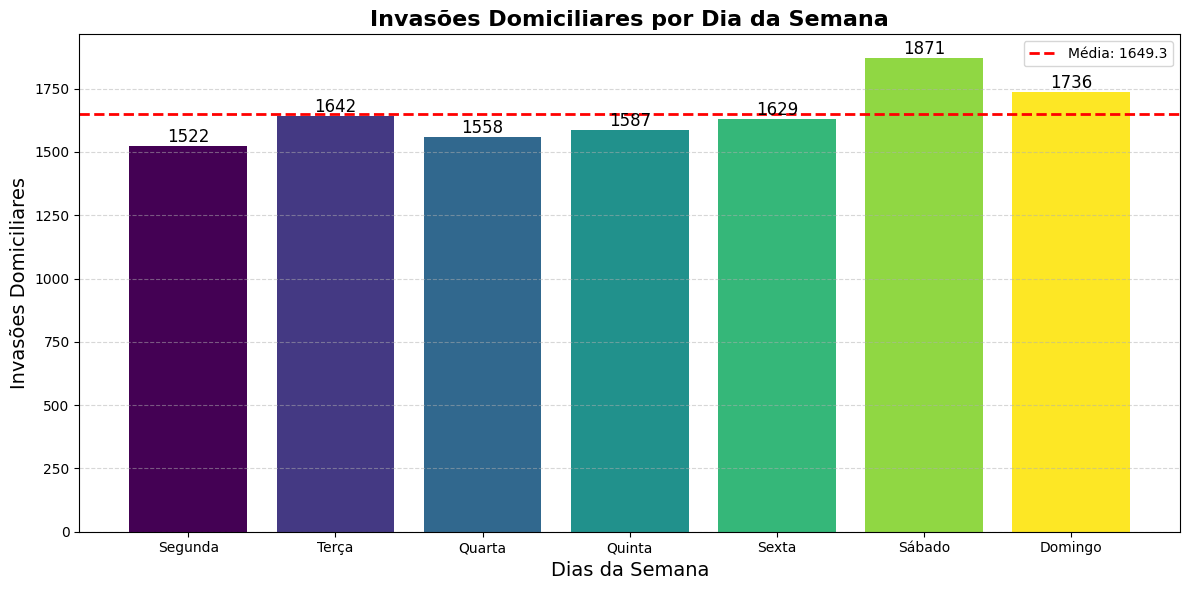

In [30]:

# Dados
dias = ["Segunda", "Terça", "Quarta", "Quinta", "Sexta", "Sábado", "Domingo"]
invasoes = [0] * 7
dias_semana = ["SEGUNDA-FEIRA", "TERÇA-FEIRA", "QUARTA-FEIRA", "QUINTA-FEIRA", "SEXTA-FEIRA", "SÁBADO", "DOMINGO"]

for i, dia in enumerate(dias_semana):
    invasoes[i] = df.loc[
        (df['DIA_SEMANA'] == dia) & (df['NATUREZA_APURADA'].isin(crimes_invasao_domiciliar))
    ].shape[0]

# Cálculo da média
media = sum(invasoes) / len(invasoes)


# Gráfico
plt.figure(figsize=(12, 6))
cores = plt.cm.viridis([i / 6 for i in range(7)])
barras = plt.bar(dias, invasoes, color=cores)

# Labels e título
plt.xlabel("Dias da Semana", fontsize=14)
plt.ylabel("Invasões Domiciliares", fontsize=14)
plt.title("Invasões Domiciliares por Dia da Semana", fontsize=16, weight='bold')

# Adiciona os valores em cima de cada barra
for barra in barras:
    altura = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2., altura + 0.5,
             f'{int(altura)}', ha='center', va='bottom', fontsize=12)

# Linha da média
plt.axhline(media, color='red', linestyle='--', linewidth=2, label=f'Média: {media:.1f}')
plt.text(len(dias) - 0.5, media + 0.5, f'', color='red', fontsize=12)

# Grade, legenda e layout
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

Fatores Sociodemográficos
Análise: COR DA PELE X CRIME COMETIDO
* Existe alguma correlação entre esses dois fatores?

*Análise feita por: Matheus Kauan*

Nessa análise, serão gerados alguns gráficos para melhor entendimento, mas antees é necessário realizar algumas filtragens e análise dos dados do dataframe

Filtragem do dataframe para seleção de crimes que estão relacionados a violência física/verbal:

In [31]:
crimes_violencia_fisica_verbal = [
    'LESAO CORPORAL (ART. 129)',
    'LESAO CORPORAL CULPOSA NA DIRECAO DE VEICULO AUTOMOTOR (ART. 303)',
    'LESAO CORPORAL SEGUIDA DE MORTE',
    'AMEACA (ART. 147)',
    'INJURIA (ART. 140)',
    'CALUNIA (ART. 138)',
    'DESACATO (ART. 331)',
    'RESISTENCIA (ART. 329)',
    'VIOLENCIA DOMESTICA',
    'HOMICIDIO DOLOSO',
    'LATROCINIO',
    'MORTE DECORRENTE DE INTERVENCAO POLICIAL'
]

Criando um novo dataframe com a filtragem:

In [32]:
df_violencia_f_v = df[df['NATUREZA_APURADA'].isin(crimes_violencia_fisica_verbal)].copy()

In [33]:
#Quantidade de crimes por natureza
print(df_violencia_f_v['NATUREZA_APURADA'].value_counts())

NATUREZA_APURADA
HOMICIDIO DOLOSO                                                     2890
LESAO CORPORAL (ART. 129)                                            1200
AMEACA (ART. 147)                                                     719
VIOLENCIA DOMESTICA                                                   712
MORTE DECORRENTE DE INTERVENCAO POLICIAL                              381
INJURIA (ART. 140)                                                    266
RESISTENCIA (ART. 329)                                                218
LATROCINIO                                                            177
LESAO CORPORAL CULPOSA NA DIRECAO DE VEICULO AUTOMOTOR (ART. 303)     172
LESAO CORPORAL SEGUIDA DE MORTE                                        92
CALUNIA (ART. 138)                                                     21
DESACATO (ART. 331)                                                    20
Name: count, dtype: int64


In [34]:
# Filtrar apenas os registros onde 'COR_PELE' não é nulo
df_violencia_f_v = df_violencia_f_v[df_violencia_f_v['COR_PELE'].notna()]

In [35]:
print(df_violencia_f_v['COR_PELE'].value_counts())

COR_PELE
BRANCA      1610
PARDA       1540
PRETA        295
AMARELA        9
VERMELHA       2
OUTROS         1
Name: count, dtype: int64


Verificando a porcentagem de dados que são nulos da coluna 'COR_PELE' em relação ao total de linhas (dados):

In [36]:
# Número de valores NaN na coluna
num_nan = df['COR_PELE'].isna().sum()

# Número total de linhas
total_linhas = len(df)

# Porcentagem de NaN
porcentagem_nan = (num_nan / total_linhas) * 100

print(f'Porcentagem de NaN em COR_PELE: {porcentagem_nan:.2f}%')

Porcentagem de NaN em COR_PELE: 96.56%


Confirmando a veracidade da porcentagem acima:

In [37]:
# Filtrar onde COR_PELE é nulo
cor_pele_nulo = df[df['COR_PELE'].isna()]

# Mostrar o dataframe filtrado
df[df['COR_PELE'].isna()]

,NUM_BO,ANO_BO,CODIGO_BOLETIM,NATUREZA_APURADA,DATA_OCORRENCIA,DIA_SEMANA,HORA_OCORRENCIA,PERIODO_OCORRENCIA,CIDADE,LOGRADOURO,NUMERO_LOGRADOURO,BAIRRO,UF,TIPO_LOCAL,LATITUDE,LONGITUDE,DELEGACIA_ELABORACAO,DEPARTAMENTO_ELABORACAO,SECCIONAL_ELABORACAO,DELEGACIA_CIRCUNSCRICAO,DEPARTAMENTO_CIRCUNSCRICAO,SECCIONAL_CIRCUNSCRICAO,TIPO_PESSOA,SEXO_PESSOA,IDADE_PESSOA,DATA_NASCIMENTO_PESSOA,COR_PELE,PROFISSAO,PLACA_VEICULO,UF_VEICULO,CIDADE_VEICULO,COR_VEICULO,MARCA_VEICULO,MODELO_VEICULO,ANO_FABRICACAO,ANO_MODELO,TIPO_VEICULO,MARCA_CELULAR,QUANT_CELULAR,BO_INICIADO,BO_EMITIDO,DATA_HORA_ELABORACAO,DATA_COMUNICACAO,BO_AUTORIA,FLAGRANTE,EXAME,SOLUCAO,ESPECIE,STATUS,FLAG_VITIMA_FATAL,DESDOBRAMENTO,DIA ATIPICO,LOCAL_ELABORACAO,INCIDENTES_ID,PERIODO_SIMPLIFICADO
6,125.0,2022,125/2022,HOMICIDIO DOLOSO,2022-01-09,DOMINGO,19:11:00,A NOITE,NaN,RUA DOUTOR COSTA VALENTE,100.0,NaN,NaN,VIA PUBLICA,NaN,NaN,08º D.P. BRAS,DECAP,DEL.SEC.1º CENTRO,008 DP - BRAS,DECAP,1ª SEC,VITIMA,MASCULINO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-09 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NÃO,08º D.P. BRAS,15873,Noite
31,219.0,2022,219/2022,HOMICIDIO DOLOSO,2022-01-16,DOMINGO,17:56:00,A TARDE,NaN,PRACA VINTE DE JANEIRO,71.0,NaN,NaN,VIA PUBLICA,-23.553943,-46.568637,31º D.P. VILA CARRAO,DECAP,DEL.SEC.5º LESTE,030 DP - TATUAPE,DECAP,5ª SEC,VITIMA,MASCULINO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-16 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NÃO,31º D.P. VILA CARRAO,25514,Tarde
42,67.0,2022,67/2022,HOMICIDIO DOLOSO,2022-01-03,SEGUNDA-FEIRA,16:15:00,A TARDE,NaN,TRAVESSA VERA CRUZ,1.0,NaN,NaN,VIA PUBLICA,-23.687070,-46.769279,47º D.P. CAPAO REDONDO,DECAP,DEL.SEC.6º SANTO AMARO,100 DP - JARDIM HERCULANO,DECAP,6ª SEC,VITIMA,MASCULINO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-03 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NÃO,47º D.P. CAPAO REDONDO,9584,Tarde
101,407.0,2022,407/2022,HOMICIDIO DOLOSO,2022-01-18,TERÇA-FEIRA,NaN,EM HORA INCERTA,NaN,RUA ANTONIO TEODORO DE CASTRO,1.0,NaN,NaN,VIA PUBLICA,-22.844257,-47.113497,PLANTAO - 01 DP CAMPINAS,DEINTER 2 - CAMPINAS,DEL.SEC.1º CAMPINAS,007 DP - CAMPINAS,DEINTER 2,1ª SECCIONAL CAMPINAS,VITIMA,MASCULINO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-18 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NÃO,PLANTAO - 01 DP CAMPINAS,28197,Incerto
148,24.0,2022,24/2022,HOMICIDIO DOLOSO,2022-01-26,QUARTA-FEIRA,11:20:00,PELA MANHA,NaN,ESTRADA DA AIROCA,1.0,NaN,NaN,UNIDADE RURAL,-21.234976,-49.639459,DEL.POL.ADOLFO,DEINTER 5 - SAO JOSE DO RIO PRETO,DEL.SEC.S.JOSE DO RIO PRETO,DM - ADOLFO,DEINTER 5,SEC SAO JOSE RIO PRETO,VITIMA,INDEFINIDO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-26 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NÃO,DEL.POL.ADOLFO,38520,Manhã
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720433,15060.0,2022,15060/2022,ROUBO (ART. 157) - VEICULO,2022-12-28,QUARTA-FEIRA,22:00:00,A NOITE,NaN,AVENIDA COMENDADOR DANIEL PACIFICO,2.0,VILA MARTHA,SP,VIA PUBLICA,-22.321754,-49.090176,DEL.SEC.BAURU PLANTAO,NaN,NaN,01º D.P. BAURU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,2022-12-29 23:03:34,2022-12-29 23:03:34,2022-12-29 23:03:34,2022-12-29,DESCONHECIDA,NAO,NaN,APRECIACAO DO DELEGADO TITULAR,TITULO II - PATRIMONIO (ARTS. 155 A 183),CONSUMADO,NaN,NaN,NÃO,DEL.SEC.BAURU PLANTAO,443562,Noite
720435,3917.0,2022,3917/2022,ROUBO (ART. 157) - VEICULO,2022-12-29,QUINTA-FEIRA,21:05:00,A NOITE,NaN,AVENIDA EDNI RONTANI BASSEF,1320.0,AGUA BRANCA,SP,VIA PUBLICA,-22.770440,-47.631613,DEL.SEC.PIRACICABA PLANTAO,NaN,NaN,02º D.P. PIRACICABA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GBN4570,SP,3538709,VERMELHO,HONDA,CB 500X,2015.0,2015.0,MOTOCICLO,NaN,NaN,2022-12-29 23:06:09,2022-12-29

In [38]:
# Mostrar a quantidade de linhas
print(f'Total de linhas com COR_PELE nulo: {len(cor_pele_nulo)}')

Total de linhas com COR_PELE nulo: 529165


In [39]:
# Filtrar onde COR_PELE não é nulo
cor_pele_preenchido = df[df['COR_PELE'].notna()]

# Mostrar o dataframe filtrado
df[df['COR_PELE'].notna()]

,NUM_BO,ANO_BO,CODIGO_BOLETIM,NATUREZA_APURADA,DATA_OCORRENCIA,DIA_SEMANA,HORA_OCORRENCIA,PERIODO_OCORRENCIA,CIDADE,LOGRADOURO,NUMERO_LOGRADOURO,BAIRRO,UF,TIPO_LOCAL,LATITUDE,LONGITUDE,DELEGACIA_ELABORACAO,DEPARTAMENTO_ELABORACAO,SECCIONAL_ELABORACAO,DELEGACIA_CIRCUNSCRICAO,DEPARTAMENTO_CIRCUNSCRICAO,SECCIONAL_CIRCUNSCRICAO,TIPO_PESSOA,SEXO_PESSOA,IDADE_PESSOA,DATA_NASCIMENTO_PESSOA,COR_PELE,PROFISSAO,PLACA_VEICULO,UF_VEICULO,CIDADE_VEICULO,COR_VEICULO,MARCA_VEICULO,MODELO_VEICULO,ANO_FABRICACAO,ANO_MODELO,TIPO_VEICULO,MARCA_CELULAR,QUANT_CELULAR,BO_INICIADO,BO_EMITIDO,DATA_HORA_ELABORACAO,DATA_COMUNICACAO,BO_AUTORIA,FLAGRANTE,EXAME,SOLUCAO,ESPECIE,STATUS,FLAG_VITIMA_FATAL,DESDOBRAMENTO,DIA ATIPICO,LOCAL_ELABORACAO,INCIDENTES_ID,PERIODO_SIMPLIFICADO
0,21.0,2022,21/2022,HOMICIDIO DOLOSO,2021-12-31,SEXTA-FEIRA,15:40:00,A TARDE,NaN,DA VEDACAO DA DIVULGACAO DOS DADOS RELATIVOS,NaN,NaN,NaN,RESIDENCIA,NaN,NaN,DEL.POL.PLANTAO BIRIGUI,DEINTER 10 - ARACATUBA,DEL.SEC.ARACATUBA,DM - BIRIGUI,DEINTER 10,SEC ARACATUBA,VITIMA,FEMININO,55.0,1966-08-15,PARDA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NÃO,DEL.POL.PLANTAO BIRIGUI,6343,Tarde
1,312.0,2022,312/2022,HOMICIDIO DOLOSO,2022-01-20,QUINTA-FEIRA,07:00:00,PELA MANHA,NaN,PRACA DA BANDEIRA,10.0,NaN,NaN,VIA PUBLICA,-23.550235,-46.639255,08º D.P. BRAS,DECAP,DEL.SEC.1º CENTRO,001 DP - SE,DECAP,1ª SEC,VITIMA,MASCULINO,34.0,1987-02-15,PARDA,DESEMPREGADO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-20 09:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NÃO,08º D.P. BRAS,31024,Manhã
2,253.0,2022,253/2022,HOMICIDIO DOLOSO,2022-01-16,DOMINGO,05:48:00,DE MADRUGADA,NaN,RUA PRATES,536.0,NaN,NaN,VIA PUBLICA,-23.525989,-46.634852,02º D.P. BOM RETIRO,DECAP,DEL.SEC.1º CENTRO,002 DP - BOM RETIRO,DECAP,1ª SEC,VITIMA,MASCULINO,21.0,2000-06-10,PARDA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-16 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NÃO,02º D.P. BOM RETIRO,25793,Madrugada
3,305.0,2022,305/2022,HOMICIDIO DOLOSO,2022-01-22,SÁBADO,19:50:00,A NOITE,NaN,RUA GUARANI,427.0,NaN,NaN,VIA PUBLICA,-23.528916,-46.633914,02º D.P. BOM RETIRO,DECAP,DEL.SEC.1º CENTRO,002 DP - BOM RETIRO,DECAP,1ª SEC,VITIMA,MASCULINO,48.0,1974-01-06,PARDA,AUTONOMO(A),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NÃO,02º D.P. BOM RETIRO,32816,Noite
4,6.0,2022,6/2022,HOMICIDIO DOLOSO,2022-01-01,SÁBADO,NaN,EM HORA INCERTA,NaN,PRACA DA REPUBLICA,9.0,NaN,NaN,VIA PUBLICA,-23.542956,-46.641287,02º D.P. BOM RETIRO,DECAP,DEL.SEC.1º CENTRO,003 DP - CAMPOS ELISIOS,DECAP,1ª SEC,VITIMA,MASCULINO,NaN,NaN,PARDA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SIM,02º D.P. BOM RETIRO,7419,Incerto
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677542,15.0,2022,15/2022,HOMICIDIO SIMPLES (ART. 121),2022-01-16,DOMINGO,00:01:00,DE MADRUGADA,NaN,AVENIDA MARGINAL DO RIO PINHEIROS,12.0,MORUMBI,SP,VIA PUBLICA,-23.597675,-46.697231,DHPP DIV. HOMICIDIOS,NaN,NaN,34º D.P. MORUMBI,NaN,NaN,AUTOR/VITIMA,MASCULINO,NaN,NaN,PARDA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,2022-01-16 05:10:05,2022-01-16 08:37:29,2022-01-16 05:10:05,2022-01-16,CONHECIDA,NAO,IC-IML,BO PARA INQUERITO,TITULO I - PESSOA (ARTS. 121 A 154),CONSUMADO,SIM,MORTE DECORRENTE DE INTERVENCAO POLICIAL (RES....,NÃO,DHPP DIV. HOMICIDIOS,25674,Madrugada
679127,150.0,2022,150/2022,"LEGITIMA DEFESA (ART. 23, II)",2022-01-22,SÁBADO,NaN,A TARDE,2513851.0,RUA JOSE LINS DO REGO,365.0,VILA VALPARAISO,SP,VIA PUBLICA,-23.663827,-46.544694,CPJ SANTO ANDRE,NaN,NaN,01º D.P. SANTO ANDRE,NaN,NaN,AUTOR/VITIMA,MASCULINO,NaN,NaN,BRANCA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,2022-01-22 15:04:05,2022-01-22 20:44:18,2022-0

In [40]:
# Mostrar a quantidade de linhas
print(f'Total de linhas com COR_PELE preenchido: {len(cor_pele_preenchido)}')

Total de linhas com COR_PELE preenchido: 18875


Aqui encontramos um grande problema: mais de 97% dos dados estão nulos na coluna COR_PELE. Assim, os gráficos serão gerados com base em apenas 3% dos registros que possuem informações sobre a cor da pele da vítima, o que representa um obstáculo para a veracidade e a representatividade das informações que podem ser extraídas dos gráficos a priori.

Criação de um gráfico de barras:

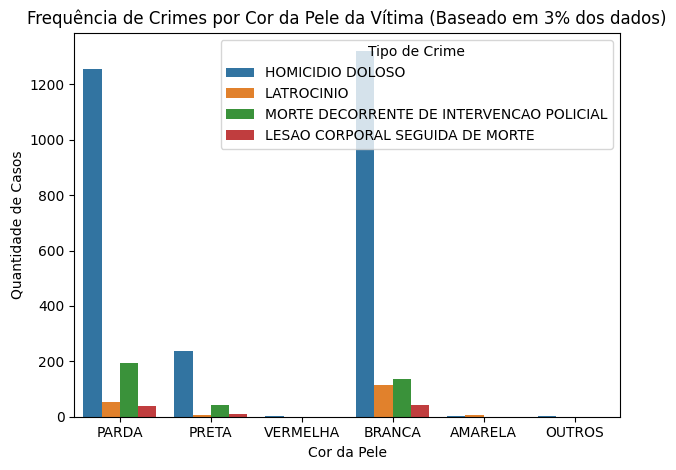

In [41]:
sns.countplot(data=df_violencia_f_v, x='COR_PELE', hue='NATUREZA_APURADA')
plt.title('Frequência de Crimes por Cor da Pele da Vítima (Baseado em 3% dos dados)')
plt.xlabel('Cor da Pele')
plt.ylabel('Quantidade de Casos')
plt.legend(title='Tipo de Crime')
plt.tight_layout()
plt.show()

In [42]:
# Listar crimes únicos onde COR_PELE não é nulo
crimes_unicos = df_violencia_f_v['NATUREZA_APURADA'].unique()

print(crimes_unicos)

['HOMICIDIO DOLOSO' 'LATROCINIO'
 'MORTE DECORRENTE DE INTERVENCAO POLICIAL'
 'LESAO CORPORAL SEGUIDA DE MORTE']


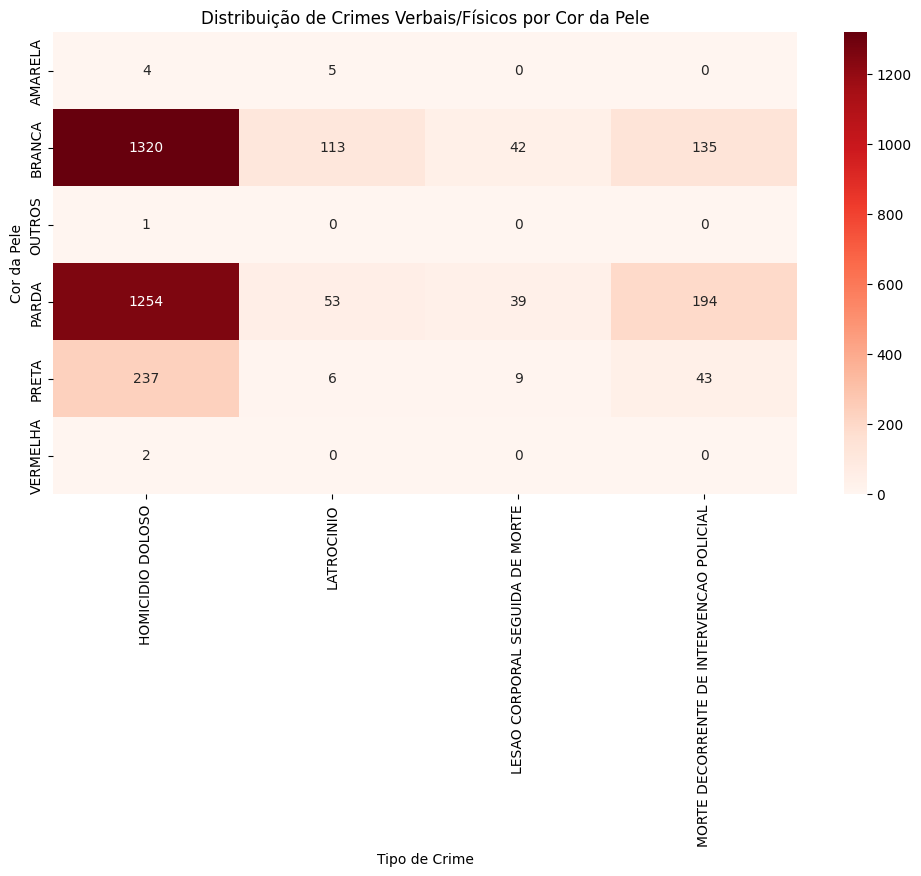

In [43]:
#Gerando um HeatMap para visualizar a relação entre COR_PELE e NATUREZA_APURADA

pivot = df_violencia_f_v.pivot_table(index='COR_PELE', columns='NATUREZA_APURADA', aggfunc='size', fill_value=0)
plt.figure(figsize=(12, 6))
sns.heatmap(pivot, annot=True, fmt='d', cmap='Reds')
plt.title('Distribuição de Crimes Verbais/Físicos por Cor da Pele')
plt.xlabel('Tipo de Crime')
plt.ylabel('Cor da Pele')
plt.show()

<div style="text-align: center;">
  <h2>Explorando os dados: datas dos BOs</h2>
  <p>Para entender a natureza dos dias dos acontecimentos e a correlação com datas específicas, cruzaremos os dados de datas atípicas e datas dos crimes. Para realizar esta anlise mais apurada, dividimos os dados em "Natal", "Carnaval", "Demais Feriados", "Jogos de futebol" e "Dias comuns".</p>
</div>

In [44]:
#Definir as categorias baseadas na sua lista eventos_sp_2022
carnaval = ['2022-02-28', '2022-03-01', '2022-03-02']  # Carnaval + Quarta de Cinzas
natal = ['2022-12-24', '2022-12-25', '2022-12-31']     # Natal + Vésperas

outros_feriados = [
    '2022-01-01', '2022-04-15', '2022-04-21', '2022-05-01',
    '2022-06-16', '2022-07-09', '2022-09-07', '2022-10-12',
    '2022-10-28', '2022-11-02', '2022-11-15'
]

jogos_futebol = [
    '2022-01-25', '2022-03-10', '2022-03-30', '2022-04-03',
    '2022-05-02', '2022-05-22', '2022-06-20', '2022-08-21',
    '2022-09-11', '2022-10-16', '2022-11-24', '2022-11-28',
    '2022-12-02', '2022-12-05', '2022-12-09'
]

# Função de categorização (ajustada para lidar com strings e datetime)
def categorizar_evento(data):
    if pd.isna(data):  # Tratar valores nulos
        return 'DIA NORMAL'
    
    data_str = data.strftime('%Y-%m-%d') if hasattr(data, 'strftime') else str(data)[:10]  # Adapta para datetime ou string
    if data_str in carnaval:
        return 'CARNAVAL'
    elif data_str in natal:
        return 'NATAL'
    elif data_str in outros_feriados:
        return 'OUTROS FERIADOS'
    elif data_str in jogos_futebol:
        return 'JOGOS FUTEBOL'
    else:
        return 'DIA NORMAL'

# Aplicar a categorização
df['DATA_OCORRENCIA'] = pd.to_datetime(df['DATA_OCORRENCIA'], errors='coerce')  # Garante datetime e trata erros
df['CATEGORIA_EVENTO'] = df['DATA_OCORRENCIA'].apply(categorizar_evento)

# Verificar contagem
print(df['CATEGORIA_EVENTO'].value_counts())

/tmp/ipykernel_23256/3105248595.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DATA_OCORRENCIA'] = pd.to_datetime(df['DATA_OCORRENCIA'], errors='coerce')  # Garante datetime e trata erros


CATEGORIA_EVENTO
DIA NORMAL         502638
JOGOS FUTEBOL       23496
OUTROS FERIADOS     15914
CARNAVAL             3844
NATAL                2148
Name: count, dtype: int64


/tmp/ipykernel_23256/3105248595.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CATEGORIA_EVENTO'] = df['DATA_OCORRENCIA'].apply(categorizar_evento)


<div style = "text-align: center;">
<p>Agora, vamos comparar a média diária de crimes para cada categoria:</p>
</div>

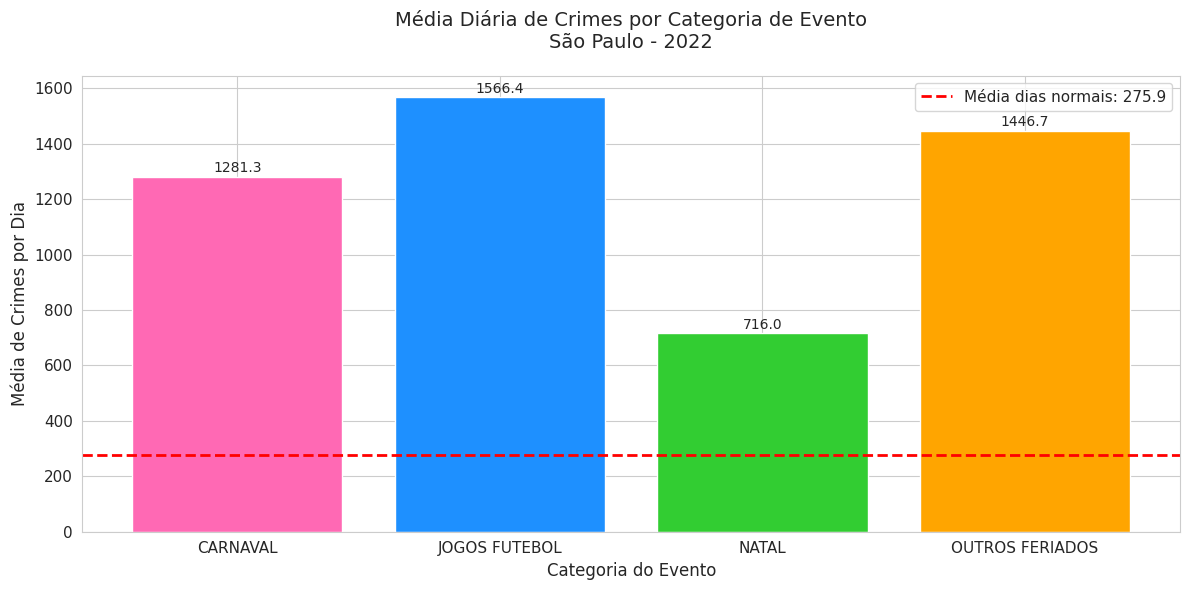

In [45]:
# Calcular dias únicos por categoria
dias_por_categoria = {
    'CARNAVAL': len(carnaval),
    'NATAL': len(natal),
    'OUTROS FERIADOS': len(outros_feriados),
    'JOGOS FUTEBOL': len(jogos_futebol),
    'DIA NORMAL': len(df['DATA_OCORRENCIA'].dt.date.unique()) - (len(carnaval) + len(natal) + len(outros_feriados) + len(jogos_futebol))
}

# Calcular média diária
crimes_por_categoria = df.groupby('CATEGORIA_EVENTO').size().reset_index(name='TOTAL_CRIMES')
crimes_por_categoria['MEDIA_DIARIA'] = crimes_por_categoria['TOTAL_CRIMES'] / crimes_por_categoria['CATEGORIA_EVENTO'].map(dias_por_categoria)

# Filtrar apenas eventos (excluindo dias normais)
crimes_analise = crimes_por_categoria[crimes_por_categoria['CATEGORIA_EVENTO'] != 'DIA NORMAL']

# Configurações de estilo (opcional)
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

# Cores temáticas para cada categoria
colors = {
    'CARNAVAL': '#FF69B4',  # Rosa
    'NATAL': '#32CD32',     # Verde
    'OUTROS FERIADOS': '#FFA500',  # Laranja
    'JOGOS FUTEBOL': '#1E90FF'     # Azul
}

# Criar o gráfico de barras
bars = plt.bar(
    crimes_analise['CATEGORIA_EVENTO'], 
    crimes_analise['MEDIA_DIARIA'],
    color=[colors[cat] for cat in crimes_analise['CATEGORIA_EVENTO']]
)

# Linha de referência (média diária normal)
media_normal = crimes_por_categoria.loc[crimes_por_categoria['CATEGORIA_EVENTO'] == 'DIA NORMAL', 'MEDIA_DIARIA'].values[0]
plt.axhline(
    media_normal, 
    color='red', 
    linestyle='--', 
    linewidth=2,
    label=f'Média dias normais: {media_normal:.1f}'
)

# Detalhes do gráfico
plt.title('Média Diária de Crimes por Categoria de Evento\nSão Paulo - 2022', fontsize=14, pad=20)
plt.xlabel('Categoria do Evento', fontsize=12)
plt.ylabel('Média de Crimes por Dia', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(fontsize=11)

# Adicionar valores nas barras
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2, 
        height + 5,  # Offset para posicionar acima da barra
        f'{height:.1f}', 
        ha='center', 
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()

<div style = "text-align: center;">
<p>Para uma visão mais detalhada, podemos plotar a quantidade de crimes ao longo do ano, destacando os dias atípicos:</p>
</div>

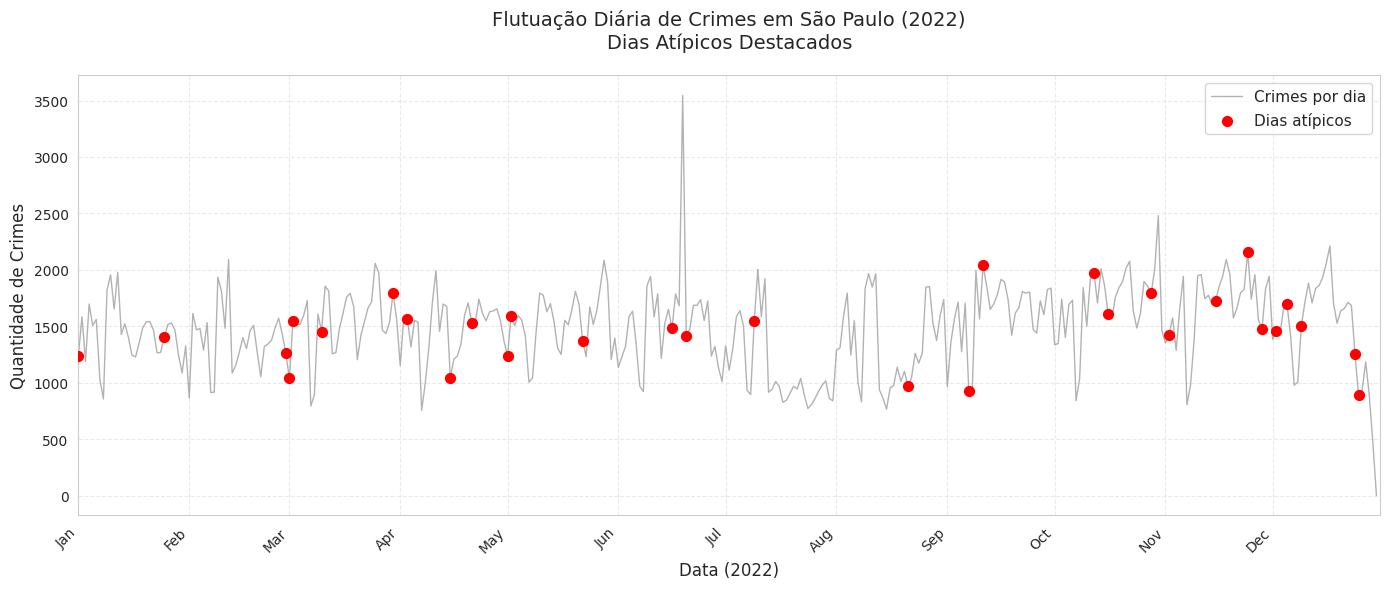

In [46]:

# Agrupar crimes por data
crimes_por_data = df.groupby('DATA_OCORRENCIA').size().reset_index(name='TOTAL_CRIMES')

# Identificar dias atípicos no DataFrame
crimes_por_data['DIA_ATIPICO'] = crimes_por_data['DATA_OCORRENCIA'].isin(eventos_dates)

# Configurar o gráfico
plt.figure(figsize=(14, 6))

# Gráfico de linha principal
plt.plot(crimes_por_data['DATA_OCORRENCIA'], 
         crimes_por_data['TOTAL_CRIMES'], 
         label='Crimes por dia', 
         color='gray', 
         alpha=0.6,
         linewidth=1)

# Destacar dias atípicos
dias_atipicos = crimes_por_data[crimes_por_data['DIA_ATIPICO'] == True]
plt.scatter(dias_atipicos['DATA_OCORRENCIA'], 
            dias_atipicos['TOTAL_CRIMES'], 
            color='red', 
            label='Dias atípicos', 
            zorder=5,
            s=50)  # tamanho dos pontos

# Configurar limites do eixo x para 2022
plt.xlim([pd.to_datetime('2022-01-01'), pd.to_datetime('2022-12-31')])

# Formatar eixo x para mostrar meses
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Nomes curtos dos meses

# Adicionar detalhes
plt.xlabel('Data (2022)', fontsize=12)
plt.ylabel('Quantidade de Crimes', fontsize=12)
plt.title('Flutuação Diária de Crimes em São Paulo (2022)\nDias Atípicos Destacados', fontsize=14, pad=20)
plt.legend(fontsize=11)
plt.grid(linestyle='--', alpha=0.4)

# Melhorar a legibilidade das datas
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<div style="text-align: center;">
  <h2>BOs Iniciados X BOs Emitidos</h2>
  <p>Para entender se todos os boletins de ocorrência de fato são emitidos, ou pelo menos uma boa parte, cruzaremos os dados de BO_EMITIDOS e BO_INICIADOS. Tambêm observaremos para quais naturezas de crimes os boletins são mais efeivado e para quais são menos efetivados.</p>
</div>

In [47]:
#Verificando os tipos de crimes:

if 'NATUREZA_APURADA' in df.columns:
    valores_unicos = df['NATUREZA_APURADA'].dropna().unique()
    print(f"Total de tipos únicos: {len(valores_unicos)}\n")
    print("Exemplos de tipos de natureza apurada:")
    for valor in sorted(valores_unicos)[:50]:  # Mostra os 50 primeiros para não ficar gigante
        print(f"- {valor}")
else:
    print("A coluna 'NATUREZA_APURADA' não foi encontrada no dataset.")

Total de tipos únicos: 318

Exemplos de tipos de natureza apurada:
- 88-PRATICAR, INDUZIR OU INCITAR DISCRIMINACAO DE PESSOA EM RAZAO DE SUA DEFIC
- A.I. LESAO CORPORAL (ART. 129 §12)
- A.I.-ADULTERACAO DE SINAL IDENTIFICADOR DE VEICULO AUTOMOTOR (ART. 311)
- A.I.-AMEACA (ART. 147)
- A.I.-ART 2º - PROMOVER, CONSTITUIR, FINANCIAR OU INTEGRAR ORGANIZACAO CRIMINOSA
- A.I.-ATO OBSCENO (ART.233)
- A.I.-CAPUT CORROMPER OU FACILITAR A CORRUPCAO DE MENOR DE 18 ANOS (244B)
- A.I.-CONSTRANGIMENTO ILEGAL (ART. 146)
- A.I.-DANO (ART. 163)
- A.I.-DESACATO (ART. 331)
- A.I.-DESOBEDIENCIA (ART. 330)
- A.I.-DIRECAO PERIGOSA DE VEICULO NA VIA PUBLICA (ART. 34)
- A.I.-DIRIGIR SEM PERMISSAO OU HABILITACAO (ART. 309)
- A.I.-DROGAS PARA CONSUMO PESSOAL SEM AUTORIZACAO OU EM DESACORDO (ART.28,CAPUT)
- A.I.-DROGAS SEM AUTORIZACAO OU EM DESACORDO (ART.33, CAPUT)
- A.I.-ESTELIONATO (ART. 171)
- A.I.-ESTUPRO (ART.213)
- A.I.-EXTORSAO (ART. 158)
- A.I.-EXTORSAO (ART. 158) - PESSOA
- A.I.-EXTORSAO MEDIANTE SEQÜES

In [48]:
# 1. Identificar os 6 tipos mais comuns
top_6_crimes = df['NATUREZA_APURADA'].value_counts().head(6).index.tolist()

# 2. Função de categorização
def categorizar_crime(natureza):
    natureza = str(natureza).upper()
    
    # Verificar os 6 tipos mais comuns
    for crime in top_6_crimes:
        if str(crime).upper() in natureza:
            return crime.split('-')[-1].split('(')[0].strip()
    
    # Categorias específicas
    if 'FURTO' in natureza:
        return 'FURTO'
    elif 'ROUBO' in natureza:
        return 'ROUBO'
    elif 'HOMICÍDIO' in natureza or 'HOMICIDIO' in natureza:
        return 'HOMICÍDIO'
    elif 'LESÃO' in natureza or 'LESAO' in natureza:
        return 'LESÃO CORPORAL'
    elif 'ESTELIONATO' in natureza:
        return 'ESTELIONATO'
    elif 'TRÁFICO' in natureza or 'TRAFICO' in natureza:
        return 'TRÁFICO DE DROGAS'
    else:
        return 'OUTROS'

# 3. Aplicar categorização e calcular status
df['CATEGORIA_CRIME'] = df['NATUREZA_APURADA'].apply(categorizar_crime)
df['STATUS_EMISSAO'] = df['BO_EMITIDO'].apply(lambda x: 'Emitido' if pd.notnull(x) else 'Não Emitido')

# 4. Calcular estatísticas por categoria
emissoes_por_categoria = df.groupby('CATEGORIA_CRIME').agg(
    Total_Iniciados=('STATUS_EMISSAO', 'count'),
    Total_Emitidos=('STATUS_EMISSAO', lambda x: (x == 'Emitido').sum())
).reset_index()

emissoes_por_categoria['Perc_Emitidos'] = (emissoes_por_categoria['Total_Emitidos'] / 
                                          emissoes_por_categoria['Total_Iniciados']) * 100

# Ordenar por porcentagem de emissão
emissoes_por_categoria = emissoes_por_categoria.sort_values('Perc_Emitidos', ascending=False)

/tmp/ipykernel_23256/2218307133.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CATEGORIA_CRIME'] = df['NATUREZA_APURADA'].apply(categorizar_crime)
/tmp/ipykernel_23256/2218307133.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['STATUS_EMISSAO'] = df['BO_EMITIDO'].apply(lambda x: 'Emitido' if pd.notnull(x) else 'Não Emitido')


/tmp/ipykernel_23256/3508827961.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_23256/3508827961.py:9: UserWarning: 
The palette list has fewer values (7) than needed (9) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(


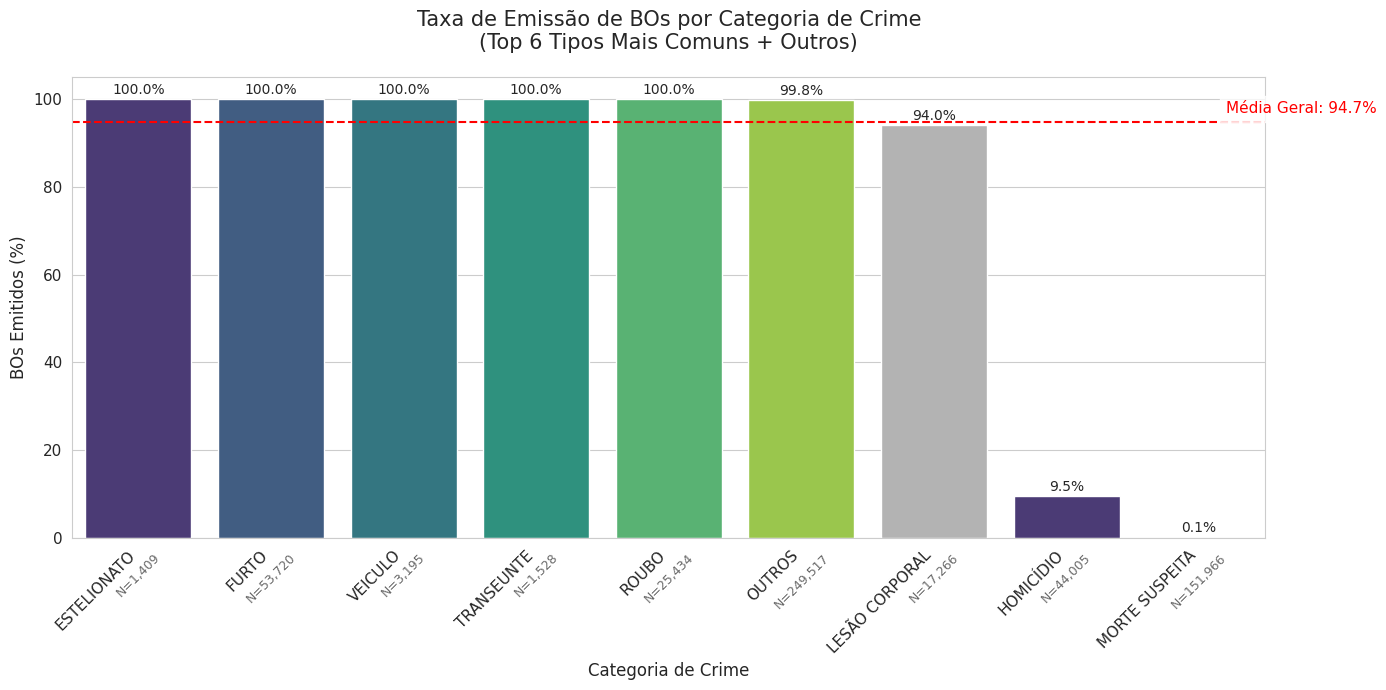

In [49]:
# Criar gráfico de barras
plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")

# Paleta de cores - usando as 6 cores principais + cinza para "OUTROS"
cores = sns.color_palette("viridis", n_colors=6) + [(0.7, 0.7, 0.7)]
cores = cores[:len(emissoes_por_categoria)]  # Ajustar para o número real de categorias

ax = sns.barplot(
    data=emissoes_por_categoria,
    x='CATEGORIA_CRIME',
    y='Perc_Emitidos',
    palette=cores,
    order=emissoes_por_categoria['CATEGORIA_CRIME']  # Manter a ordenação
)

# Adicionar rótulos de porcentagem
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 0.5,
            f'{height:.1f}%',
            ha='center',
            va='bottom',
            fontsize=10)

# Linha de média geral
media_geral = (df['STATUS_EMISSAO'] == 'Emitido').mean() * 100
ax.axhline(media_geral, color='red', linestyle='--', linewidth=1.5)
ax.text(len(emissoes_por_categoria)-0.8, media_geral+2, 
        f'Média Geral: {media_geral:.1f}%', 
        color='red',
        fontsize=11,
        bbox=dict(facecolor='white', alpha=0.8))

# Adicionar volume de ocorrências
for i, row in emissoes_por_categoria.iterrows():
    ax.text(i, -3, 
            f"N={row['Total_Iniciados']:,}", 
            ha='center', 
            va='top', 
            rotation=45, 
            fontsize=9,
            color='dimgrey')

# Configurações do gráfico
plt.title('Taxa de Emissão de BOs por Categoria de Crime\n(Top 6 Tipos Mais Comuns + Outros)', 
          fontsize=15, pad=20)
plt.xlabel('Categoria de Crime', fontsize=12)
plt.ylabel('BOs Emitidos (%)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=11)
plt.ylim(0, 105)  # Espaço extra para os rótulos

# Ajustar layout
plt.tight_layout()
plt.show()

<div style="text-align: center;">
  <h2>Explorando os dados: Tipologia viária</h2>
  <p>Em quais vias acontecem maior número de crimes? Visando verificar se os dados nos respondem esta pergunta, observaremos aqui a correlação entre o número de crimes e os locais onde aconteceram. Para isso, vamos dividir os dados de LOGRADOURO em: Rua, Avenida, nulo, Rodovia e outros que consite em: Estrada, Praça, Alameda e Travessa; e após isso srá possivel verificar onde mais acontecem crimes</p>
</div>

In [50]:
# Função para classificar o tipo de logradouro
def classificar_logradouro(log):
    if pd.isna(log):
        return 'NULO'
    log = log.strip().lower()
    if log.startswith('rua'):
        return 'Rua'
    elif log.startswith('avenida') or log.startswith('av.'):
        return 'Avenida'
    elif any(log.startswith(tipo) for tipo in ['praça', 'praca', 'travessa', 'trv.', 'estrada', 'alameda']):
        return 'OUTROS'
    elif log.startswith('rodovia'):
        return 'Rodovia'
    else:
        return 'OUTROS'

# Aplica classificação
df['TIPO_LOGRADOURO'] = df['LOGRADOURO'].apply(classificar_logradouro)

# Contagem por tipo
contagem_logradouros = df['TIPO_LOGRADOURO'].value_counts().reset_index()
contagem_logradouros.columns = ['Tipo de Logradouro', 'Quantidade']

/tmp/ipykernel_23256/954741542.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TIPO_LOGRADOURO'] = df['LOGRADOURO'].apply(classificar_logradouro)


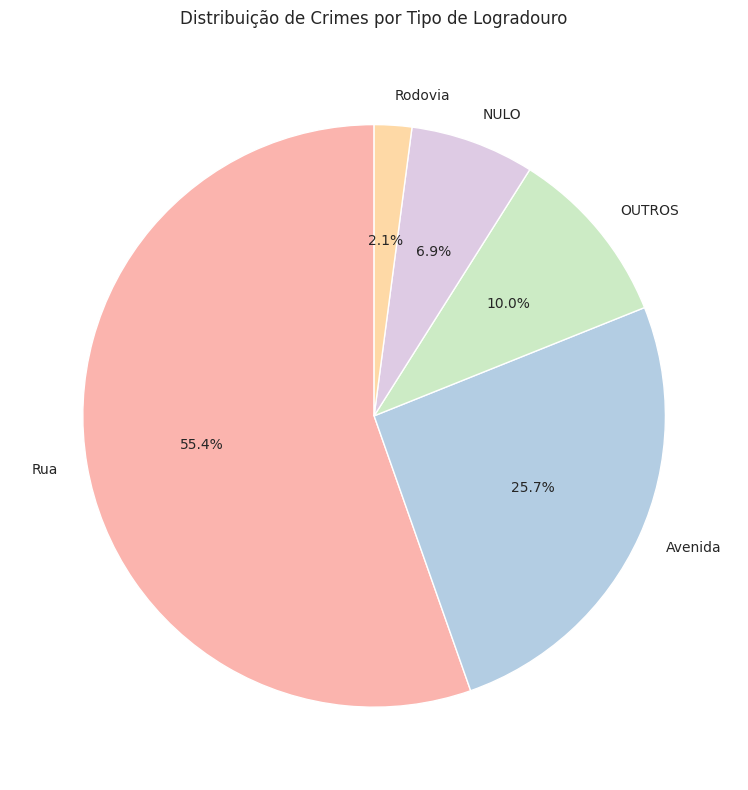

In [51]:

# Criar gráfico de pizza simples
plt.figure(figsize=(8, 8))
plt.pie(contagem_logradouros['Quantidade'],
        labels=contagem_logradouros['Tipo de Logradouro'],
        autopct='%1.1f%%',
        startangle=90,
        colors=plt.cm.Pastel1.colors,
        wedgeprops={'linewidth': 1, 'edgecolor': 'white'})

# Adicionar título
plt.title('Distribuição de Crimes por Tipo de Logradouro', pad=20)

# Mostrar o gráfico
plt.tight_layout()
plt.show()

<div style="text-align: center;">
    <h1> Inferências </h1>
    <p> Agora usaremos tecnicas de inferência para encontrar validação de hipoteses que nos ajudaria a melhor entender os dados </p>
</div>

<div style="text-align: center;">
  <h2>Associações</h2>
  <p>Abaixo exploraremos algumas associações para que possamos interpretar melhor os dados, e encontrar alguns padrões que posso ajudar a entendê-los </p>
</div>

Pensando em regras de associação, irá ser feita uma análise de que turno do dia um crime é realizado em um determinado, com base na natureza apurada, turno e local. (Matheus Kauan)

In [52]:
# Calcula a porcentagem de valores não nulos
porcentagem_nao_nulos = df['NATUREZA_APURADA'].notna().mean() * 100

# Exibe a porcentagem
print(f"{porcentagem_nao_nulos:.2f}% dos dados de NATUREZA_APURADA não são nulos.")

100.00% dos dados de NATUREZA_APURADA não são nulos.


In [53]:
# Calcula a porcentagem de valores não nulos
porcentagem_nao_nulos = df['TIPO_LOCAL'].notna().mean() * 100

# Exibe a porcentagem
print(f"{porcentagem_nao_nulos:.2f}% dos dados de TIPO_LOCAL não são nulos.")

100.00% dos dados de TIPO_LOCAL não são nulos.


In [54]:
# Calcula a porcentagem de valores não nulos
porcentagem_nao_nulos = df['PERIODO_OCORRENCIA'].notna().mean() * 100

# Exibe a porcentagem
print(f"{porcentagem_nao_nulos:.2f}% dos dados de PERIODO_OCORRENCIA não são nulos.")

100.00% dos dados de PERIODO_OCORRENCIA não são nulos.


Após as verificações, podemos realizar as análises visto que maior parte dos dados possuem todos os atributos necessários

In [55]:
# Seleciona e faz uma cópia explícita das colunas
df_assoc = df[['NATUREZA_APURADA', 'TIPO_LOCAL', 'PERIODO_OCORRENCIA']].copy()

# Agora é seguro remover os nulos sem warnings
df_assoc.dropna(inplace=True)


In [56]:
# Instala automaticamente o mlxtend, se não estiver instalado
try:
    from mlxtend.preprocessing import TransactionEncoder
    from mlxtend.frequent_patterns import apriori, association_rules
except ImportError:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "mlxtend"])
    from mlxtend.preprocessing import TransactionEncoder
    from mlxtend.frequent_patterns import apriori, association_rules


In [57]:
df_assoc['itens'] = df_assoc.apply(lambda row: [
    f"NATUREZA={row['NATUREZA_APURADA']}",
    f"LOCAL={row['TIPO_LOCAL']}",
    f"PERIODO={row['PERIODO_OCORRENCIA']}"
], axis=1)

In [58]:

te = TransactionEncoder()
te_ary = te.fit(df_assoc['itens']).transform(df_assoc['itens'])
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)
df_encoded

,LOCAL=AREA NAO OCUPADA,LOCAL=CENTRO COMERC./EMPRESARIAL,LOCAL=COMERCIO E SERVICOS,LOCAL=CONDOMINIO COMERCIAL,LOCAL=CONDOMINIO RESIDENCIAL,LOCAL=ENTIDADE ASSISTENCIAL,LOCAL=ESCRITORIO,LOCAL=ESTABELECIMENTO BANCARIO,LOCAL=ESTABELECIMENTO COMERCIAL,LOCAL=ESTABELECIMENTO DE ENSINO,LOCAL=ESTABELECIMENTO INDUSTRIAL,LOCAL=ESTABELECIMENTO PRISIONAL,LOCAL=ESTACIONAMENTO COM VIGILANCIA,LOCAL=ESTACIONAMENTO PARTICULAR,LOCAL=ESTACIONAMENTO PUBLICO,LOCAL=ESTRADA DE FERRO,LOCAL=FAVELA,LOCAL=GARAGEM COLETIVA DE PREDIO,LOCAL=GARAGEM OU ABRIGO DE RESIDENCIA,LOCAL=HOSPEDAGEM,LOCAL=INTERNET,LOCAL=LAZER E RECREACAO,LOCAL=LOCAL CLANDESTINO/ILEGAL,LOCAL=OUTROS,LOCAL=REPARTICAO PUBLICA,LOCAL=RESIDENCIA,LOCAL=RESTAURANTE E AFINS,LOCAL=RODOVIA/ESTRADA,LOCAL=SAUDE,LOCAL=SERVICOS E BENS PUBLICOS,LOCAL=SHOPPING CENTER,LOCAL=SINDICATO,LOCAL=TEMPLO E AFINS,LOCAL=TERMINAL/ESTACAO,LOCAL=UNIDADE RURAL,LOCAL=VEICULO EM MOVIMENTO,LOCAL=VIA PUBLICA,"NATUREZA=88-PRATICAR, INDUZIR OU INCITAR DISCRIMINACAO DE PESSOA EM RAZAO DE SUA DEFIC",NATUREZA=A.I. LESAO CORPORAL (ART. 129 §12),NATUREZA=A.I.-ADULTERACAO DE SINAL IDENTIFICADOR DE VEICULO AUTOMOTOR (ART. 311),NATUREZA=A.I.-AMEACA (ART. 147),"NATUREZA=A.I.-ART 2º - PROMOVER, CONSTITUIR, FINANCIAR OU INTEGRAR ORGANIZACAO CRIMINOSA",NATUREZA=A.I.-ATO OBSCENO (ART.233),NATUREZA=A.I.-CAPUT CORROMPER OU FACILITAR A CORRUPCAO DE MENOR DE 18 ANOS (244B),NATUREZA=A.I.-CONSTRANGIMENTO ILEGAL (ART. 146),NATUREZA=A.I.-DANO (ART. 163),NATUREZA=A.I.-DESACATO (ART. 331),NATUREZA=A.I.-DESOBEDIENCIA (ART. 330),NATUREZA=A.I.-DIRECAO PERIGOSA DE VEICULO NA VIA PUBLICA (ART. 34),NATUREZA=A.I.-DIRIGIR SEM PERMISSAO OU HABILITACAO (ART. 309),"NATUREZA=A.I.-DROGAS PARA CONSUMO PESSOAL SEM AUTORIZACAO OU EM DESACORDO (ART.28,CAPUT)","NATUREZA=A.I.-DROGAS SEM AUTORIZACAO OU EM DESACORDO (ART.33, CAPUT)",NATUREZA=A.I.-ESTELIONATO (ART. 171),NATUREZA=A.I.-ESTUPRO (ART.213),NATUREZA=A.I.-EXTORSAO (ART. 158),NATUREZA=A.I.-EXTORSAO (ART. 158) - PESSOA,NATUREZA=A.I.-EXTORSAO MEDIANTE SEQÜESTRO (ART. 159),NATUREZA=A.I.-FALSA IDENTIDADE (ART. 307),NATUREZA=A.I.-FURTO (ART. 155) - APLICATIVO DE MOBILIDADE URBANA,NATUREZA=A.I.-FURTO (ART. 155) - CARGA,NATUREZA=A.I.-FURTO (ART. 155) - CONDOMINIO RESIDENCIAL,NATUREZA=A.I.-FURTO (ART. 155) - ESTABELECIMENTO COMERCIAL,NATUREZA=A.I.-FURTO (ART. 155) - ESTABELECIMENTO ENSINO,NATUREZA=A.I.-FURTO (ART. 155) - ESTABELECIMENTO-OUTROS,NATUREZA=A.I.-FURTO (ART. 155) - INTERIOR DE VEICULO,NATUREZA=A.I.-FURTO (ART. 155) - INTERIOR ESTABELECIMENTO,NATUREZA=A.I.-FURTO (ART. 155) - OUTROS,NATUREZA=A.I.-FURTO (ART. 155) - RESIDENCIA,NATUREZA=A.I.-FURTO (ART. 155) - TRANSEUNTE,NATUREZA=A.I.-FURTO (ART. 155) - VEICULO,NATUREZA=A.I.-FURTO DE COISA COMUM (ART. 156) - OUTROS,NATUREZA=A.I.-FURTO DE COISA COMUM (ART. 156) - VEICULO,"NATUREZA=A.I.-FURTO QUALIFICADO (ART. 155, §4O.) - ESTABELECIMENTO COMERCIAL","NATUREZA=A.I.-FURTO QUALIFICADO (ART. 155, §4O.) - INTERIOR ESTABELECIMENTO","NATUREZA=A.I.-FURTO QUALIFICADO (ART. 155, §4O.) - OUTROS","NATUREZA=A.I.-FURTO QUALIFICADO (ART. 155, §4O.) - RESIDENCIA","NATUREZA=A.I.-FURTO QUALIFICADO (ART. 155, §4O.) - TRANSEUNTE","NATUREZA=A.I.-FURTO QUALIFICADO (ART. 155, §4O.) - VEICULO",NATUREZA=A.I.-HOMICIDIO CULPOSO NA DIRECAO DE VEICULO AUTOMOTOR (ART. 302),"NATUREZA=A.I.-HOMICIDIO QUALIFICADO (ART. 121, §2O.)",NATUREZA=A.I.-HOMICIDIO SIMPLES (ART. 121),"NATUREZA=A.I.-INCENDIO (ART. 250, CAPUT)",NATUREZA=A.I.-INJURIA (ART. 140),"NATUREZA=A.I.-INJURIA REAL (ART. 140, §2O.)",NATUREZA=A.I.-LESAO CORPORAL CULPOSA NA DIRECAO DE VEICULO AUTOMOTOR (ART. 303),NATUREZA=A.I.-MOEDA FALSA (ART. 289),NATUREZA=A.I.-OUTRAS FRAUDES (ART. 176),NATUREZA=A.I.-PORTE DE ARMA (ART. 19),NATUREZA=A.I.-PORTE ILEGAL DE ARMA DE FOGO DE USO PERMITIDO (ART. 14),NATUREZA=A.I.-POSSE IRREGULAR DE ARMA DE FOGO DE USO PERMITIDO (ART.12),NATUREZA=A.I.-POSSE OU PORTE ILEGAL DE ARMA DE FOGO DE USO RESTRITO (ART. 16),NATUREZA=A.I.-QUADRILHA OU BANDO (ART. 288),NATUREZA=A.I.-RECEPTACAO (ART. 180) - CARGA,NATUREZA

In [59]:
# Gera itemsets frequentes com suporte mínimo de 1%
freq_items = apriori(df_encoded, min_support=0.01, use_colnames=True)

# Gera regras com confiança mínima de 60%
regras = association_rules(freq_items, metric="confidence")

# Exibe as 10 primeiras
regras[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

,antecedents,consequents,support,confidence,lift
0,(LOCAL=OUTROS),(NATUREZA=FURTO (ART. 155) - OUTROS),0.038485,0.810538,3.755577
1,(LOCAL=SAUDE),(NATUREZA=MORTE SUSPEITA),0.019205,0.880532,18.973088
2,(NATUREZA=FURTO (ART. 155) - INTERIOR DE VEICULO),(LOCAL=VIA PUBLICA),0.017012,0.907613,1.235489
3,(NATUREZA=FURTO (ART. 155) - VEICULO),(LOCAL=VIA PUBLICA),0.150914,0.837266,1.139729
4,(NATUREZA=LOCALIZACAO/APREENSAO E ENTREGA DE V...,(LOCAL=VIA PUBLICA),0.026872,0.852948,1.161076
5,(NATUREZA=ROUBO (ART. 157) - OUTROS),(LOCAL=VIA PUBLICA),0.154662,0.913864,1.243998
6,(NATUREZA=ROUBO (ART. 157) - TRANSEUNTE),(LOCAL=VIA PUBLICA),0.074826,0.937817,1.276604
7,(NATUREZA=ROUBO (ART. 157) - VEICULO),(LOCAL=VIA PUBLICA),0.080010,0.849438,1.156298
8,"(PERIODO=EM HORA INCERTA, LOCAL=OUTROS)",(NATUREZA=FURTO (ART. 155) - OUTROS),0.021705,0.985420,4.565882
9,"(LOCAL=TERMINAL/ESTACAO, PERIODO=EM HORA INCERTA)",(NATUREZA=FURTO (ART. 155) - OUTROS),0.011448,0.949312,4.398578


In [60]:
regras.shape[0]

25

In [61]:
df_assoc

,NATUREZA_APURADA,TIPO_LOCAL,PERIODO_OCORRENCIA,itens
0,HOMICIDIO DOLOSO,RESIDENCIA,A TARDE,"[NATUREZA=HOMICIDIO DOLOSO, LOCAL=RESIDENCIA, ..."
1,HOMICIDIO DOLOSO,VIA PUBLICA,PELA MANHA,"[NATUREZA=HOMICIDIO DOLOSO, LOCAL=VIA PUBLICA,..."
2,HOMICIDIO DOLOSO,VIA PUBLICA,DE MADRUGADA,"[NATUREZA=HOMICIDIO DOLOSO, LOCAL=VIA PUBLICA,..."
3,HOMICIDIO DOLOSO,VIA PUBLICA,A NOITE,"[NATUREZA=HOMICIDIO DOLOSO, LOCAL=VIA PUBLICA,..."
4,HOMICIDIO DOLOSO,VIA PUBLICA,EM HORA INCERTA,"[NATUREZA=HOMICIDIO DOLOSO, LOCAL=VIA PUBLICA,..."
...,...,...,...,...
720433,ROUBO (ART. 157) - VEICULO,VIA PUBLICA,A NOITE,"[NATUREZA=ROUBO (ART. 157) - VEICULO, LOCAL=VI..."
720435,ROUBO (ART. 157) - VEICULO,VIA PUBLICA,A NOITE,"[NATUREZA=ROUBO (ART. 157) - VEICULO, LOCAL=VI..."
720440,ROUBO (ART. 157) - VEICULO,VIA PUBLICA,A NOITE,"[NATUREZA=ROUBO (ART. 157) - VEICULO, LOCAL=VI..."
720441,LOCALIZACAO/APREENSAO DE VEICULO,VIA PUBLICA,DE MADRUGADA,"[NATUREZA=LOCALIZACAO/APREENSAO DE VEICULO, LO..."


In [62]:
df.head(5)


,NUM_BO,ANO_BO,CODIGO_BOLETIM,NATUREZA_APURADA,DATA_OCORRENCIA,DIA_SEMANA,HORA_OCORRENCIA,PERIODO_OCORRENCIA,CIDADE,LOGRADOURO,NUMERO_LOGRADOURO,BAIRRO,UF,TIPO_LOCAL,LATITUDE,LONGITUDE,DELEGACIA_ELABORACAO,DEPARTAMENTO_ELABORACAO,SECCIONAL_ELABORACAO,DELEGACIA_CIRCUNSCRICAO,DEPARTAMENTO_CIRCUNSCRICAO,SECCIONAL_CIRCUNSCRICAO,TIPO_PESSOA,SEXO_PESSOA,IDADE_PESSOA,DATA_NASCIMENTO_PESSOA,COR_PELE,PROFISSAO,PLACA_VEICULO,UF_VEICULO,CIDADE_VEICULO,COR_VEICULO,MARCA_VEICULO,MODELO_VEICULO,ANO_FABRICACAO,ANO_MODELO,TIPO_VEICULO,MARCA_CELULAR,QUANT_CELULAR,BO_INICIADO,BO_EMITIDO,DATA_HORA_ELABORACAO,DATA_COMUNICACAO,BO_AUTORIA,FLAGRANTE,EXAME,SOLUCAO,ESPECIE,STATUS,FLAG_VITIMA_FATAL,DESDOBRAMENTO,DIA ATIPICO,LOCAL_ELABORACAO,INCIDENTES_ID,PERIODO_SIMPLIFICADO,CATEGORIA_EVENTO,CATEGORIA_CRIME,STATUS_EMISSAO,TIPO_LOGRADOURO
0,21.0,2022,21/2022,HOMICIDIO DOLOSO,2021-12-31,SEXTA-FEIRA,15:40:00,A TARDE,NaN,DA VEDACAO DA DIVULGACAO DOS DADOS RELATIVOS,NaN,NaN,NaN,RESIDENCIA,NaN,NaN,DEL.POL.PLANTAO BIRIGUI,DEINTER 10 - ARACATUBA,DEL.SEC.ARACATUBA,DM - BIRIGUI,DEINTER 10,SEC ARACATUBA,VITIMA,FEMININO,55.0,1966-08-15,PARDA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NÃO,DEL.POL.PLANTAO BIRIGUI,6343,Tarde,DIA NORMAL,HOMICÍDIO,Não Emitido,OUTROS
1,312.0,2022,312/2022,HOMICIDIO DOLOSO,2022-01-20,QUINTA-FEIRA,07:00:00,PELA MANHA,NaN,PRACA DA BANDEIRA,10.0,NaN,NaN,VIA PUBLICA,-23.550235,-46.639255,08º D.P. BRAS,DECAP,DEL.SEC.1º CENTRO,001 DP - SE,DECAP,1ª SEC,VITIMA,MASCULINO,34.0,1987-02-15,PARDA,DESEMPREGADO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-20 09:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NÃO,08º D.P. BRAS,31024,Manhã,DIA NORMAL,HOMICÍDIO,Não Emitido,OUTROS
2,253.0,2022,253/2022,HOMICIDIO DOLOSO,2022-01-16,DOMINGO,05:48:00,DE MADRUGADA,NaN,RUA PRATES,536.0,NaN,NaN,VIA PUBLICA,-23.525989,-46.634852,02º D.P. BOM RETIRO,DECAP,DEL.SEC.1º CENTRO,002 DP - BOM RETIRO,DECAP,1ª SEC,VITIMA,MASCULINO,21.0,2000-06-10,PARDA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-16 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NÃO,02º D.P. BOM RETIRO,25793,Madrugada,DIA NORMAL,HOMICÍDIO,Não Emitido,Rua
3,305.0,2022,305/2022,HOMICIDIO DOLOSO,2022-01-22,SÁBADO,19:50:00,A NOITE,NaN,RUA GUARANI,427.0,NaN,NaN,VIA PUBLICA,-23.528916,-46.633914,02º D.P. BOM RETIRO,DECAP,DEL.SEC.1º CENTRO,002 DP - BOM RETIRO,DECAP,1ª SEC,VITIMA,MASCULINO,48.0,1974-01-06,PARDA,AUTONOMO(A),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NÃO,02º D.P. BOM RETIRO,32816,Noite,DIA NORMAL,HOMICÍDIO,Não Emitido,Rua
4,6.0,2022,6/2022,HOMICIDIO DOLOSO,2022-01-01,SÁBADO,NaN,EM HORA INCERTA,NaN,PRACA DA REPUBLICA,9.0,NaN,NaN,VIA PUBLICA,-23.542956,-46.641287,02º D.P. BOM RETIRO,DECAP,DEL.SEC.1º CENTRO,003 DP - CAMPOS ELISIOS,DECAP,1ª SEC,VITIMA,MASCULINO,NaN,NaN,PARDA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SIM,02º D.P. BOM RETIRO,7419,Incerto,OUTROS FERIADOS,HOMICÍDIO,Não Emitido,OUTROS


Arquivo CSV atualizado:

In [63]:
df2 = pd.read_csv('dados/SpSafe_2022(c_cidades).csv', delimiter=';')
pd.set_option('display.max_columns', None)

/tmp/ipykernel_23256/2893646833.py:1: DtypeWarning: Columns (11,12,17,18,20,21,22,23,25,26,27,28,29,30,31,32,33,36,37,39,40,42,43,44,45,46,47,48,49,50) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('dados/SpSafe_2022(c_cidades).csv', delimiter=';')


<p>Agora tentaramos ver se é valido o investimento em efetivo policial nas sextas e sábados a noite a fim de uma melhor prevenção ao crime (Gabriel) </p>

In [64]:
# Calcular a porcentagem de valores não nulos
porcentagem_nao_nulos = df['DIA_SEMANA'].notna().mean() * 100

print(f"{porcentagem_nao_nulos:.2f}% dos dados de DIA_SEMANA não são nulos.")

99.91% dos dados de DIA_SEMANA não são nulos.


<p> Como 99,91% dos dados DIA_SEMANA não são nulos, irei descartar os que são, e construir a tabela de transação com os disponiveis </p> 

In [65]:
# Converte para maiúsculas (caso os dados estejam com letras minúsculas ou misturadas)
df['DIA_SEMANA'] = df['DIA_SEMANA'].str.upper()
df['PERIODO_OCORRENCIA'] = df['PERIODO_OCORRENCIA'].str.upper()

# Filtra os dados com base nos critérios
df_filtrado = df.dropna(subset=['DIA_SEMANA', 'PERIODO_OCORRENCIA', 'NATUREZA_APURADA'])



/tmp/ipykernel_23256/1376828000.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DIA_SEMANA'] = df['DIA_SEMANA'].str.upper()
/tmp/ipykernel_23256/1376828000.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PERIODO_OCORRENCIA'] = df['PERIODO_OCORRENCIA'].str.upper()


<p> Usando o algoritmo apriori para validar (ou não) as associaçoes </p>

In [66]:
# Fazendo um filtro com as colunas envolvidas 
transacoes = df_filtrado.apply(lambda row: [
    f"DIA_SEMANA={row['DIA_SEMANA']}",
    f"PERIODO_OCORRENCIA={row['PERIODO_OCORRENCIA']}",
    f"NATUREZA_APURADA={row['NATUREZA_APURADA']}"
], axis=1).tolist()


In [67]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# 1. Montar as transações apenas com DIA_SEMANA e PERIODO_OCORRENCIA
transacoes_temporais = df_filtrado.apply(lambda row: [
    f"DIA_SEMANA={row['DIA_SEMANA']}",
    f"PERIODO_OCORRENCIA={row['PERIODO_OCORRENCIA']}"
], axis=1).tolist()

# 2. Codificar as transações
te_temp = TransactionEncoder()
te_temp_ary = te_temp.fit(transacoes_temporais).transform(transacoes_temporais)
df_encoded_temp = pd.DataFrame(te_temp_ary, columns=te_temp.columns_)

# 3. Rodar Apriori
frequent_itemsets_temp = apriori(df_encoded_temp, min_support=0.01, use_colnames=True)

# 4. Gerar regras de associação
regras_temp = association_rules(frequent_itemsets_temp, metric="confidence", min_threshold=0.1)

# 5. Deixar os resultados mais legíveis
regras_temp['antecedents'] = regras_temp['antecedents'].apply(lambda x: ', '.join(list(x)))
regras_temp['consequents'] = regras_temp['consequents'].apply(lambda x: ', '.join(list(x)))

# 6. Selecionar e ordenar
regras_temporais_formatadas = regras_temp[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
regras_ordenadas = regras_temporais_formatadas.sort_values(by='lift', ascending=False)

# 7. Mostrar as top regras
print(regras_ordenadas.head(10))


                           antecedents                         consequents  \
55     PERIODO_OCORRENCIA=DE MADRUGADA                   DIA_SEMANA=SÁBADO   
54                   DIA_SEMANA=SÁBADO     PERIODO_OCORRENCIA=DE MADRUGADA   
7   PERIODO_OCORRENCIA=EM HORA INCERTA                  DIA_SEMANA=DOMINGO   
6                   DIA_SEMANA=DOMINGO  PERIODO_OCORRENCIA=EM HORA INCERTA   
5      PERIODO_OCORRENCIA=DE MADRUGADA                  DIA_SEMANA=DOMINGO   
4                   DIA_SEMANA=DOMINGO     PERIODO_OCORRENCIA=DE MADRUGADA   
56                   DIA_SEMANA=SÁBADO  PERIODO_OCORRENCIA=EM HORA INCERTA   
57  PERIODO_OCORRENCIA=EM HORA INCERTA                   DIA_SEMANA=SÁBADO   
68       PERIODO_OCORRENCIA=PELA MANHA              DIA_SEMANA=TERÇA-FEIRA   
69              DIA_SEMANA=TERÇA-FEIRA       PERIODO_OCORRENCIA=PELA MANHA   

     support  confidence      lift  
55  0.028234    0.183089  1.248313  
54  0.028234    0.192502  1.248313  
7   0.022003    0.178926  1.23

<p> Com a execução do algoritmo temos: </p>

In [68]:
# Filtrar regras onde antecedents é 'DIA_SEMANA=SEXTA-FEIRA' e consequents é 'PERIODO_OCORRENCIA=A NOITE'
filtro = (
    ((regras_ordenadas['antecedents'] == 'DIA_SEMANA=SEXTA-FEIRA') |
     (regras_ordenadas['antecedents'] == 'DIA_SEMANA=SÁBADO')) &
    (regras_ordenadas['consequents'] == 'PERIODO_OCORRENCIA=A NOITE')
)
regras_ordenadas[filtro]

,antecedents,consequents,support,confidence,lift
41,DIA_SEMANA=SEXTA-FEIRA,PERIODO_OCORRENCIA=A NOITE,0.046617,0.315549,1.032928
51,DIA_SEMANA=SÁBADO,PERIODO_OCORRENCIA=A NOITE,0.042481,0.289637,0.948106


In [69]:
# Ordena as regras pelo suporte de forma decrescente
regras_ordenadas = regras_ordenadas.sort_values(by='support', ascending=False)
regras_ordenadas

,antecedents,consequents,support,confidence,lift
41,DIA_SEMANA=SEXTA-FEIRA,PERIODO_OCORRENCIA=A NOITE,0.046617,0.315549,1.032928
40,PERIODO_OCORRENCIA=A NOITE,DIA_SEMANA=SEXTA-FEIRA,0.046617,0.152598,1.032928
11,DIA_SEMANA=QUARTA-FEIRA,PERIODO_OCORRENCIA=A NOITE,0.045907,0.312789,1.023895
10,PERIODO_OCORRENCIA=A NOITE,DIA_SEMANA=QUARTA-FEIRA,0.045907,0.150273,1.023895
20,PERIODO_OCORRENCIA=A NOITE,DIA_SEMANA=QUINTA-FEIRA,0.045580,0.149203,1.032014
...,...,...,...,...,...
17,DIA_SEMANA=QUARTA-FEIRA,PERIODO_OCORRENCIA=EM HORA INCERTA,0.016022,0.109166,0.887734
67,PERIODO_OCORRENCIA=EM HORA INCERTA,DIA_SEMANA=TERÇA-FEIRA,0.015414,0.125343,0.894370
66,DIA_SEMANA=TERÇA-FEIRA,PERIODO_OCORRENCIA=EM HORA INCERTA,0.015414,0.109982,0.894370
36,DIA_SEMANA=SEGUNDA-FEIRA,PERIODO_OCORRENCIA=EM HORA INCERTA,0.014654,0.113563,0.923490


In [70]:
media_support = regras_ordenadas['support'].mean()
print(f"Média do suporte: {media_support:.4f}")
mediana_support = regras_ordenadas['support'].median()
print(f"Mediana do suporte: {mediana_support:.4f}")

Média do suporte: 0.0286
Mediana do suporte: 0.0283


<p> Analisando os dados, vi que aproximadamente associando sexta-feira e sábado com o total, 5% de todas as ocorrência ocorreram em cada  um desses dias. e Desse sub-conjunto, aproximadamente 30% ocorreram a noite, com o lift beirando a estabilidade. Vendo o conjunto de dados por completo, percebi que que a distribuição dos crimes pelo dia da semana está bem normalizada, tendo a média e a mediana aproximadamente com 3%. Sendo assim, não valeria a pena o investimento em efetivo policial em determinado dia da semana e periodo como forma prevenção a crime.</p>  

<div style="text-align: center;">
  <h3>Tipos de crimes para com locais de elaboração</h3>
  <p>Estudo para descobrir se há associação entre o tipo de vrime que a pessoa passou para com o tipo de delegacia que foi elaborado o B.O</p>
</div>

Verificando se há algum ruído nos campos que serão utilizados para realizar o estudo de associatividade

In [71]:
porcentagem_crimes = df['NATUREZA_APURADA'].notna().mean() * 100
print(f"{porcentagem_crimes:.2f}% das linhas possuem 'NATUREZA_APURADA' preenchida.")

porcentagem_elab = df['LOCAL_ELABORACAO'].notna().mean() * 100
print(f"{porcentagem_elab:.2f}% das linhas possuem 'LOCAL_ELABORACAO' preenchida.")


100.00% das linhas possuem 'NATUREZA_APURADA' preenchida.
100.00% das linhas possuem 'LOCAL_ELABORACAO' preenchida.


Criação de grupos de tipos de delegacias e tipos de crimes semelhantes(podendo pertencer a algum grupo). Foi feito isso na intenção de diminuir a quantidade de itens e itensets possíveis.

In [72]:
grupo_delegacia = {
    "Delegacia Distrital (DP)": r"\d+º D\.P\.",
    "Delegacia de Plantão": r"PLANTAO|PLANTÃO",
    "Delegacia da Mulher (DDM)": r"DDM",
    "Delegacia de Homicídios (DHPP/DIG)": r"DHPP|DIG|HOMICIDIOS",
    "Delegacia de Narcóticos (DISE/DENARC)": r"DISE|DENARC|ENTORPECENTES",
    "Delegacia de Roubos (DRADE)": r"DRADE|ROUBO|FURTO",
    "Delegacia de Crimes Financeiros (DCCIBER)": r"DCCIBER|FRAUDE|FINANCEIRO",
    "Delegacia do Idoso": r"PROTECAO IDOSO|IDOSO",
    "Delegacia da Criança/Adolescente": r"INF\.JUV|JUVENIL|CRIANÇA",
    "Delegacia de Capturas (DIPE)": r"DIPE|CAPTURA|FUGA",
    "Delegacia Ambiental (DICCA)": r"DICCA|AMBIENTAL",
    "Delegacia da Fazenda (DIIMA)": r"DIIMA|FAZENDA|SONEGAÇÃO",
    "Delegacia Municipal (DEL.POL.)": r"^DEL\.POL\.",
    "Delegacia Eletrônica": r"ELETRONICA|ONLINE",
    "Circunscrição Policial (CPJ)": r"CPJ",
    "Outras": r".*"  # Padrão genérico (caso não se encaixe em nenhum outro)
}

def classificar_delegacia(delegacia):
    for grupo, regex in grupo_delegacia.items():
        if re.search(regex, delegacia, re.IGNORECASE):
            return grupo
    return "Outras"  # Caso não encontre nenhum padrão

In [73]:
import re

grupos_crime = {
    # 1. Crimes Violentos Contra a Vida
    "Homicídio Doloso": r"HOMICIDIO DOLOSO|HOMICIDIO SIMPLES|HOMICIDIO QUALIFICADO",
    "Morte Decorrente de Intervenção Policial": r"MORTE DECORRENTE DE INTERVENCAO POLICIAL",
    "Lesão Corporal Seguida de Morte": r"LESAO CORPORAL SEGUIDA DE MORTE",
    "Latrocínio": r"LATROCINIO",
    
    # 2. Roubos (subdivididos)
    "Roubo a Pessoa": r"ROUBO.*TRANSEUNTE|ROUBO.*SAIDINHA",
    "Roubo a Veículos": r"ROUBO.*VEICULO|ROUBO.*CARGA",
    "Roubo a Estabelecimentos": r"ROUBO.*ESTABELECIMENTO|ROUBO.*JOALHERIA",
    "Roubo em Residências": r"ROUBO.*RESIDENCIA|ROUBO.*CONDOMINIO",
    
    # 3. Furtos (subdivididos)
    "Furto a Veículos": r"FURTO.*VEICULO|FURTO.*INTERIOR DE VEICULO",
    "Furto a Estabelecimentos": r"FURTO.*ESTABELECIMENTO|FURTO.*JOALHERIA",
    "Furto em Residências": r"FURTO.*RESIDENCIA|FURTO.*CONDOMINIO",
    "Furto Qualificado": r"FURTO QUALIFICADO",
    
    # 4. Crimes Sexuais
    "Estupro": r"ESTUPRO|ART\. 213",
    "Importunação Sexual": r"IMPORTUNACAO SEXUAL|ASSEDIO SEXUAL",
    "Crimes Sexuais contra Vulneráveis": r"ESTUPRO DE VULNERAVEL|CORRUPCAO DE MENORES",
    
    # 5. Crimes contra o Patrimônio (outros)
    "Extorsão": r"EXTORSAO",
    "Fraudes": r"ESTELIONATO|FRAUDE|MOEDA FALSA",
    "Dano": r"DANO|DANO QUALIFICADO",
    
    # 6. Crimes contra a Pessoa
    "Lesão Corporal": r"LESAO CORPORAL",
    "Ameaça": r"AMEACA|PERSEGUIR",
    "Violência Doméstica": r"VIOLENCIA DOMESTICA|VIOLENCIA PSICOLOGICA",
    
    # 7. Crimes de Trânsito
    "Embriaguez ao Volante": r"EMBRIAGUEZ AO VOLANTE",
    "Acidentes de Trânsito": r"ACIDENTE|ATROPELAMENTO|COLISAO",
    "Direção Perigosa": r"DIRECAO PERIGOSA|VELOCIDADE INCOMPATIVEL",
    
    # 8. Crimes contra a Administração Pública
    "Corrupção": r"CORRUPCAO",
    "Falsificação": r"FALSIDADE|FALSIFICACAO",
    
    # 9. Crimes Digitais
    "Crimes Cibernéticos": r"INFORMATICA|INVASAO DE DISPOSITIVO",
    
    # 10. Outros Crimes
    "Porte Ilegal de Arma": r"PORTE ILEGAL|POSSE ILEGAL DE ARMA",
    "Tráfico de Drogas": r"DROGAS.*AUTORIZACAO|ENTORPECENTES",
    "Outros Crimes": r".*"  # Padrão genérico para casos não classificados
}

def classificar_crime(crime):
    for grupo, regex in grupos_crime.items():
        if re.search(regex, crime, re.IGNORECASE):
            return grupo
    return "Outros Crimes"  # Caso não encontre nenhum padrão

In [74]:
import re

df['GRUPO_ELAB'] = df['LOCAL_ELABORACAO'].apply(classificar_delegacia)
df['GRUPO_CRIME'] = df['NATUREZA_APURADA'].apply(classificar_crime)
df

/tmp/ipykernel_23256/2379321781.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GRUPO_ELAB'] = df['LOCAL_ELABORACAO'].apply(classificar_delegacia)
/tmp/ipykernel_23256/2379321781.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GRUPO_CRIME'] = df['NATUREZA_APURADA'].apply(classificar_crime)


,NUM_BO,ANO_BO,CODIGO_BOLETIM,NATUREZA_APURADA,DATA_OCORRENCIA,DIA_SEMANA,HORA_OCORRENCIA,PERIODO_OCORRENCIA,CIDADE,LOGRADOURO,NUMERO_LOGRADOURO,BAIRRO,UF,TIPO_LOCAL,LATITUDE,LONGITUDE,DELEGACIA_ELABORACAO,DEPARTAMENTO_ELABORACAO,SECCIONAL_ELABORACAO,DELEGACIA_CIRCUNSCRICAO,DEPARTAMENTO_CIRCUNSCRICAO,SECCIONAL_CIRCUNSCRICAO,TIPO_PESSOA,SEXO_PESSOA,IDADE_PESSOA,DATA_NASCIMENTO_PESSOA,COR_PELE,PROFISSAO,PLACA_VEICULO,UF_VEICULO,CIDADE_VEICULO,COR_VEICULO,MARCA_VEICULO,MODELO_VEICULO,ANO_FABRICACAO,ANO_MODELO,TIPO_VEICULO,MARCA_CELULAR,QUANT_CELULAR,BO_INICIADO,BO_EMITIDO,DATA_HORA_ELABORACAO,DATA_COMUNICACAO,BO_AUTORIA,FLAGRANTE,EXAME,SOLUCAO,ESPECIE,STATUS,FLAG_VITIMA_FATAL,DESDOBRAMENTO,DIA ATIPICO,LOCAL_ELABORACAO,INCIDENTES_ID,PERIODO_SIMPLIFICADO,CATEGORIA_EVENTO,CATEGORIA_CRIME,STATUS_EMISSAO,TIPO_LOGRADOURO,GRUPO_ELAB,GRUPO_CRIME
0,21.0,2022,21/2022,HOMICIDIO DOLOSO,2021-12-31,SEXTA-FEIRA,15:40:00,A TARDE,NaN,DA VEDACAO DA DIVULGACAO DOS DADOS RELATIVOS,NaN,NaN,NaN,RESIDENCIA,NaN,NaN,DEL.POL.PLANTAO BIRIGUI,DEINTER 10 - ARACATUBA,DEL.SEC.ARACATUBA,DM - BIRIGUI,DEINTER 10,SEC ARACATUBA,VITIMA,FEMININO,55.0,1966-08-15,PARDA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NÃO,DEL.POL.PLANTAO BIRIGUI,6343,Tarde,DIA NORMAL,HOMICÍDIO,Não Emitido,OUTROS,Delegacia de Plantão,Homicídio Doloso
1,312.0,2022,312/2022,HOMICIDIO DOLOSO,2022-01-20,QUINTA-FEIRA,07:00:00,PELA MANHA,NaN,PRACA DA BANDEIRA,10.0,NaN,NaN,VIA PUBLICA,-23.550235,-46.639255,08º D.P. BRAS,DECAP,DEL.SEC.1º CENTRO,001 DP - SE,DECAP,1ª SEC,VITIMA,MASCULINO,34.0,1987-02-15,PARDA,DESEMPREGADO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-20 09:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NÃO,08º D.P. BRAS,31024,Manhã,DIA NORMAL,HOMICÍDIO,Não Emitido,OUTROS,Delegacia Distrital (DP),Homicídio Doloso
2,253.0,2022,253/2022,HOMICIDIO DOLOSO,2022-01-16,DOMINGO,05:48:00,DE MADRUGADA,NaN,RUA PRATES,536.0,NaN,NaN,VIA PUBLICA,-23.525989,-46.634852,02º D.P. BOM RETIRO,DECAP,DEL.SEC.1º CENTRO,002 DP - BOM RETIRO,DECAP,1ª SEC,VITIMA,MASCULINO,21.0,2000-06-10,PARDA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-16 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NÃO,02º D.P. BOM RETIRO,25793,Madrugada,DIA NORMAL,HOMICÍDIO,Não Emitido,Rua,Delegacia Distrital (DP),Homicídio Doloso
3,305.0,2022,305/2022,HOMICIDIO DOLOSO,2022-01-22,SÁBADO,19:50:00,A NOITE,NaN,RUA GUARANI,427.0,NaN,NaN,VIA PUBLICA,-23.528916,-46.633914,02º D.P. BOM RETIRO,DECAP,DEL.SEC.1º CENTRO,002 DP - BOM RETIRO,DECAP,1ª SEC,VITIMA,MASCULINO,48.0,1974-01-06,PARDA,AUTONOMO(A),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NÃO,02º D.P. BOM RETIRO,32816,Noite,DIA NORMAL,HOMICÍDIO,Não Emitido,Rua,Delegacia Distrital (DP),Homicídio Doloso
4,6.0,2022,6/2022,HOMICIDIO DOLOSO,2022-01-01,SÁBADO,NaN,EM HORA INCERTA,NaN,PRACA DA REPUBLICA,9.0,NaN,NaN,VIA PUBLICA,-23.542956,-46.641287,02º D.P. BOM RETIRO,DECAP,DEL.SEC.1º CENTRO,003 DP - CAMPOS ELISIOS,DECAP,1ª SEC,VITIMA,MASCULINO,NaN,NaN,PARDA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SIM,02º D.P. BOM RETIRO,7419,Incerto,OUTROS FERIADOS,HOMICÍDIO,Não Emitido,OUTROS,Delegacia Distrital (DP),Homicídio Doloso
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720433,15060.0,2022,15060/2022,ROUBO (ART. 157) - VEICULO,2022-12-28,QUARTA-FEIRA,22:00:00,A NOITE,NaN,AVENIDA COMENDADOR DANIEL PACIFICO,2.0,VILA MARTHA,SP,VIA PUBLICA,-22.321754,-49.090176,DEL.SEC.BAURU PLANTAO,NaN,NaN,01º D.P. BAURU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,2022-12-29 23:03:34,2022-12-29 23:03:34,2022-12-29 23:03:34,2022-12-29,DESCONHECIDA,NAO,NaN,APRECIACAO DO DELE

Criando um dataset que contenha apenas os campos que serão utilizados nesta analise, foram feitas duas formas de comparação. Uma utilizando o agrupamento de tipos de crimes semelhantes e agrupamento de tipos de delegacias de elaboração. Já a outra foi feita sem tais agrupamentos.

In [75]:
df_elab_group = df[['NUM_BO','GRUPO_CRIME', 'GRUPO_ELAB']].copy()
df_elab_group.dropna(inplace=True)
df_elab_group

,NUM_BO,GRUPO_CRIME,GRUPO_ELAB
0,21.0,Homicídio Doloso,Delegacia de Plantão
1,312.0,Homicídio Doloso,Delegacia Distrital (DP)
2,253.0,Homicídio Doloso,Delegacia Distrital (DP)
3,305.0,Homicídio Doloso,Delegacia Distrital (DP)
4,6.0,Homicídio Doloso,Delegacia Distrital (DP)
...,...,...,...
720433,15060.0,Roubo a Veículos,Delegacia de Plantão
720435,3917.0,Roubo a Veículos,Delegacia de Plantão
720440,9684.0,Roubo a Veículos,Delegacia Distrital (DP)
720441,4647.0,Outros Crimes,Delegacia Distrital (DP)


In [76]:
df_elab = df[['NUM_BO','NATUREZA_APURADA','LOCAL_ELABORACAO']].copy()
df_elab.dropna(inplace=True)
df_elab

,NUM_BO,NATUREZA_APURADA,LOCAL_ELABORACAO
0,21.0,HOMICIDIO DOLOSO,DEL.POL.PLANTAO BIRIGUI
1,312.0,HOMICIDIO DOLOSO,08º D.P. BRAS
2,253.0,HOMICIDIO DOLOSO,02º D.P. BOM RETIRO
3,305.0,HOMICIDIO DOLOSO,02º D.P. BOM RETIRO
4,6.0,HOMICIDIO DOLOSO,02º D.P. BOM RETIRO
...,...,...,...
720433,15060.0,ROUBO (ART. 157) - VEICULO,DEL.SEC.BAURU PLANTAO
720435,3917.0,ROUBO (ART. 157) - VEICULO,DEL.SEC.PIRACICABA PLANTAO
720440,9684.0,ROUBO (ART. 157) - VEICULO,47º D.P. CAPAO REDONDO
720441,4647.0,LOCALIZACAO/APREENSAO DE VEICULO,12º D.P. PARI


Processo de criação da tabela de transições para os algoritmos poderem funcionar

In [77]:
df_elab_group['itens'] = df_elab_group.apply(lambda row: [row['GRUPO_CRIME'], row['GRUPO_ELAB']], axis=1)
print(df_elab_group[['itens']].head(5))

                                          itens
0      [Homicídio Doloso, Delegacia de Plantão]
1  [Homicídio Doloso, Delegacia Distrital (DP)]
2  [Homicídio Doloso, Delegacia Distrital (DP)]
3  [Homicídio Doloso, Delegacia Distrital (DP)]
4  [Homicídio Doloso, Delegacia Distrital (DP)]


In [78]:

df_elab['itens'] = df_elab.apply(lambda row: [row['NATUREZA_APURADA'], row['LOCAL_ELABORACAO']], axis=1)
print(df_elab[['itens']].head(5))

                                         itens
0  [HOMICIDIO DOLOSO, DEL.POL.PLANTAO BIRIGUI]
1            [HOMICIDIO DOLOSO, 08º D.P. BRAS]
2      [HOMICIDIO DOLOSO, 02º D.P. BOM RETIRO]
3      [HOMICIDIO DOLOSO, 02º D.P. BOM RETIRO]
4      [HOMICIDIO DOLOSO, 02º D.P. BOM RETIRO]


In [79]:
from mlxtend.preprocessing import TransactionEncoder

# Inicializar e transformar os dados
te = TransactionEncoder()
te_ary = te.fit(df_elab['itens']).transform(df_elab['itens'])

# Criar DataFrame codificado
df_encoded_elab = pd.DataFrame(te_ary, columns=te.columns_)
df_encoded_elab

01ª DDM CENTRO  01º D.P. ADAMANTINA  01º D.P. AMERICANA  \
0                False                False               False   
1                False                False               False   
2                False                False               False   
3                False                False               False   
4                False                False               False   
...                ...                  ...                 ...   
548032           False                False               False   
548033           False                False               False   
548034           False                False               False   
548035           False                False               False   
548036           False                False               False   

        01º D.P. ANDRADINA  01º D.P. ARARAQUARA  01º D.P. BARRETOS  \
0                    False                False              False   
1                    False                False              False   
2                    False                False              False   
3                    False                False              False   
4                    False                False              False   
...                    ...                  ...                ...   
548032               False                False              False   
548033               False                False              False   
548034               False                False              False   
548035               False                False              False   
548036               False                False              False   

        01º D.P. BARUERI  01º D.P. BATATAIS  01º D.P. BEBEDOURO  \
0                  False              False               False   
1                  False              False               False   
2                  False              False               False   
3                  False              False               False   
4                  False              False               False   
...                  ...                ...                 ...   
548032             False              False               False   
548033             False              False               False   
548034             False              False               False   
548035             False              False               False   
548036             False              False               False   

        01º D.P. BIRIGUI  01º D.P. BOTUCATU  01º D.P. BRAGANCA PAULISTA  \
0                  False              False                       False   
1                  False              False                       False   
2                  False              False                       False   
3                  False              False                       False   
4                  False              False                       False   
...                  ...                ...                         ...   
548032             False              False                       False   
548033             False              False                       False   
548034             False              False                       False   
548035             False              False                       False   
548036             False              False                       False   

        01º D.P. CABREUVA  01º D.P. CAIEIRAS  01º D.P. CAJAMAR  \
0                   False              False             False   
1                   False              False             False   
2                   False              False             False   
3                   False              False             False   
4                   False              False             False   
...                   ...                ...               ...   
548032              False              False             False   
548033              False              False             False   
548034              False              False             False

In [80]:
from mlxtend.preprocessing import TransactionEncoder

# Inicializar e transformar os dados
te = TransactionEncoder()
te_ary = te.fit(df_elab_group['itens']).transform(df_elab_group['itens'])

# Criar DataFrame codificado
df_encoded_elab_group = pd.DataFrame(te_ary, columns=te.columns_)
df_encoded_elab_group

,Acidentes de Trânsito,Ameaça,Circunscrição Policial (CPJ),Corrupção,Crimes Cibernéticos,Crimes Sexuais contra Vulneráveis,Dano,Delegacia Ambiental (DICCA),Delegacia Distrital (DP),Delegacia Eletrônica,Delegacia Municipal (DEL.POL.),Delegacia da Criança/Adolescente,Delegacia da Fazenda (DIIMA),Delegacia da Mulher (DDM),Delegacia de Capturas (DIPE),Delegacia de Crimes Financeiros (DCCIBER),Delegacia de Homicídios (DHPP/DIG),Delegacia de Narcóticos (DISE/DENARC),Delegacia de Plantão,Delegacia de Roubos (DRADE),Delegacia do Idoso,Direção Perigosa,Embriaguez ao Volante,Estupro,Extorsão,Falsificação,Fraudes,Furto Qualificado,Furto a Estabelecimentos,Furto a Veículos,Furto em Residências,Homicídio Doloso,Importunação Sexual,Latrocínio,Lesão Corporal,Lesão Corporal Seguida de Morte,Morte Decorrente de Intervenção Policial,Outras,Outros Crimes,Porte Ilegal de Arma,Roubo a Estabelecimentos,Roubo a Pessoa,Roubo a Veículos,Roubo em Residências,Tráfico de Drogas,Violência Doméstica
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548032,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
548033,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
548034,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
548035,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False


In [81]:
from mlxtend.frequent_patterns import apriori

# Encontrar itens frequentes (pares crime + delegacia)
frequent_itemsets = apriori(
    df_encoded_elab,
    min_support=0.05,  # Ajuste conforme seu dataset (ex: 5% das ocorrências)
    use_colnames=True
)

# Ordenar por suporte
frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False)
frequent_itemsets

,support,itemsets
0,0.456549,(DELEGACIA ELETRONICA)
1,0.215821,(FURTO (ART. 155) - OUTROS)
2,0.180245,(FURTO (ART. 155) - VEICULO)
3,0.169239,(ROUBO (ART. 157) - OUTROS)
6,0.167855,"(DELEGACIA ELETRONICA, FURTO (ART. 155) - OUTROS)"
8,0.139430,"(ROUBO (ART. 157) - OUTROS, DELEGACIA ELETRONICA)"
5,0.094191,(ROUBO (ART. 157) - VEICULO)
7,0.090023,"(FURTO (ART. 155) - VEICULO, DELEGACIA ELETRON..."
4,0.079787,(ROUBO (ART. 157) - TRANSEUNTE)


In [82]:
from mlxtend.frequent_patterns import apriori

# Encontrar itens frequentes (pares crime + delegacia)
frequent_itemsets = apriori(
    df_encoded_elab_group,
    min_support=0.05,  # Ajuste conforme seu dataset (ex: 5% das ocorrências)
    use_colnames=True
)

# Ordenar por suporte
frequent_itemsets_group = frequent_itemsets.sort_values(by='support', ascending=False)
frequent_itemsets_group

,support,itemsets
5,0.534666,(Outros Crimes)
1,0.529762,(Delegacia Eletrônica)
12,0.357613,"(Outros Crimes, Delegacia Eletrônica)"
0,0.279067,(Delegacia Distrital (DP))
4,0.204627,(Furto a Veículos)
7,0.110589,(Roubo a Veículos)
11,0.105197,"(Delegacia Eletrônica, Furto a Veículos)"
9,0.100272,"(Delegacia Distrital (DP), Outros Crimes)"
2,0.089368,(Delegacia Municipal (DEL.POL.))
6,0.080522,(Roubo a Pessoa)


Com a finalidade de entender se há alguma relação entre crimes e locais de leaboração a confiança foi ajustada para zero, mesmo assim houve apenas poucos casos de associação(repetidos), mesmo juntando as duas abordagens(agrupada e não agrupada). Embora exista o seu grau de confiança é muito baixo, além de seu grau de associação também ser baixo e o lift alto. *Necessário uma busca para entender o que estes dados estão querendo dizer*.

In [83]:
from mlxtend.frequent_patterns import association_rules

# Gerar regras com base na confiança ou lift
rules = association_rules(
    frequent_itemsets,
    metric='confidence',
    min_threshold=0.00  # Confiança mínima de 0%
)

# Filtrar regras relevantes (ex: lift > 1.5)
rules[rules['lift'] >= 0.01].sort_values(by='lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
5,(Roubo a Veículos),(Delegacia Distrital (DP)),0.110589,0.279067,0.053984,0.488145,1.749204,1.0,0.023122,1.408471,0.481568,0.160822,0.290010,0.340794
4,(Delegacia Distrital (DP)),(Roubo a Veículos),0.279067,0.110589,0.053984,0.193443,1.749204,1.0,0.023122,1.102725,0.594107,0.160822,0.093156,0.340794
8,(Outros Crimes),(Delegacia Eletrônica),0.534666,0.529762,0.357613,0.668852,1.262553,1.0,0.074367,1.420025,0.446892,0.505949,0.295787,0.671948
9,(Delegacia Eletrônica),(Outros Crimes),0.529762,0.534666,0.357613,0.675045,1.262553,1.0,0.074367,1.431992,0.442231,0.505949,0.301672,0.671948
0,(Delegacia Distrital (DP)),(Furto a Veículos),0.279067,0.204627,0.058137,0.208325,1.018073,1.0,0.001032,1.004671,0.024624,0.136613,0.004650,0.246218
1,(Furto a Veículos),(Delegacia Distrital (DP)),0.204627,0.279067,0.058137,0.284110,1.018073,1.0,0.001032,1.007045,0.022319,0.136613,0.006996,0.246218
7,(Furto a Veículos),(Delegacia Eletrônica),0.204627,0.529762,0.105197,0.514094,0.970424,1.0,-0.003206,0.967755,-0.036904,0.167194,-0.033319,0.356334
6,(Delegacia Eletrônica),(Furto a Veículos),0.529762,0.204627,0.105197,0.198575,0.970424,1.0,-0.003206,0.992448,-0.060867,0.167194,-0.007609,0.356334
2,(Delegacia Distrital (DP)),(Outros Crimes),0.279067,0.534666,0.100272,0.359313,0.672032,1.0,-0.048935,0.726304,-0.403673,0.140544,-0.376833,0.273428
3,(Outros Crimes),(Delegacia Distrital (DP)),0.534666,0.279067,0.100272,0.187542,0.672032,1.0,-0.048935,0.887348,-0.511900,0.140544,-0.126953,0.273428


In [84]:
from mlxtend.frequent_patterns import association_rules

# Gerar regras com base na confiança ou lift
rules = association_rules(
    frequent_itemsets_group,
    metric='confidence',
    min_threshold=0.00  # Confiança mínima de 0%
)

# Filtrar regras relevantes (ex: lift > 1.5)
rules[rules['lift'] >= 0.01].sort_values(by='lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
9,(Roubo a Veículos),(Delegacia Distrital (DP)),0.110589,0.279067,0.053984,0.488145,1.749204,1.0,0.023122,1.408471,0.481568,0.160822,0.290010,0.340794
8,(Delegacia Distrital (DP)),(Roubo a Veículos),0.279067,0.110589,0.053984,0.193443,1.749204,1.0,0.023122,1.102725,0.594107,0.160822,0.093156,0.340794
1,(Delegacia Eletrônica),(Outros Crimes),0.529762,0.534666,0.357613,0.675045,1.262553,1.0,0.074367,1.431992,0.442231,0.505949,0.301672,0.671948
0,(Outros Crimes),(Delegacia Eletrônica),0.534666,0.529762,0.357613,0.668852,1.262553,1.0,0.074367,1.420025,0.446892,0.505949,0.295787,0.671948
6,(Delegacia Distrital (DP)),(Furto a Veículos),0.279067,0.204627,0.058137,0.208325,1.018073,1.0,0.001032,1.004671,0.024624,0.136613,0.004650,0.246218
7,(Furto a Veículos),(Delegacia Distrital (DP)),0.204627,0.279067,0.058137,0.284110,1.018073,1.0,0.001032,1.007045,0.022319,0.136613,0.006996,0.246218
3,(Furto a Veículos),(Delegacia Eletrônica),0.204627,0.529762,0.105197,0.514094,0.970424,1.0,-0.003206,0.967755,-0.036904,0.167194,-0.033319,0.356334
2,(Delegacia Eletrônica),(Furto a Veículos),0.529762,0.204627,0.105197,0.198575,0.970424,1.0,-0.003206,0.992448,-0.060867,0.167194,-0.007609,0.356334
5,(Outros Crimes),(Delegacia Distrital (DP)),0.534666,0.279067,0.100272,0.187542,0.672032,1.0,-0.048935,0.887348,-0.511900,0.140544,-0.126953,0.273428
4,(Delegacia Distrital (DP)),(Outros Crimes),0.279067,0.534666,0.100272,0.359313,0.672032,1.0,-0.048935,0.726304,-0.403673,0.140544,-0.376833,0.273428


<div style="text-align: center;">
    <h3> Jogos de futebol com tipos de crimes </h3>
    <p> Os jogos de futebol serão usados aqueles que tiverem algum time paulista </p>
</div>

In [85]:
# Futebol (datas de jogos importantes de times paulistas em 2022)
jogos_futebol = [
    '2022-01-27',  # Athletico-PR 1-1 São Paulo
    '2022-02-20',  # Internacional 2-1 Corinthians
    '2022-03-06',  # Flamengo 1-1 Palmeiras
    '2022-04-02',  # São Paulo 2-1 Palmeiras (Paulistão)
    '2022-04-10',  # Corinthians 1-0 Flamengo
    '2022-04-17',  # Atlético-MG 0-0 Santos
    '2022-05-15',  # Fluminense 2-0 Corinthians
    '2022-05-22',  # São Paulo 1-1 Palmeiras
    '2022-06-19',  # Fortaleza 0-3 Palmeiras
    '2022-07-10',  # Botafogo 1-2 São Paulo
    '2022-07-13',  # São Paulo 3-1 Juventude (Copa do Brasil)
    '2022-08-07',  # Goiás 1-0 Santos
    '2022-08-13',  # Corinthians 0-2 Flamengo (Copa do Brasil)
    '2022-08-28',  # Palmeiras 4-2 Corinthians
    '2022-09-04',  # Coritiba 0-1 Palmeiras
    '2022-09-17',  # Santos 0-1 São Paulo
    '2022-10-02',  # Cuiabá 1-1 Corinthians
    '2022-11-06',  # Avaí 1-3 São Paulo
    '2022-11-24',  # Corinthians 2-0 São Paulo
    '2022-11-28',  # Corinthias 1-0 Athetico-PR
    '2022-12-02',  # América-MG 1-2 Palmeiras
    '2022-12-05',  # São Paulo 4-0 Fluminense
    '2022-12-09'   # Santos 2-1 Botafogo
]

Adicionando o campo de 'Houve_JOGO' no dataset, para melhorar a manipulação dos dados

In [86]:
df['HOUVE_JOGO'] = df['DATA_OCORRENCIA'].dt.strftime('%Y-%m-%d').isin(jogos_futebol)
df

/tmp/ipykernel_23256/604157223.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['HOUVE_JOGO'] = df['DATA_OCORRENCIA'].dt.strftime('%Y-%m-%d').isin(jogos_futebol)


,NUM_BO,ANO_BO,CODIGO_BOLETIM,NATUREZA_APURADA,DATA_OCORRENCIA,DIA_SEMANA,HORA_OCORRENCIA,PERIODO_OCORRENCIA,CIDADE,LOGRADOURO,NUMERO_LOGRADOURO,BAIRRO,UF,TIPO_LOCAL,LATITUDE,LONGITUDE,DELEGACIA_ELABORACAO,DEPARTAMENTO_ELABORACAO,SECCIONAL_ELABORACAO,DELEGACIA_CIRCUNSCRICAO,DEPARTAMENTO_CIRCUNSCRICAO,SECCIONAL_CIRCUNSCRICAO,TIPO_PESSOA,SEXO_PESSOA,IDADE_PESSOA,DATA_NASCIMENTO_PESSOA,COR_PELE,PROFISSAO,PLACA_VEICULO,UF_VEICULO,CIDADE_VEICULO,COR_VEICULO,MARCA_VEICULO,MODELO_VEICULO,ANO_FABRICACAO,ANO_MODELO,TIPO_VEICULO,MARCA_CELULAR,QUANT_CELULAR,BO_INICIADO,BO_EMITIDO,DATA_HORA_ELABORACAO,DATA_COMUNICACAO,BO_AUTORIA,FLAGRANTE,EXAME,SOLUCAO,ESPECIE,STATUS,FLAG_VITIMA_FATAL,DESDOBRAMENTO,DIA ATIPICO,LOCAL_ELABORACAO,INCIDENTES_ID,PERIODO_SIMPLIFICADO,CATEGORIA_EVENTO,CATEGORIA_CRIME,STATUS_EMISSAO,TIPO_LOGRADOURO,GRUPO_ELAB,GRUPO_CRIME,HOUVE_JOGO
0,21.0,2022,21/2022,HOMICIDIO DOLOSO,2021-12-31,SEXTA-FEIRA,15:40:00,A TARDE,NaN,DA VEDACAO DA DIVULGACAO DOS DADOS RELATIVOS,NaN,NaN,NaN,RESIDENCIA,NaN,NaN,DEL.POL.PLANTAO BIRIGUI,DEINTER 10 - ARACATUBA,DEL.SEC.ARACATUBA,DM - BIRIGUI,DEINTER 10,SEC ARACATUBA,VITIMA,FEMININO,55.0,1966-08-15,PARDA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NÃO,DEL.POL.PLANTAO BIRIGUI,6343,Tarde,DIA NORMAL,HOMICÍDIO,Não Emitido,OUTROS,Delegacia de Plantão,Homicídio Doloso,False
1,312.0,2022,312/2022,HOMICIDIO DOLOSO,2022-01-20,QUINTA-FEIRA,07:00:00,PELA MANHA,NaN,PRACA DA BANDEIRA,10.0,NaN,NaN,VIA PUBLICA,-23.550235,-46.639255,08º D.P. BRAS,DECAP,DEL.SEC.1º CENTRO,001 DP - SE,DECAP,1ª SEC,VITIMA,MASCULINO,34.0,1987-02-15,PARDA,DESEMPREGADO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-20 09:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NÃO,08º D.P. BRAS,31024,Manhã,DIA NORMAL,HOMICÍDIO,Não Emitido,OUTROS,Delegacia Distrital (DP),Homicídio Doloso,False
2,253.0,2022,253/2022,HOMICIDIO DOLOSO,2022-01-16,DOMINGO,05:48:00,DE MADRUGADA,NaN,RUA PRATES,536.0,NaN,NaN,VIA PUBLICA,-23.525989,-46.634852,02º D.P. BOM RETIRO,DECAP,DEL.SEC.1º CENTRO,002 DP - BOM RETIRO,DECAP,1ª SEC,VITIMA,MASCULINO,21.0,2000-06-10,PARDA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-16 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NÃO,02º D.P. BOM RETIRO,25793,Madrugada,DIA NORMAL,HOMICÍDIO,Não Emitido,Rua,Delegacia Distrital (DP),Homicídio Doloso,False
3,305.0,2022,305/2022,HOMICIDIO DOLOSO,2022-01-22,SÁBADO,19:50:00,A NOITE,NaN,RUA GUARANI,427.0,NaN,NaN,VIA PUBLICA,-23.528916,-46.633914,02º D.P. BOM RETIRO,DECAP,DEL.SEC.1º CENTRO,002 DP - BOM RETIRO,DECAP,1ª SEC,VITIMA,MASCULINO,48.0,1974-01-06,PARDA,AUTONOMO(A),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NÃO,02º D.P. BOM RETIRO,32816,Noite,DIA NORMAL,HOMICÍDIO,Não Emitido,Rua,Delegacia Distrital (DP),Homicídio Doloso,False
4,6.0,2022,6/2022,HOMICIDIO DOLOSO,2022-01-01,SÁBADO,NaN,EM HORA INCERTA,NaN,PRACA DA REPUBLICA,9.0,NaN,NaN,VIA PUBLICA,-23.542956,-46.641287,02º D.P. BOM RETIRO,DECAP,DEL.SEC.1º CENTRO,003 DP - CAMPOS ELISIOS,DECAP,1ª SEC,VITIMA,MASCULINO,NaN,NaN,PARDA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SIM,02º D.P. BOM RETIRO,7419,Incerto,OUTROS FERIADOS,HOMICÍDIO,Não Emitido,OUTROS,Delegacia Distrital (DP),Homicídio Doloso,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720433,15060.0,2022,15060/2022,ROUBO (ART. 157) - VEICULO,2022-12-28,QUARTA-FEIRA,22:00:00,A NOITE,NaN,AVENIDA COMENDADOR DANIEL PACIFICO,2.0,VILA MARTHA,SP,VIA PUBLICA,-22.321754,-49.090176,DEL.SEC.BAURU PLANTAO,NaN,NaN,01º D.P. BAURU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,2022-12-29 23:03:34,2022-12-29 23:03:34,2022-12-29 23:03:34,2022-

Definindo apenas quais campos serão utilizados para verificar sua assosiatividade

In [ ]:
df_jogos = df[['NATUREZA_APURADA', 'HOUVE_JOGO']].copy()
df_jogos.dropna(inplace=True)
df_jogos

,NATUREZA_APURADA,HOUVE_JOGO
0,HOMICIDIO DOLOSO,False
1,HOMICIDIO DOLOSO,False
2,HOMICIDIO DOLOSO,False
3,HOMICIDIO DOLOSO,False
4,HOMICIDIO DOLOSO,False
...,...,...
720433,ROUBO (ART. 157) - VEICULO,False
720435,ROUBO (ART. 157) - VEICULO,False
720440,ROUBO (ART. 157) - VEICULO,False
720441,LOCALIZACAO/APREENSAO DE VEICULO,False


Colocando no formato de transições

In [113]:
df_jogos['itens'] = df_jogos.apply(lambda row: [row['NATUREZA_APURADA'], row['HOUVE_JOGO']], axis=1)
print(df_jogos[['itens']])

                                            itens
0                       [HOMICIDIO DOLOSO, False]
1                       [HOMICIDIO DOLOSO, False]
2                       [HOMICIDIO DOLOSO, False]
3                       [HOMICIDIO DOLOSO, False]
4                       [HOMICIDIO DOLOSO, False]
...                                           ...
720433        [ROUBO (ART. 157) - VEICULO, False]
720435        [ROUBO (ART. 157) - VEICULO, False]
720440        [ROUBO (ART. 157) - VEICULO, False]
720441  [LOCALIZACAO/APREENSAO DE VEICULO, False]
720443        [ROUBO (ART. 157) - VEICULO, False]

[548040 rows x 1 columns]


In [114]:
from mlxtend.preprocessing import TransactionEncoder

# Criar transações no formato: [['ROUBO', 'SIM_JOGO'], ['FURTO', 'NAO_JOGO'], ...]
transacoes = df_jogos.apply(
    lambda row: [row['NATUREZA_APURADA'], 'SIM_JOGO' if row['HOUVE_JOGO'] else 'NAO_JOGO'], 
    axis=1
).tolist()

# Codificar como matriz binária
te = TransactionEncoder()
te_array = te.fit_transform(transacoes)
df_encoded_jogos = pd.DataFrame(te_array, columns=te.columns_)

Aplicando o algoritmo:

In [133]:
from mlxtend.frequent_patterns import apriori

# Itens frequentes (suporte mínimo de 5%)
frequent_items_jogos = apriori(df_encoded_jogos, min_support=0.05, use_colnames=True)
frequent_items_jogos

,support,itemsets
0,0.215820,(FURTO (ART. 155) - OUTROS)
1,0.180244,(FURTO (ART. 155) - VEICULO)
2,0.932764,(NAO_JOGO)
3,0.169238,(ROUBO (ART. 157) - OUTROS)
4,0.079786,(ROUBO (ART. 157) - TRANSEUNTE)
5,0.094190,(ROUBO (ART. 157) - VEICULO)
6,0.067236,(SIM_JOGO)
7,0.198020,"(NAO_JOGO, FURTO (ART. 155) - OUTROS)"
8,0.169416,"(FURTO (ART. 155) - VEICULO, NAO_JOGO)"
9,0.158255,"(NAO_JOGO, ROUBO (ART. 157) - OUTROS)"


In [135]:
from mlxtend.frequent_patterns import association_rules

# Regras com confiança mínima de 70%
regras = association_rules(frequent_items_jogos, metric="confidence", min_threshold=0.0001)
regras[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

,antecedents,consequents,support,confidence,lift
0,(NAO_JOGO),(FURTO (ART. 155) - OUTROS),0.198020,0.212294,0.983662
1,(FURTO (ART. 155) - OUTROS),(NAO_JOGO),0.198020,0.917525,0.983662
2,(FURTO (ART. 155) - VEICULO),(NAO_JOGO),0.169416,0.939928,1.007680
3,(NAO_JOGO),(FURTO (ART. 155) - VEICULO),0.169416,0.181628,1.007680
4,(NAO_JOGO),(ROUBO (ART. 157) - OUTROS),0.158255,0.169662,1.002509
5,(ROUBO (ART. 157) - OUTROS),(NAO_JOGO),0.158255,0.935104,1.002509
6,(NAO_JOGO),(ROUBO (ART. 157) - TRANSEUNTE),0.074526,0.079898,1.001397
7,(ROUBO (ART. 157) - TRANSEUNTE),(NAO_JOGO),0.074526,0.934067,1.001397
8,(NAO_JOGO),(ROUBO (ART. 157) - VEICULO),0.088636,0.095025,1.008862
9,(ROUBO (ART. 157) - VEICULO),(NAO_JOGO),0.088636,0.941031,1.008862


<div style="text-align: center;">
    <h1> Arquivo csv atualizado </h1>
    <p> Executar a célula somente se não tiver o arquivo .csv do SpSafe atualizado.  </p>
</div>

In [94]:
# Tenta importar gdown, se não conseguir, instala
try:
    import gdown  # Tenta importar novamente após a instalação
except ImportError:
    print("📥 gdown não encontrado. Instalando automaticamente...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "gdown"])

# Baixar o arquivo do Google Drive

file_id = "1Tf6-immhPLj23A0Lvai52j-WQpl6KjKt"
url = f"https://drive.google.com/uc?id={file_id}"
output = "dados/SpSafe_2022(c_cidades).csv"

gdown.download(url, output, quiet=False)

/home/Lucas/.local/lib/python3.13/site-packages/gdown/download.py:39: DeprecationWarning: Call to deprecated method findChildren. (Replaced by find_all) -- Deprecated since version 3.0.0.
  for param in form.findChildren("input", attrs={"type": "hidden"}):
Downloading...
From (original): https://drive.google.com/uc?id=1Tf6-immhPLj23A0Lvai52j-WQpl6KjKt
From (redirected): https://drive.google.com/uc?id=1Tf6-immhPLj23A0Lvai52j-WQpl6KjKt&confirm=t&uuid=2a4c0878-31e1-448a-8f89-4f624d9ee1a1
To: /home/Lucas/Documentos/Codes/Python/Ciencia-de-Dados-Projeto-TP/dados/SpSafe_2022(c_cidades).csv
100%|██████████| 317M/317M [00:09<00:00, 34.5MB/s] 


'dados/SpSafe_2022(c_cidades).csv'